# Grapher

## Dataset

- `id`: This column represents the id of the variant in the following format: #chrom:pos:ref:alt.

- `#chrom`: This column represents the chromosome number where the genetic variant is located.

- `pos`: This is the position of the genetic variant on the chromosome.

- `ref`: This column represents the reference allele (or variant) at the genomic position.

- `alt`: This is the alternate allele observed at this position.

- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.

- `nearest_genes`: This column represents the gene which is nearest to the variant.

- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.

- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.

- `beta`: The beta coefficient represents the effect size of the variant.

- `sebeta`: This is the standard error of the beta coefficient.

- `af_alt`: This is the allele frequency of the alternate variant in the general population.

- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group.

- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group.

- `causal`: This binary column indicates whether the variant is determined to be causal (1) or not (0).

- `LD`: This binary column indicates whether the variant is determined to be in linkage disequilibrium (1) or not (0).

- `lead`: This string column contains the id of the SNP of which the variant is in LD with.

- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.

## Load libraries

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from typing import List, Dict
import time
import collections

# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.3
Pandas version: 2.0.1
Matplotlib version: 3.7.1
Scikit-learn version: 1.2.2
Torch version: 2.0.0+cu118
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA GeForce RTX 3060 Ti (cuda)
CUDA version: 11.8
Number of CUDA devices: 1


## Load data

In [2]:
dtypes = {
    'id': 'string',
    '#chrom': 'string',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'causal': 'int64',
    'LD': 'int64',
    'lead': 'string',
    'trait': 'string'
}

data = pd.read_csv('~/Desktop/gwas-graph/FinnGen/data/gwas-causal.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls', 'causal', 'LD', 'lead',
                    'id', 'trait']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    'id': 'string',
    '#chrom': 'string',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'causal': 'int64',
    'LD': 'int64',
    'lead': 'string',
    'trait': 'string'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [3]:
# Check for total number of null values in each column
null_counts = data.isnull().sum()

print("Total number of null values in each column:")
print(null_counts)

Total number of null values in each column:
#chrom                    0
pos                       0
ref                       0
alt                       0
rsids               1366396
nearest_genes        727855
pval                      0
mlogp                     0
beta                      0
sebeta                    0
af_alt                    0
af_alt_cases              0
af_alt_controls           0
causal                    0
LD                        0
id                        0
lead               20168881
trait                     0
dtype: int64


## Data manipulation

### Create new rows per gene

In [4]:
data['nearest_genes'] = data['nearest_genes'].astype(str)

# Assert column 'nearest_genes' is a string
assert data['nearest_genes'].dtype == 'object', "Column 'nearest_genes' is not of string type."

# Split the gene names in the 'nearest_genes' column
split_genes = data['nearest_genes'].str.split(',')

# Flatten the list of split gene names
flat_genes = [item for sublist in split_genes for item in sublist]

# Create a new DataFrame by repeating rows and substituting the gene names
data_new = data.loc[data.index.repeat(split_genes.str.len())].copy()
data_new['nearest_genes'] = flat_genes

# Assert the shape of the new DataFrame is as expected
expected_shape = (len(flat_genes), data.shape[1])
assert data_new.shape == expected_shape, "Shape of the new DataFrame is not as expected."

# Reset index to have a standard index
data = data_new.reset_index(drop=True)

In [5]:
#data = data.sample(frac=0.5, random_state=42)

## Spec

`data` dataframe:

- `id`: This column represents the id of the variant in the following format: #chrom:pos:ref:alt (string).

- `#chrom`: This column represents the chromosome number where the genetic variant is located.

- `pos`: This is the position of the genetic variant on the chromosome.

- `ref`: This column represents the reference allele (or variant) at the genomic position.

- `alt`: This is the alternate allele observed at this position.

- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.

- `nearest_genes`: This column represents the gene which is nearest to the variant.

- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.

- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.

- `beta`: The beta coefficient represents the effect size of the variant.

- `sebeta`: This is the standard error of the beta coefficient.

- `af_alt`: This is the allele frequency of the alternate variant in the general population.

- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group.

- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group.

- `causal`: This binary column indicates whether the variant is determined to be causal (1) or not (0).

- `LD`: This binary column indicates whether the variant is determined to be in linkage disequilibrium (1) or not (0).

- `lead`: This string column contains the id of the SNP of which the variant is in LD with (string).

- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.

**Nodes and Their Features**
- There is one types of node: SNP nodes.
- *SNP Nodes*: Each SNP Node is characterized by various features, including `id`, `nearest_genes`, `#chrom`, `pos`, `ref`, `alt`, `beta`, `sebeta`, `af_alt`, and `af_alt_cases` columns.

**Edges, Their Features, and Labels**
- Edges represent relationships between nodes. There is one type of edge: SNP-SNP.
- *SNP-SNP Edges*:
  - These edges are undirected, linking an SNP Node (as identified by the `id` column) to another SNP Node (as identified by the `lead` column) in the same data row.
  - The label for each edge is determined by the `LD` column in the data:
    - An edge is created only when `data['LD'] = 1`, signifying that the two SNPs are in linkage disequilibrium.

## Graph creation

In [6]:
import pandas as pd
import networkx as nx
import time

def preprocess_snp_features(data: pd.DataFrame) -> pd.DataFrame:
    nan_replacements = {'nearest_genes': 'N/A', '#chrom': 'N/A', 'pos': 0, 'ref': 'N/A', 'alt': 'N/A',
                        'beta': 0, 'sebeta': 0, 'af_alt': 0, 'af_alt_cases': 0}
    return data.fillna(nan_replacements).drop_duplicates(subset='id').set_index('id')


def preprocess_edges(data: pd.DataFrame) -> pd.DataFrame:
    data = data[data['LD'] == 1].dropna(subset=['id', 'lead'])
    return data[['id', 'lead', 'LD']]


def create_networkx_graph(features: pd.DataFrame, edges: pd.DataFrame) -> nx.Graph:
    G = nx.from_pandas_edgelist(edges, 'id', 'lead', edge_attr='LD', create_using=nx.Graph())
    
    # Convert DataFrame to dictionary for faster operation
    features_dict = features.to_dict('index')

    # Add node attributes
    for snp in G:
        if snp in features_dict:
            nx.set_node_attributes(G, {snp: features_dict[snp]})

    return G

start_time = time.time()

snp_features = preprocess_snp_features(data)
edges = preprocess_edges(data)

chromosomes_in_nodes = snp_features['#chrom'].unique()
assert len(chromosomes_in_nodes) > 0, "No chromosomes found in nodes"

print(f"Number of SNP-SNP edges: {len(edges)}")

graph = create_networkx_graph(snp_features, edges)

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

assert graph.number_of_nodes() > 0, "Graph has no nodes"
assert graph.number_of_edges() > 0, "Graph has no edges"

elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time} seconds")


Number of SNP-SNP edges: 1183
Number of nodes: 1287
Number of edges: 1125
Execution time: 147.17824363708496 seconds


## Graph stats

## Graph visualization

### One Chromsome at a Time 

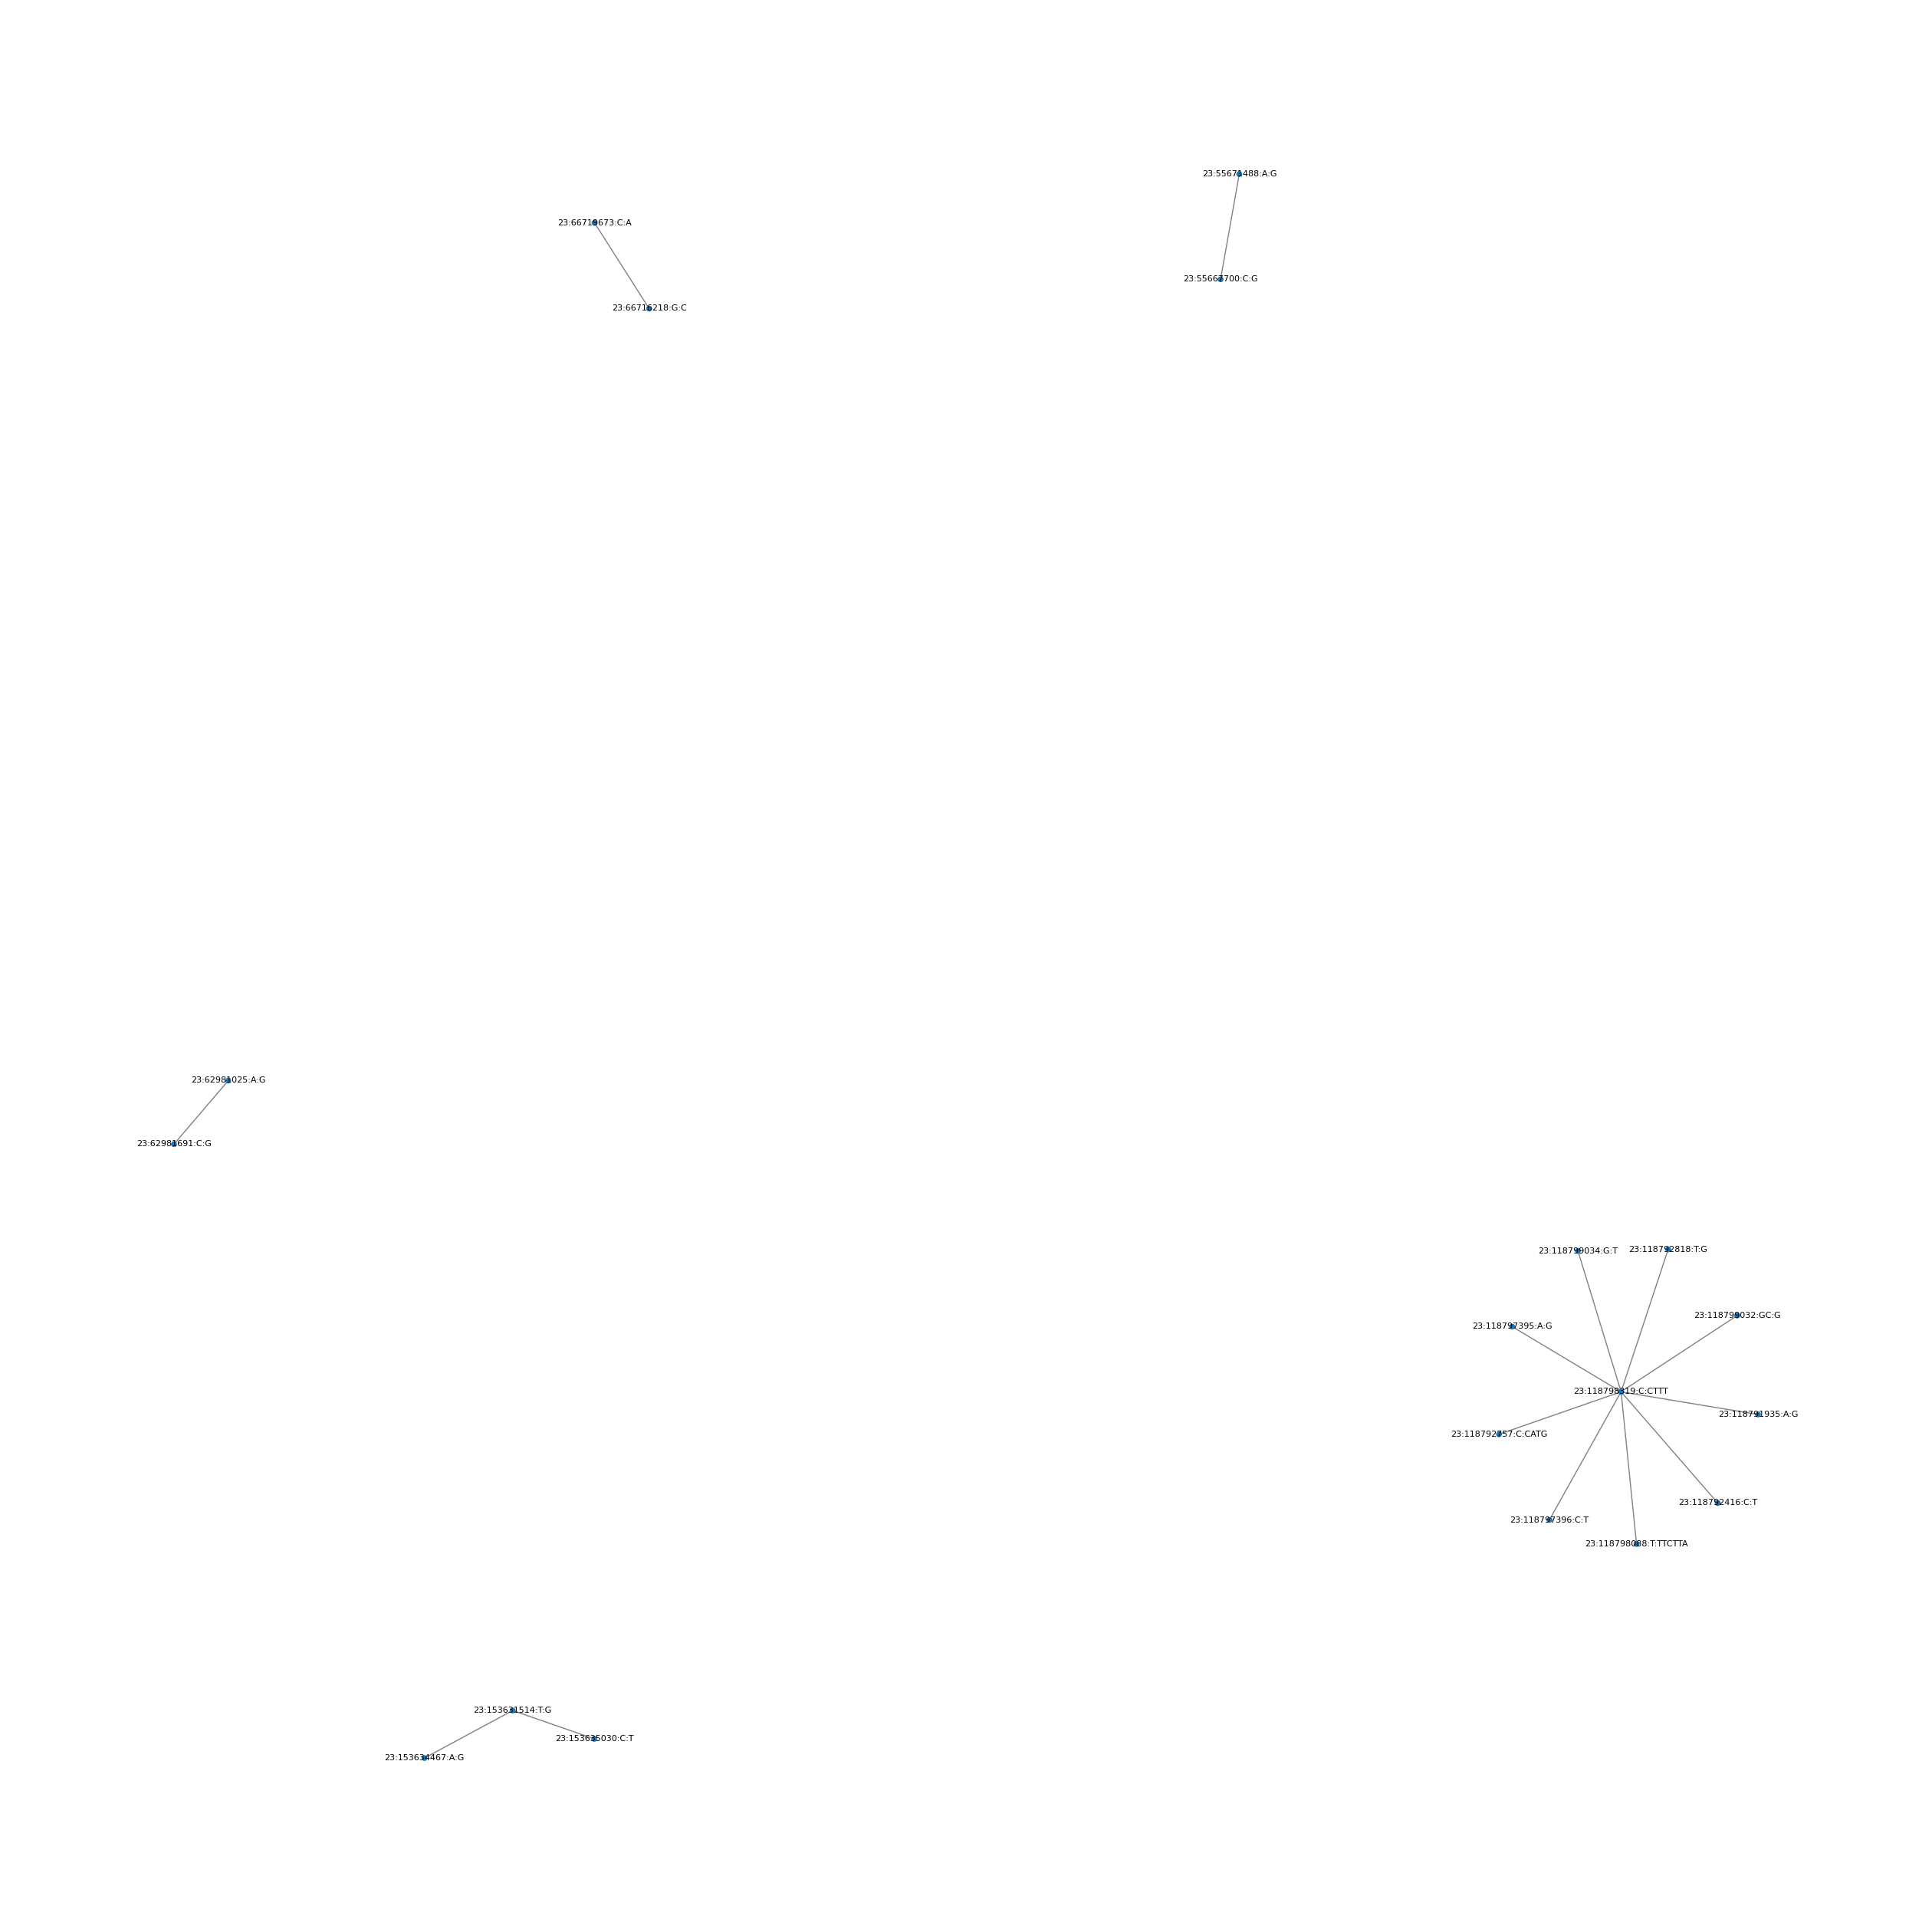

In [7]:
def visualize_graph(graph, chromosome: str):
    plt.figure(figsize=(25, 25))  # Increase figure size for better visibility
    
    # Create a subgraph for the specified chromosome
    nodes_chromosome = [node for node, attr in graph.nodes(data=True) if attr.get('#chrom') == chromosome]
    subgraph = graph.subgraph(nodes_chromosome)

    if subgraph.number_of_nodes() == 0:
        print(f"No nodes found for chromosome {chromosome}.")
        return

    # Get a list of unique chromosomes in the subgraph
    chroms = list(set(nx.get_node_attributes(subgraph, '#chrom').values()))
    # Assign each chromosome a color
    colormap = plt.cm.tab20
    
    # Get node colors
    node_colors = [colormap(chroms.index(subgraph.nodes[node]['#chrom'])) for node in subgraph.nodes]

    pos = nx.spring_layout(subgraph, k=0.25)  
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=20, 
            font_size=8, edge_color='gray')  
    
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)  
    
    plt.show()

# To visualize a specific chromosome, pass the chromosome number as a string. For example:
visualize_graph(graph, "23")


### All Chromsomes  

Chromosome 1


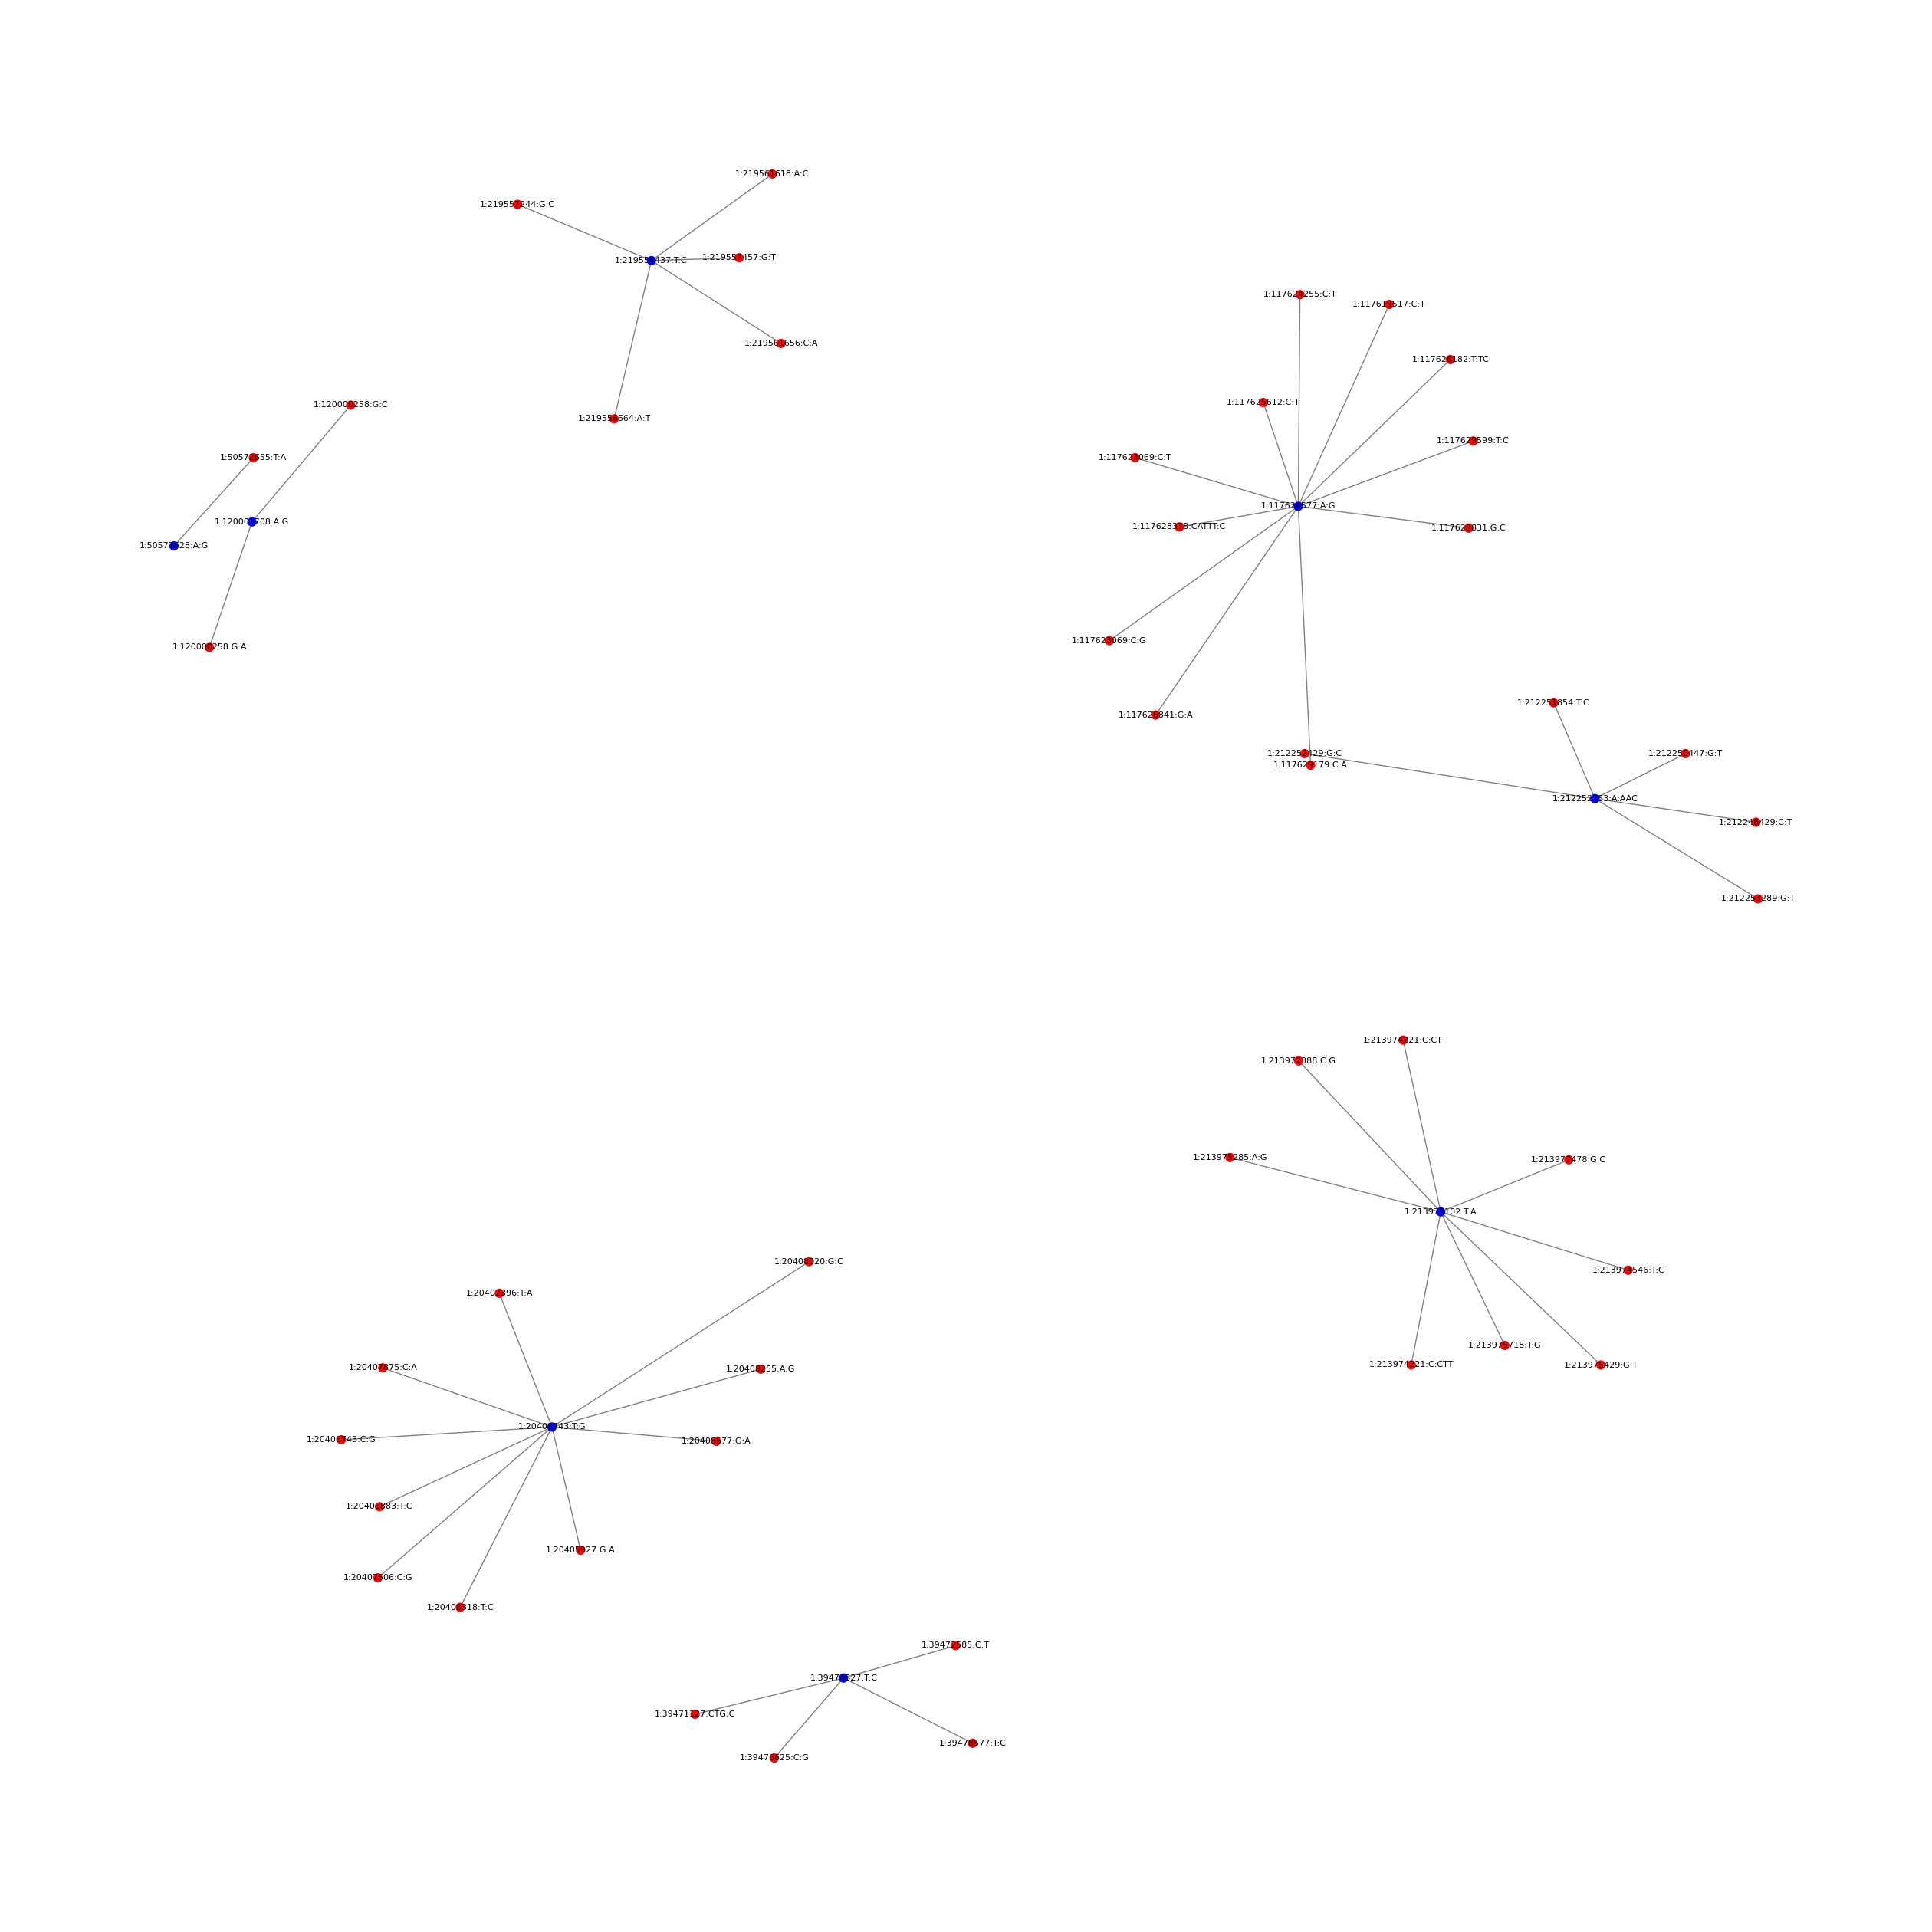

Chromosome 2


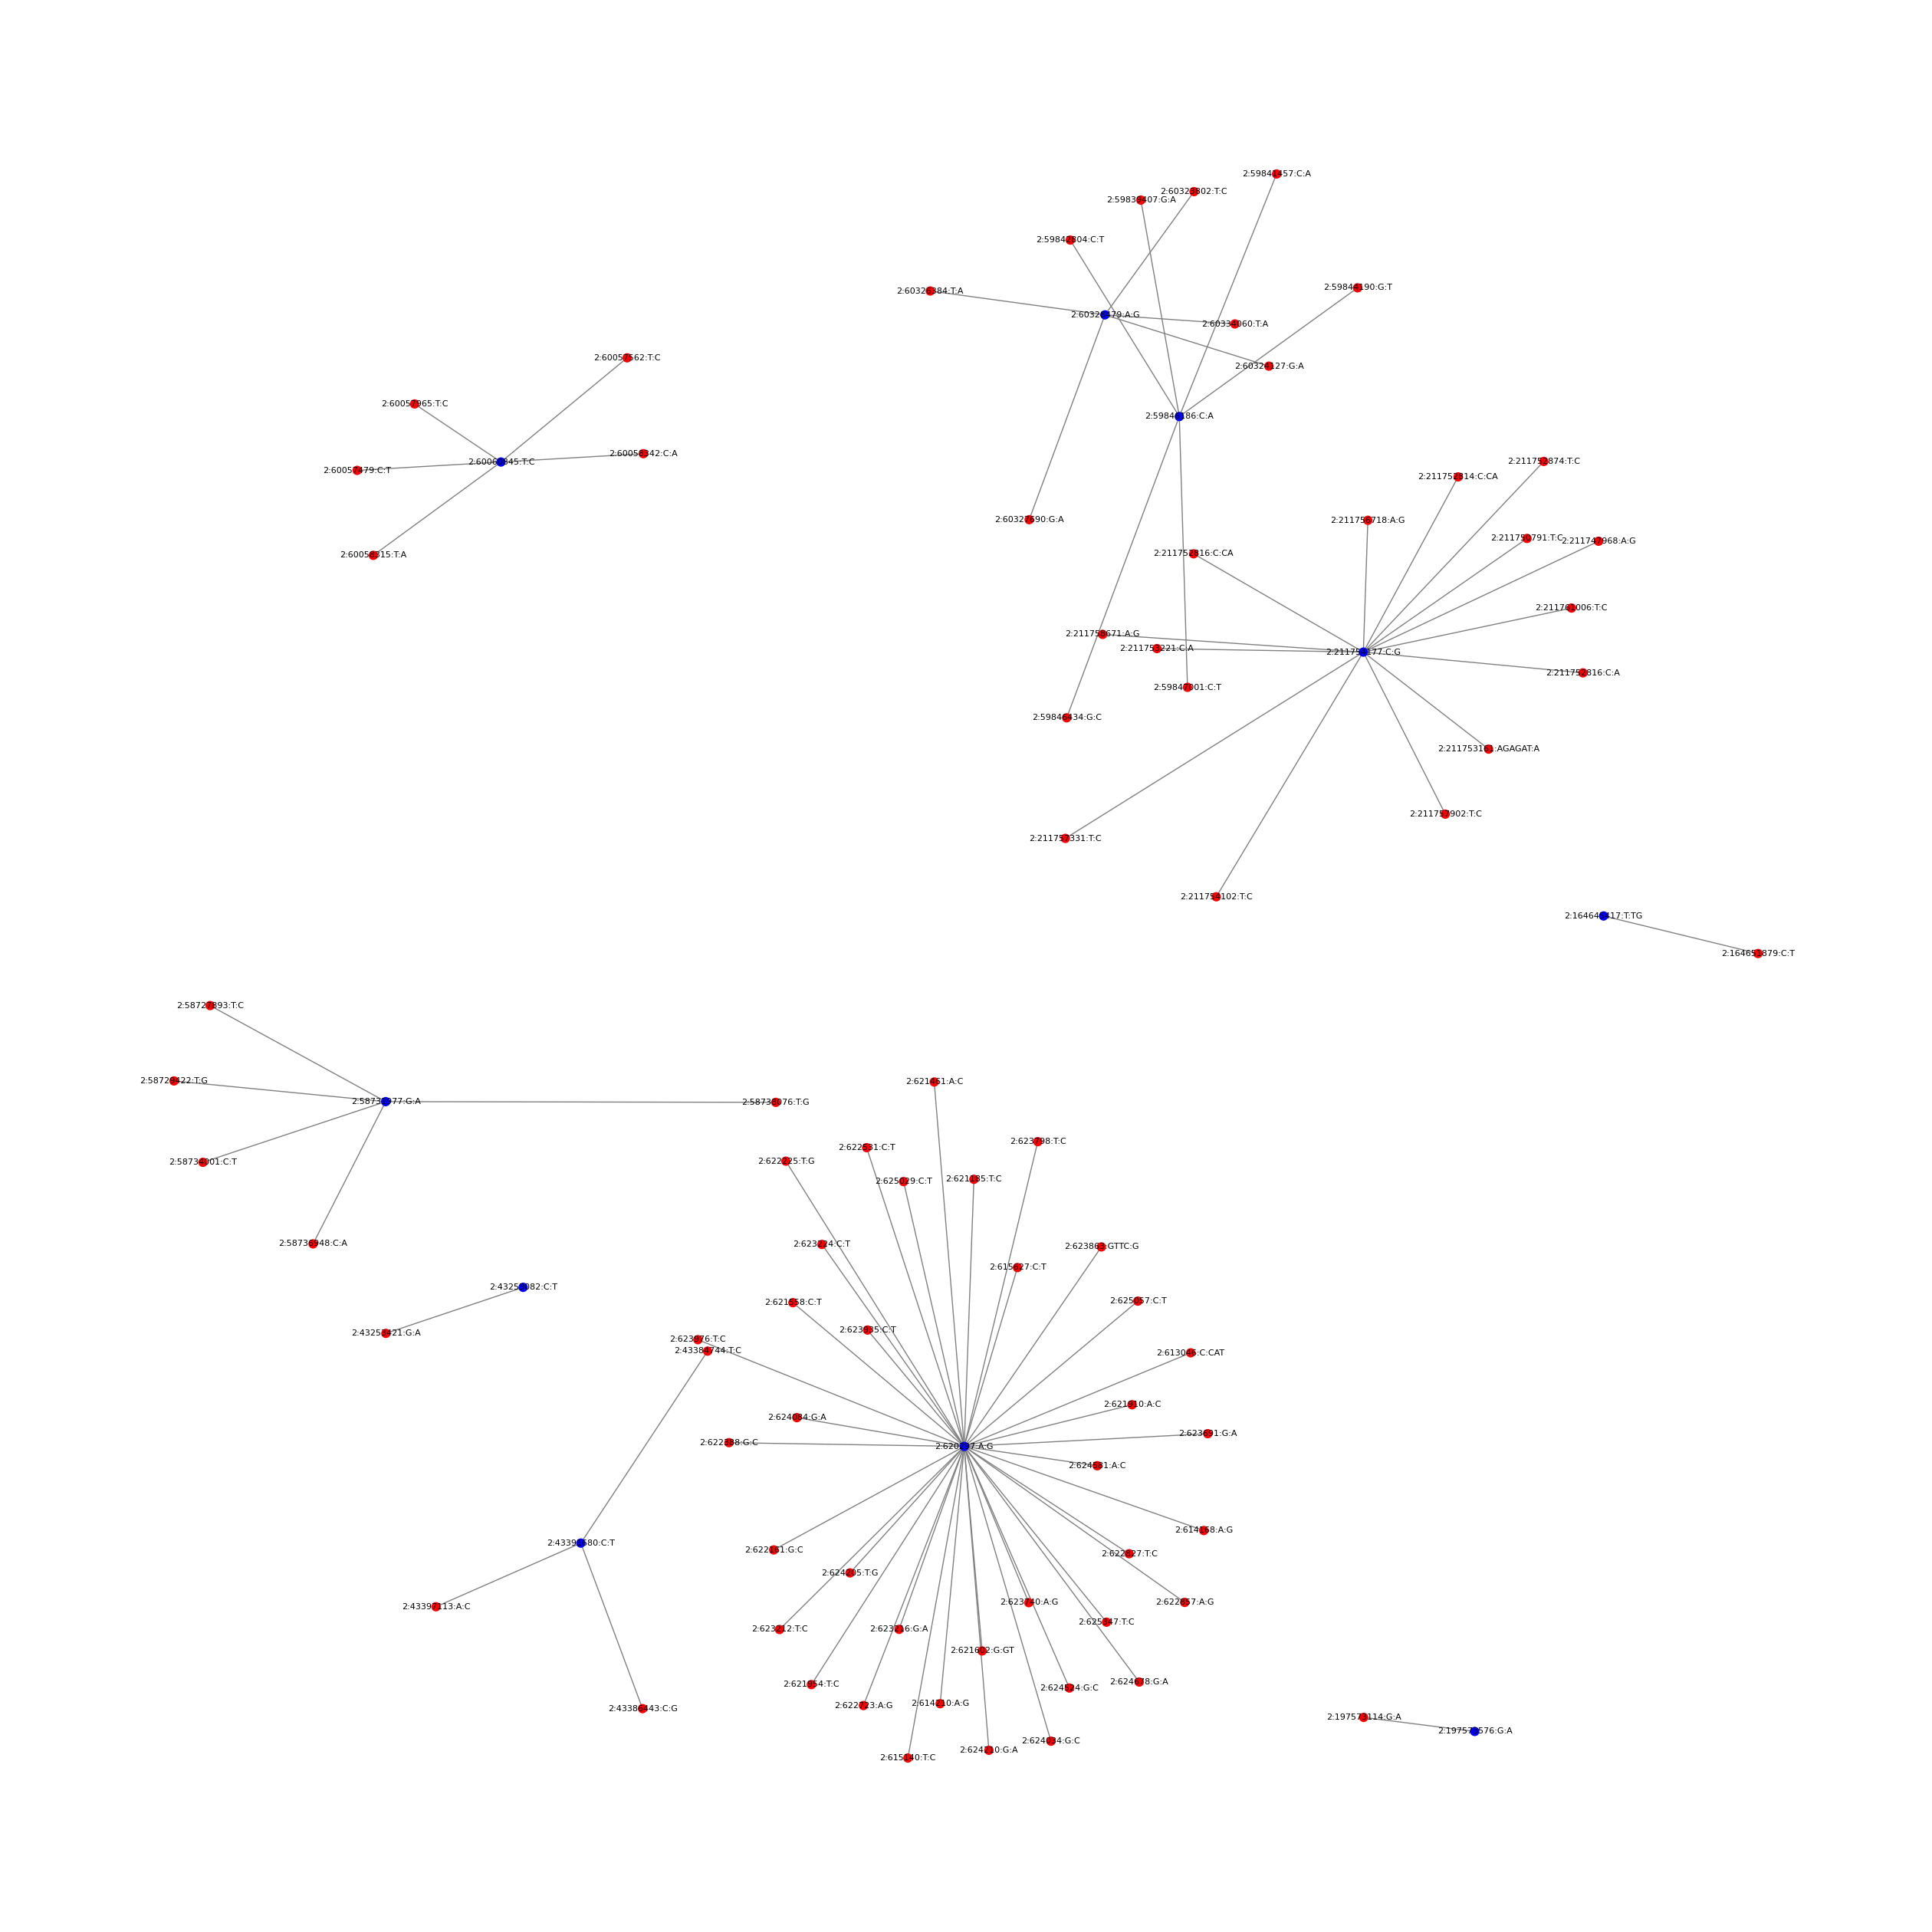

Chromosome 3


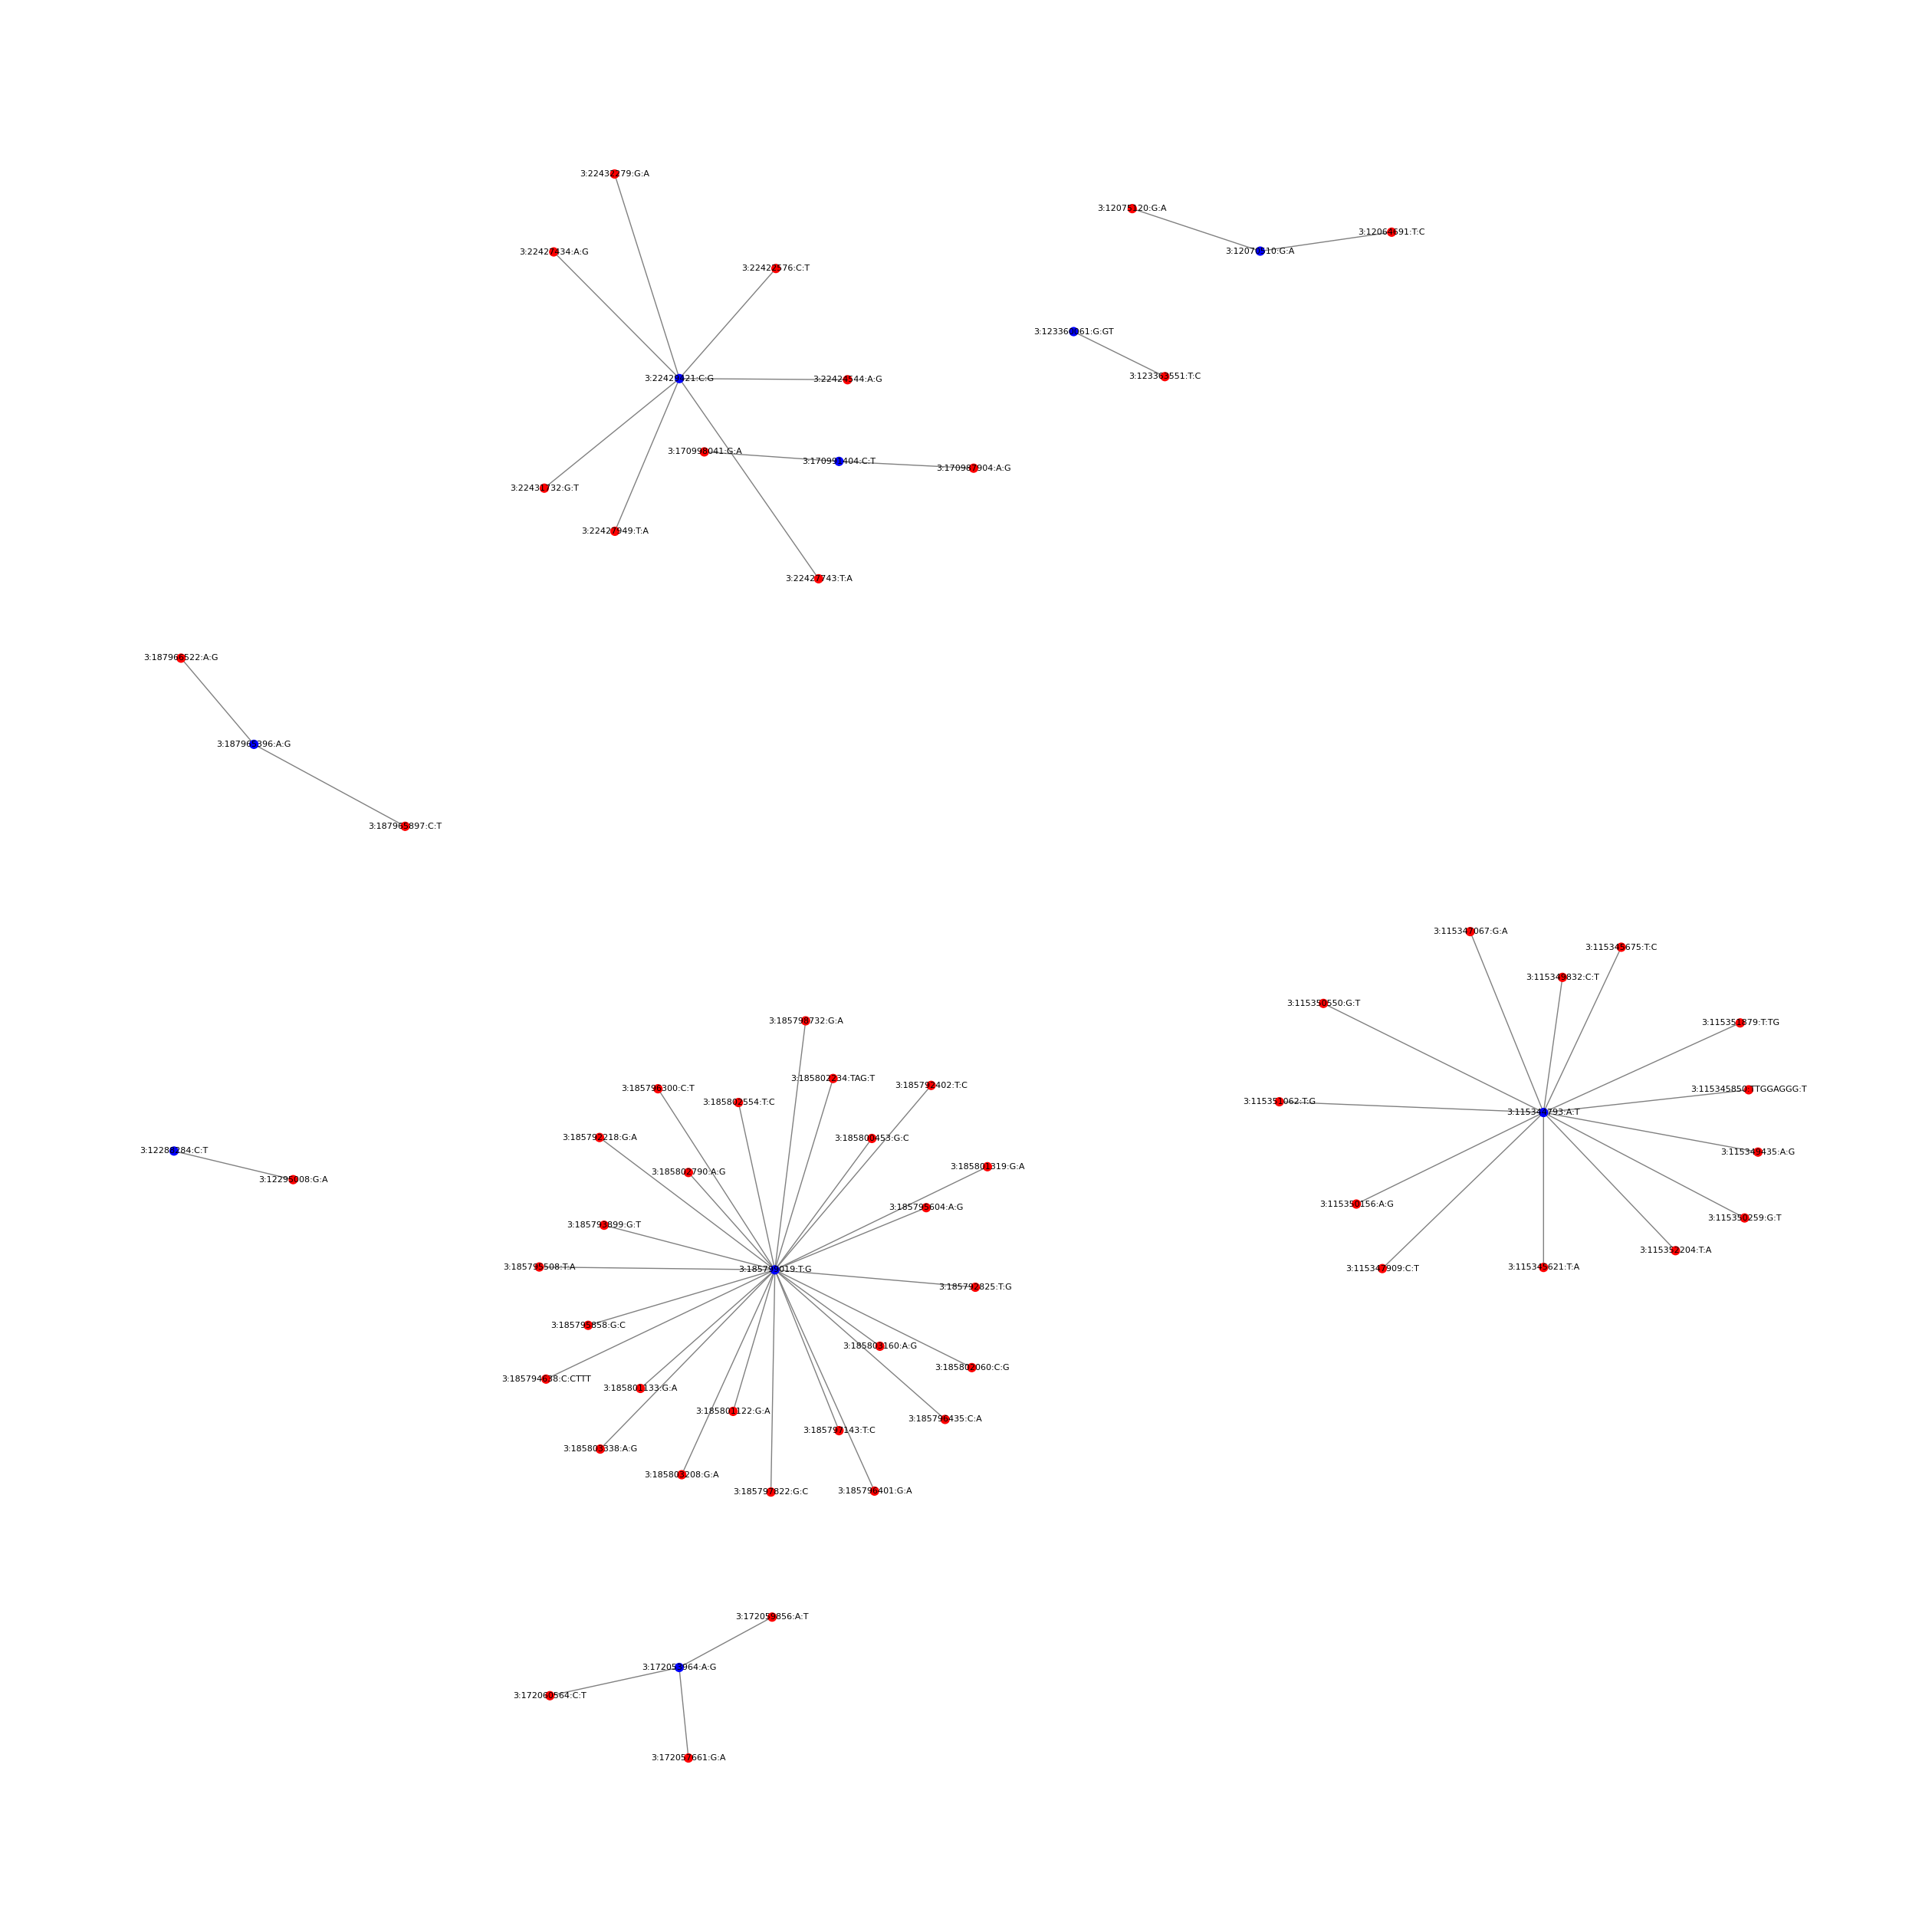

Chromosome 4


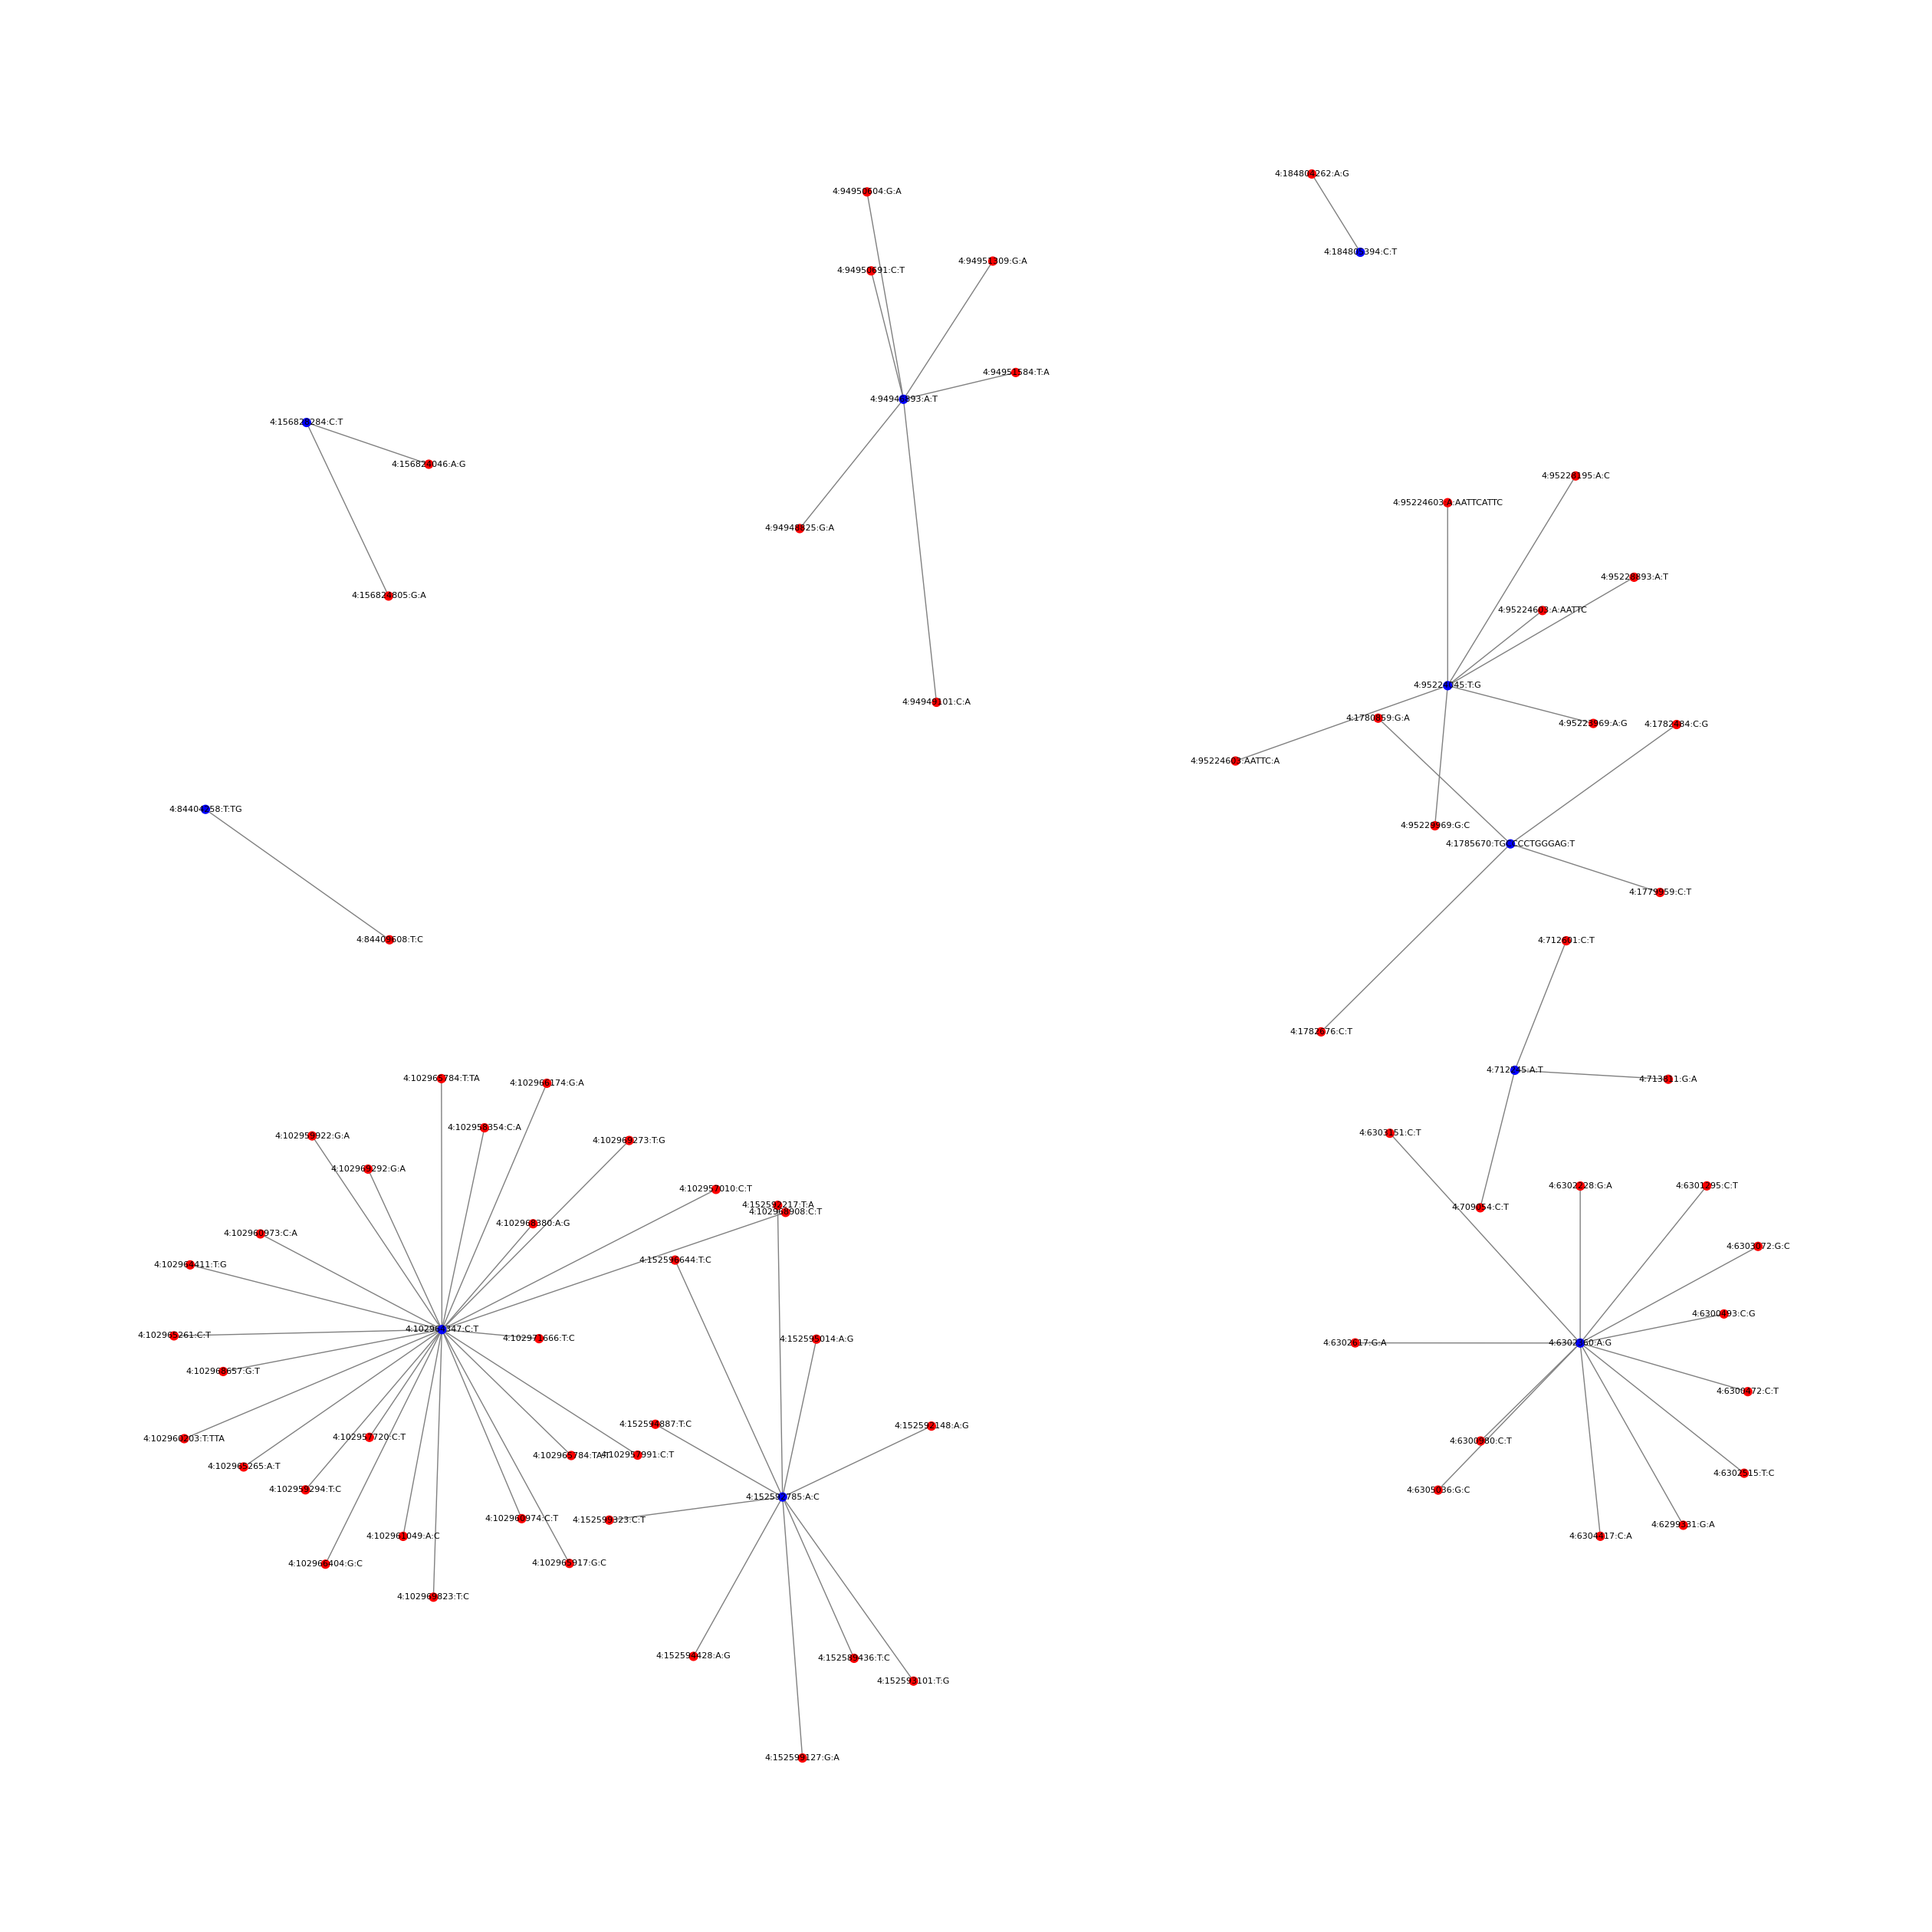

Chromosome 5


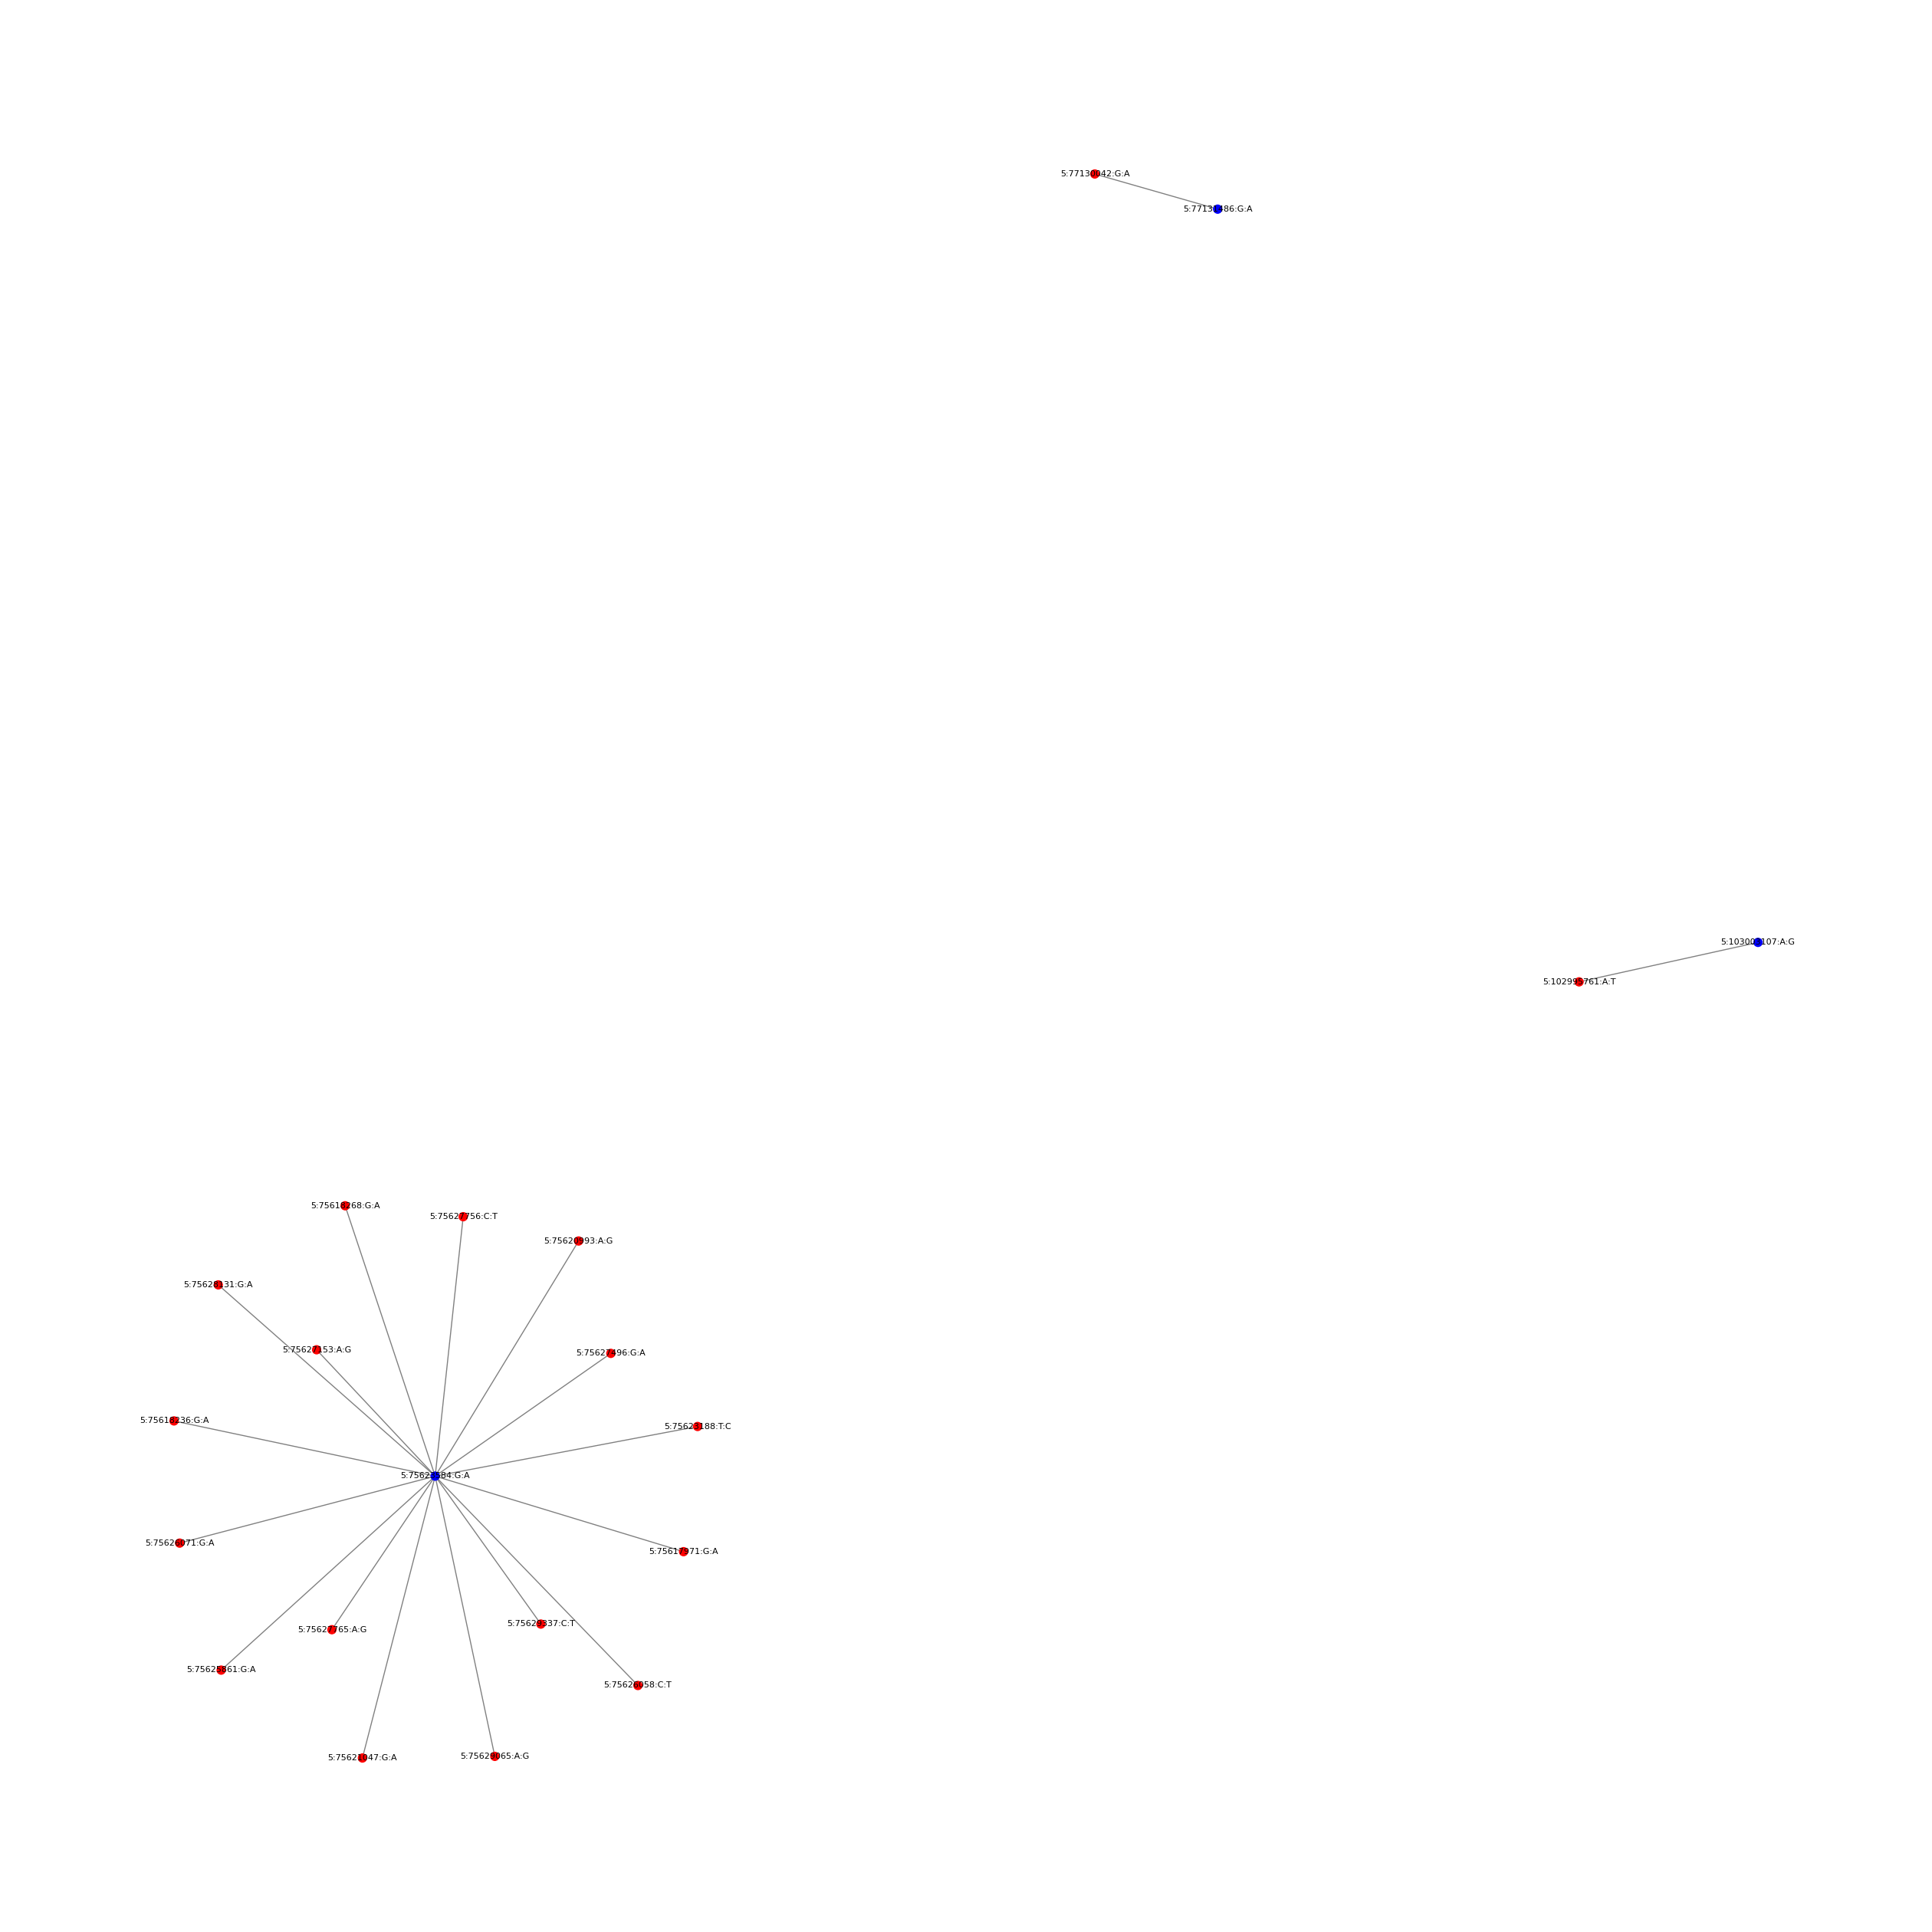

Chromosome 6


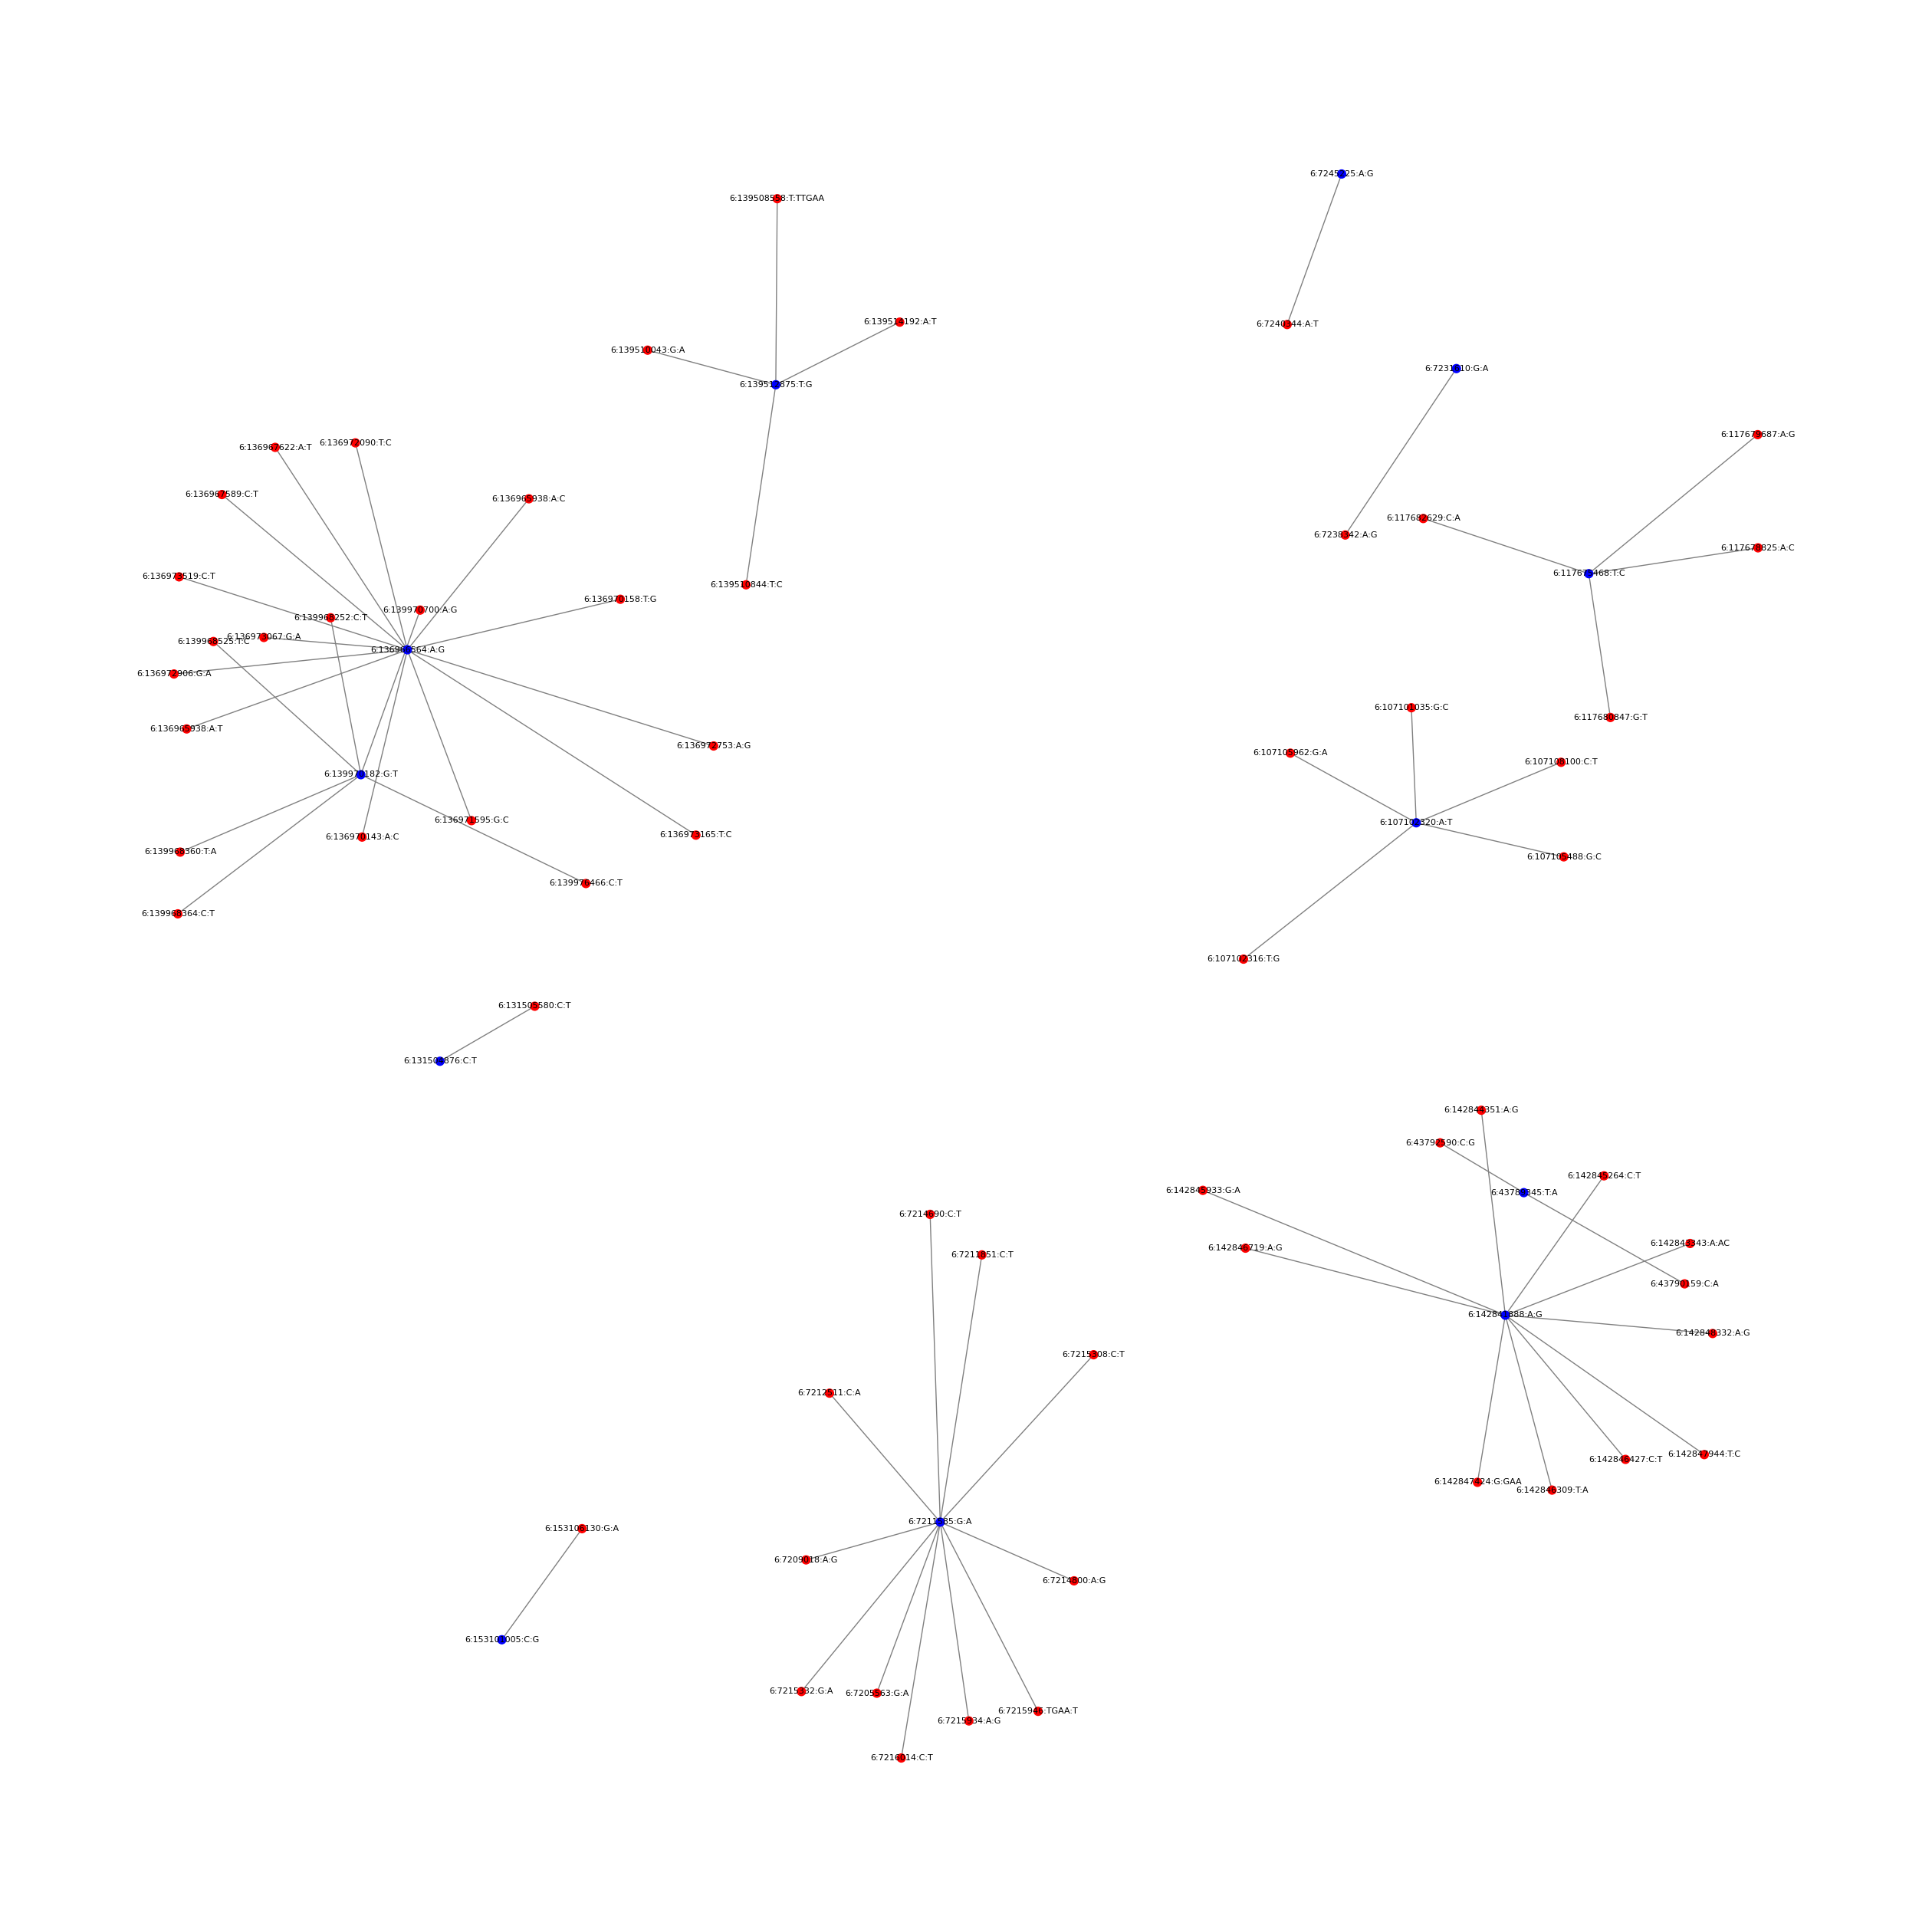

Chromosome 7


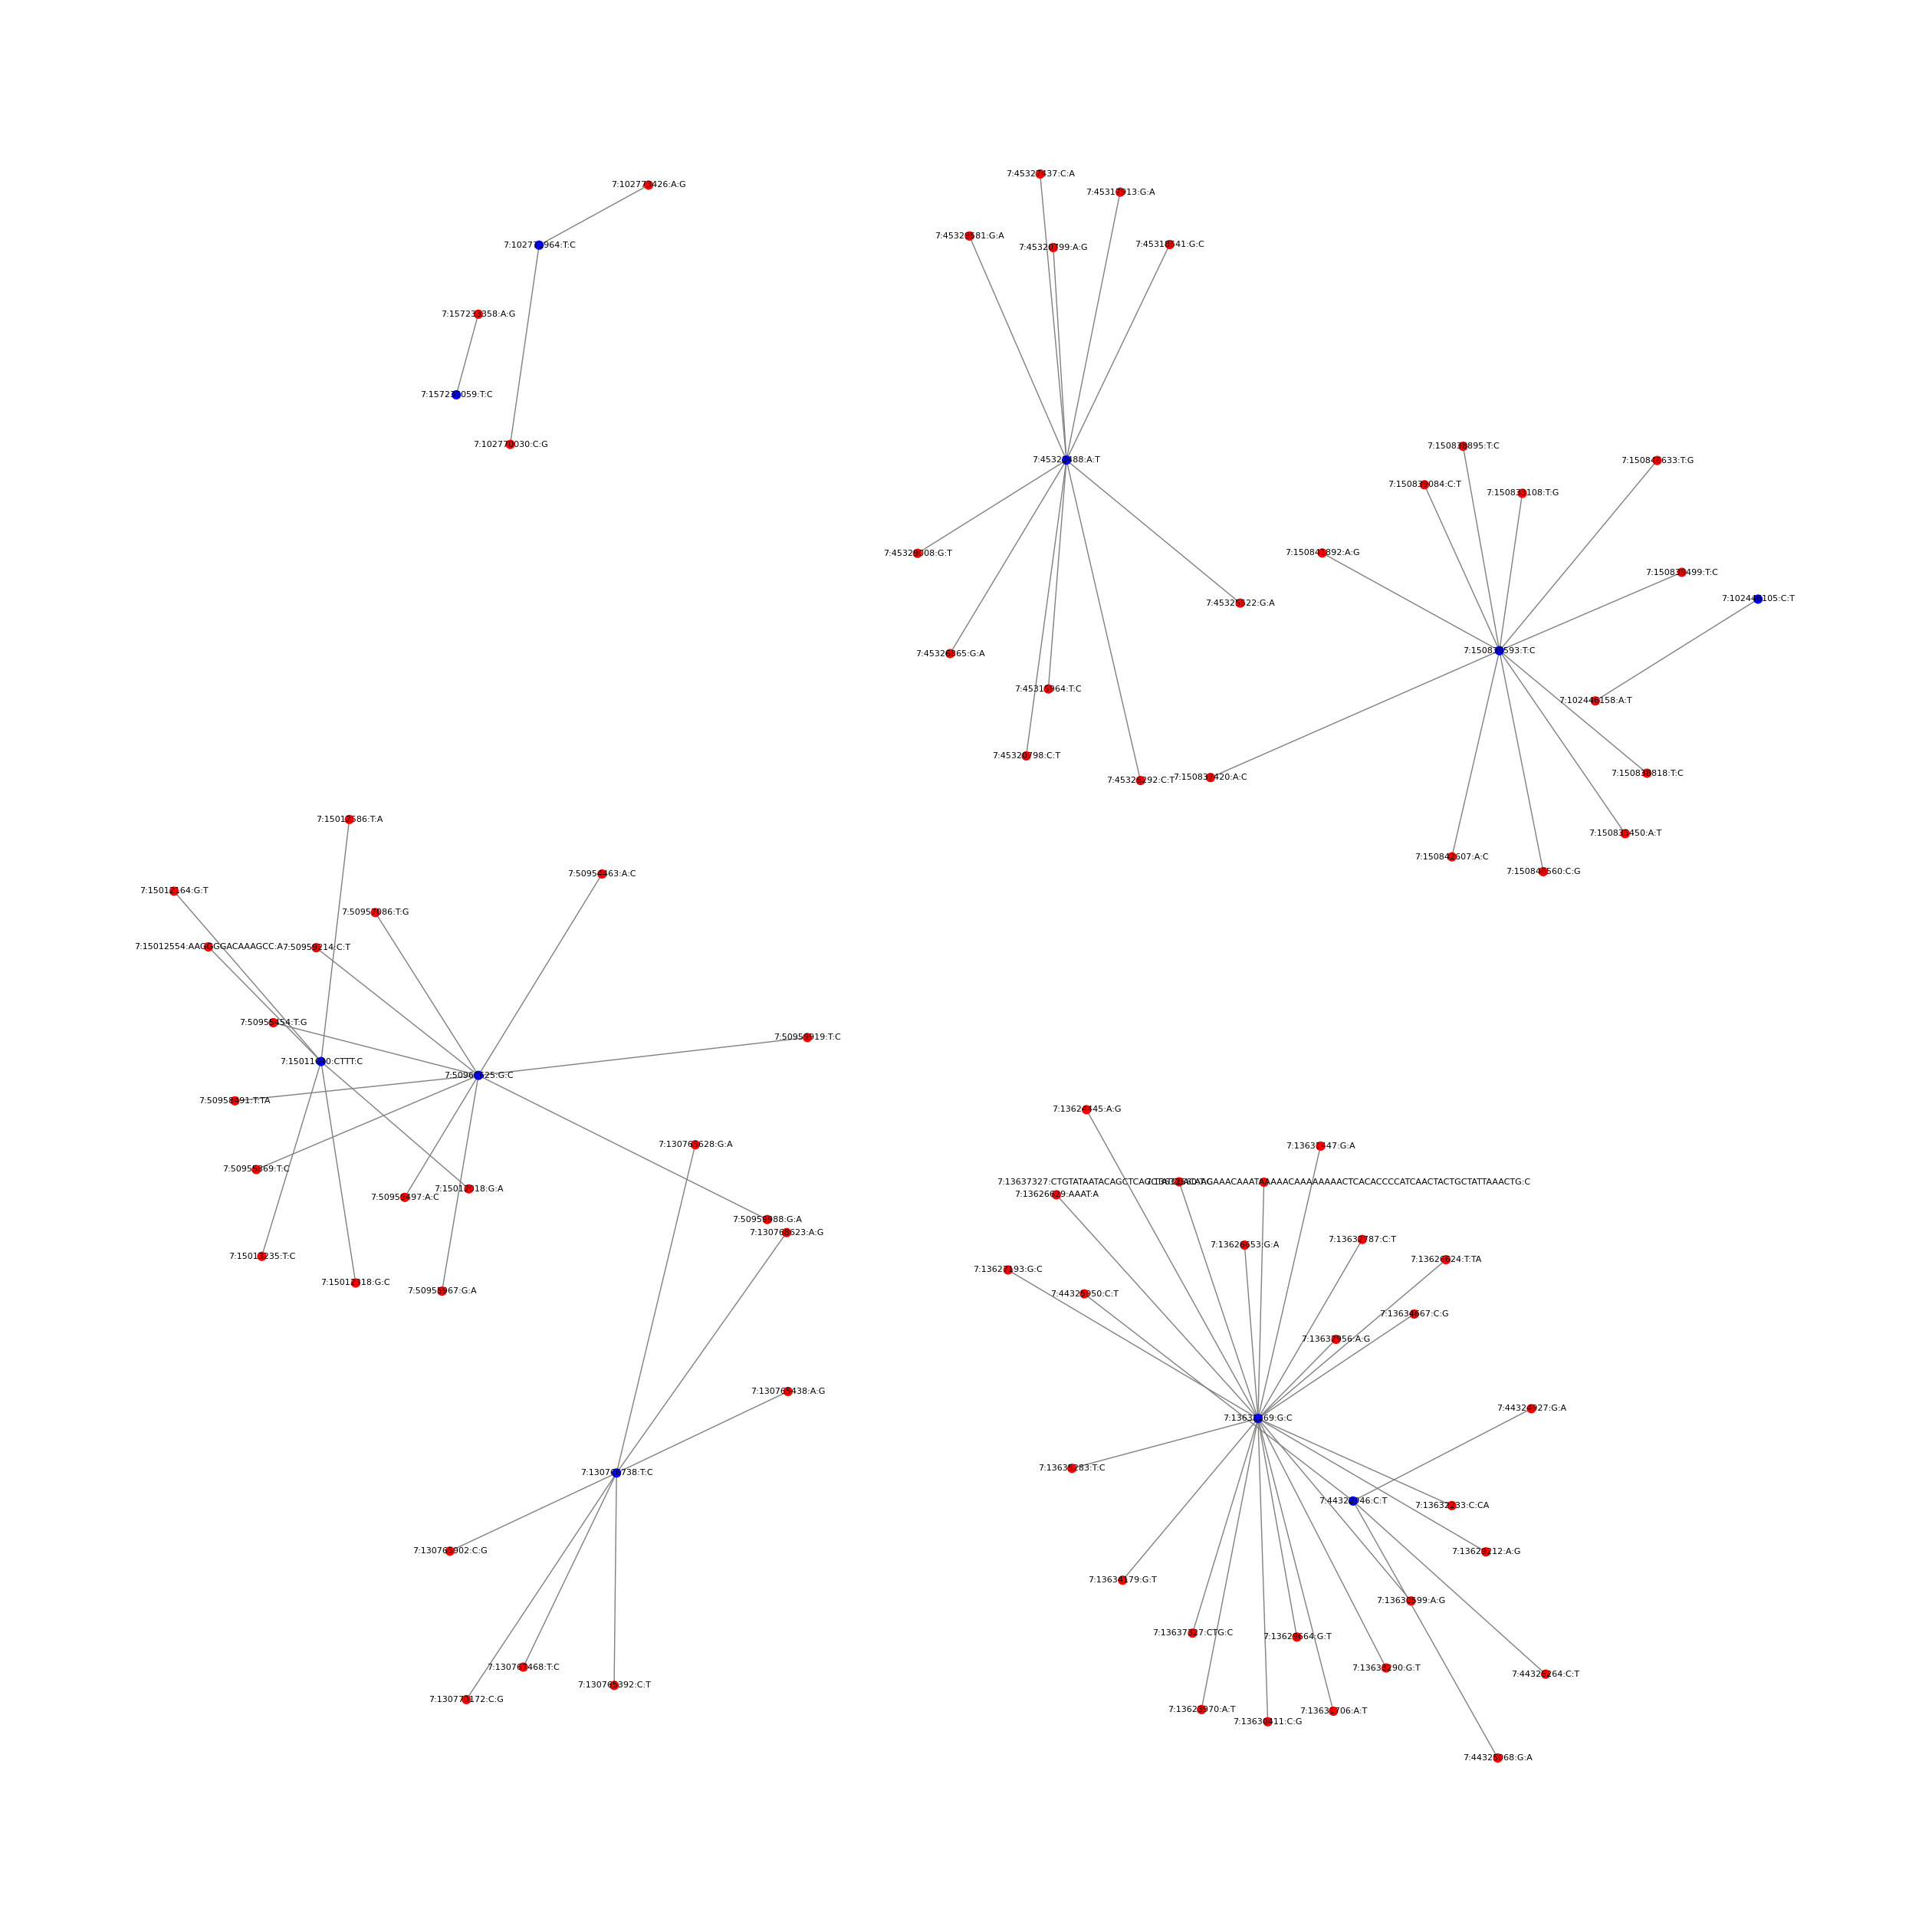

Chromosome 8


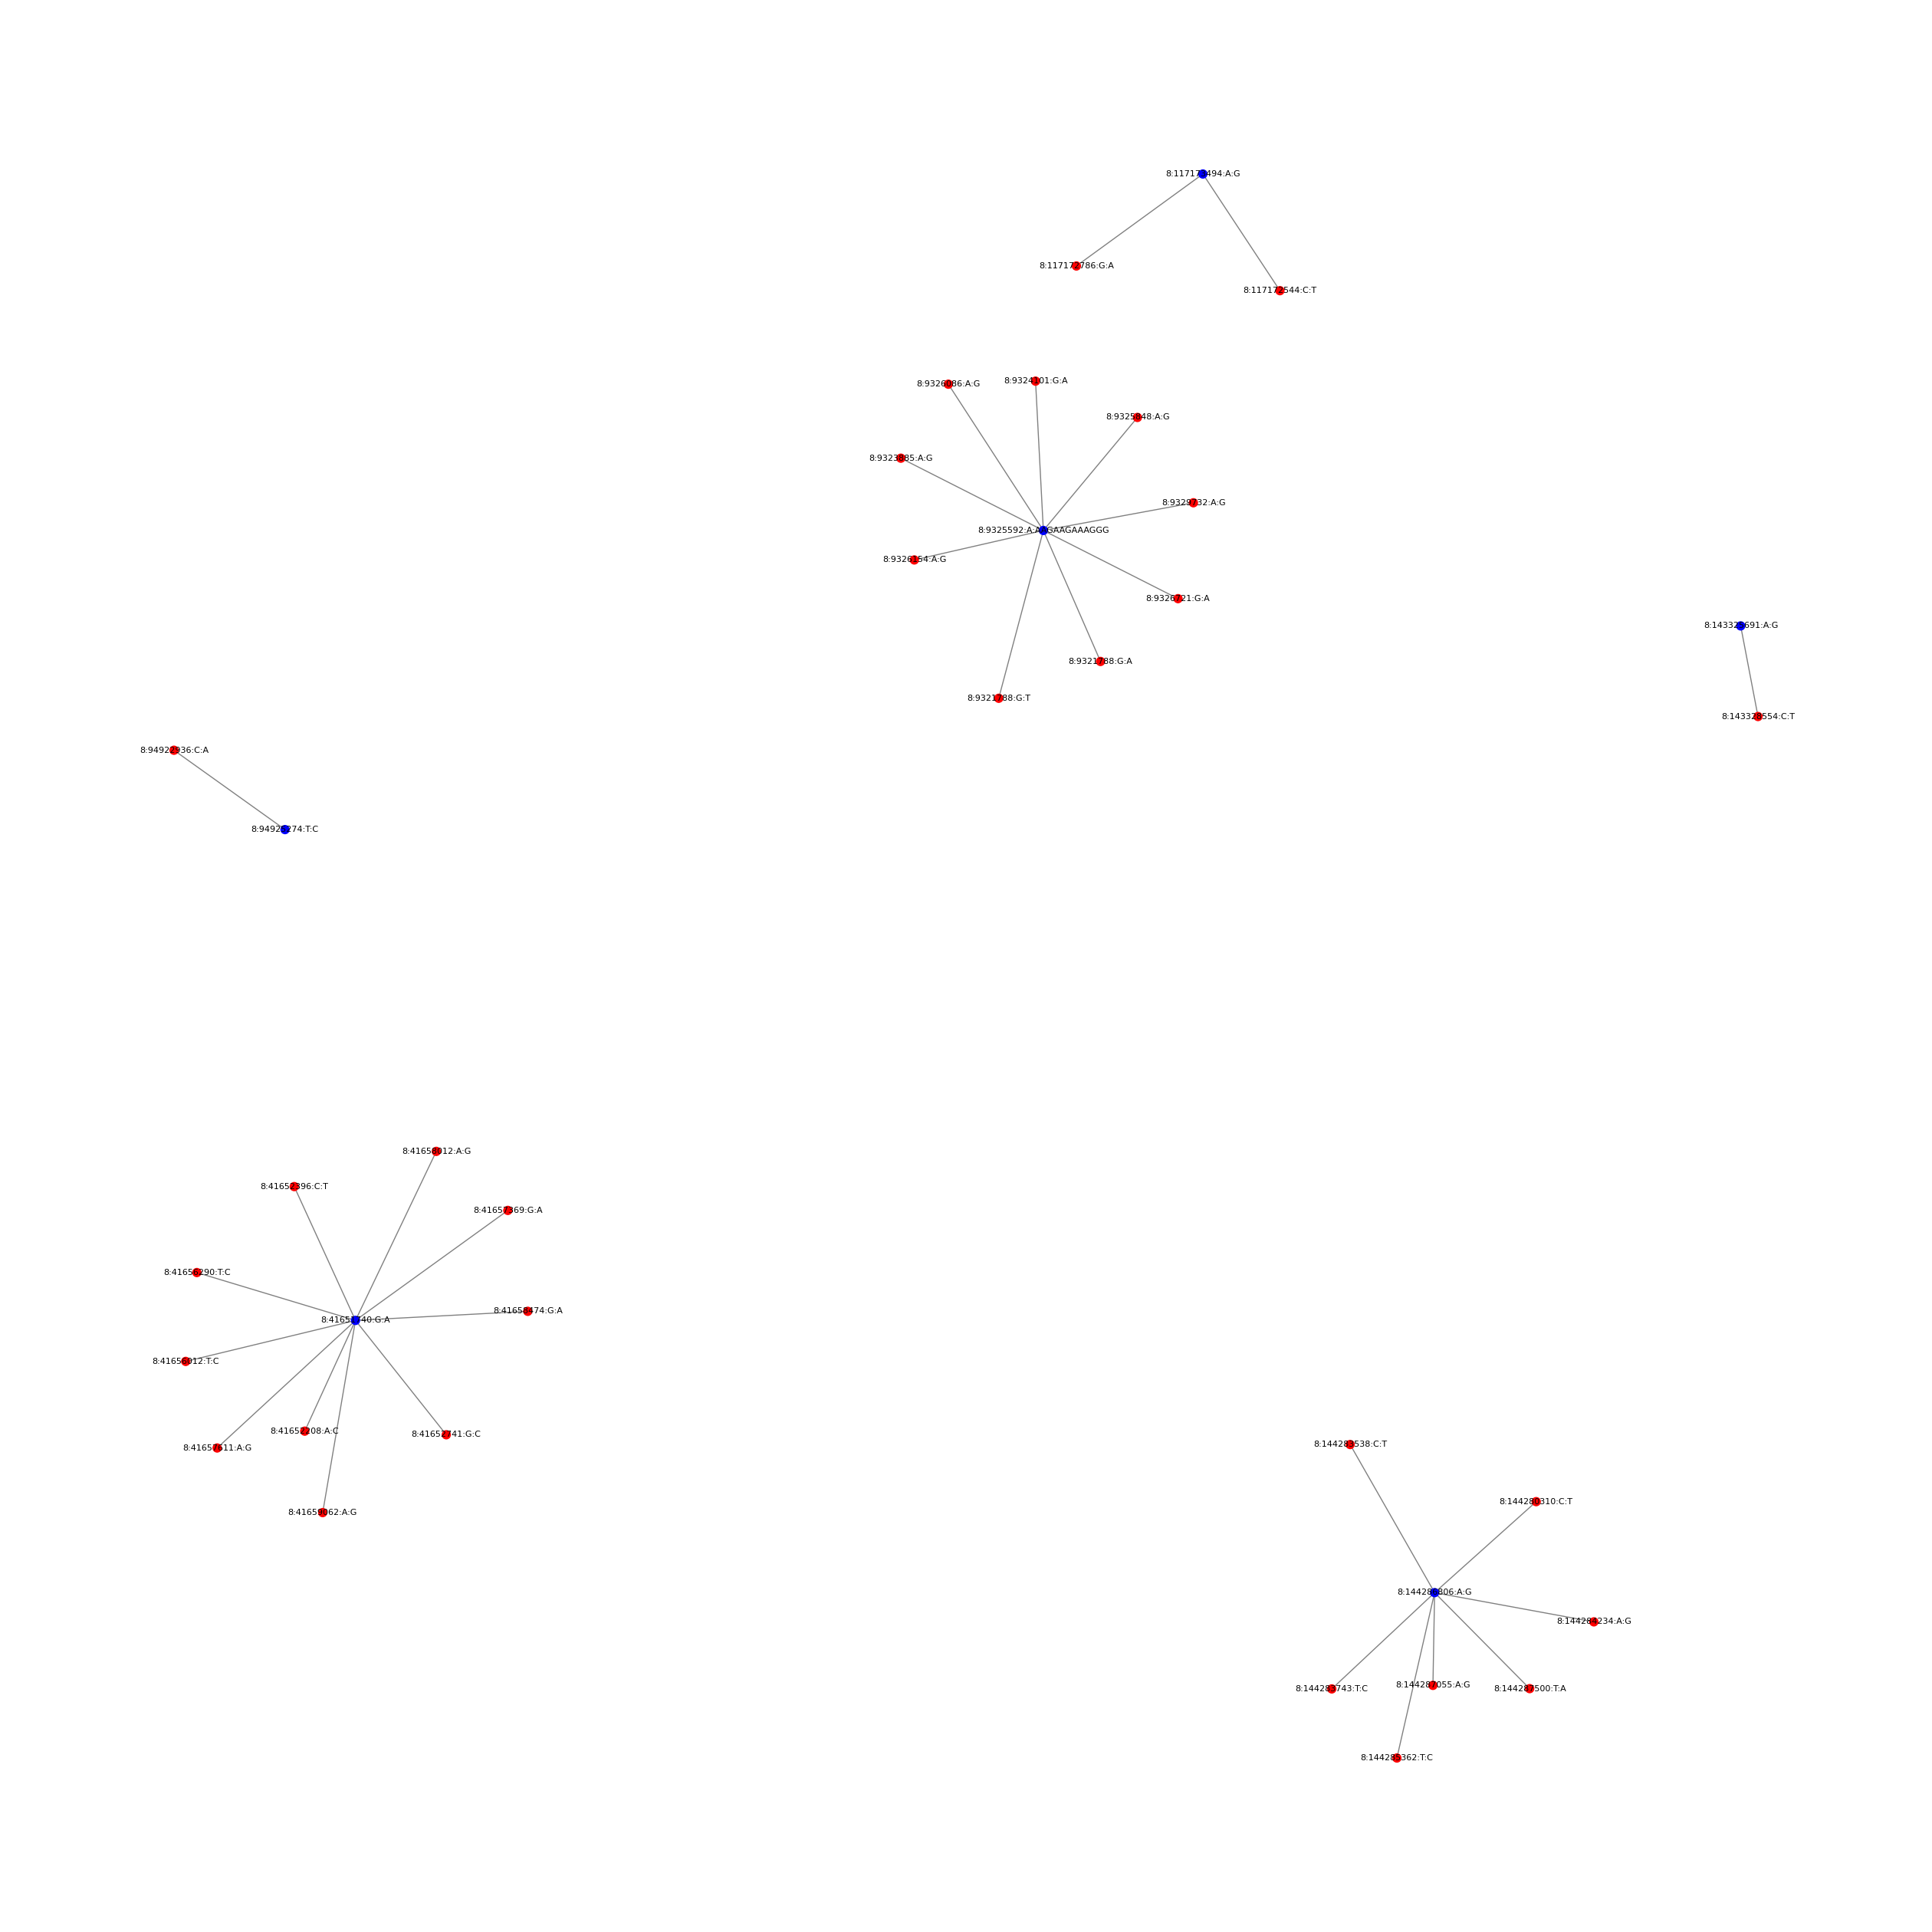

Chromosome 9


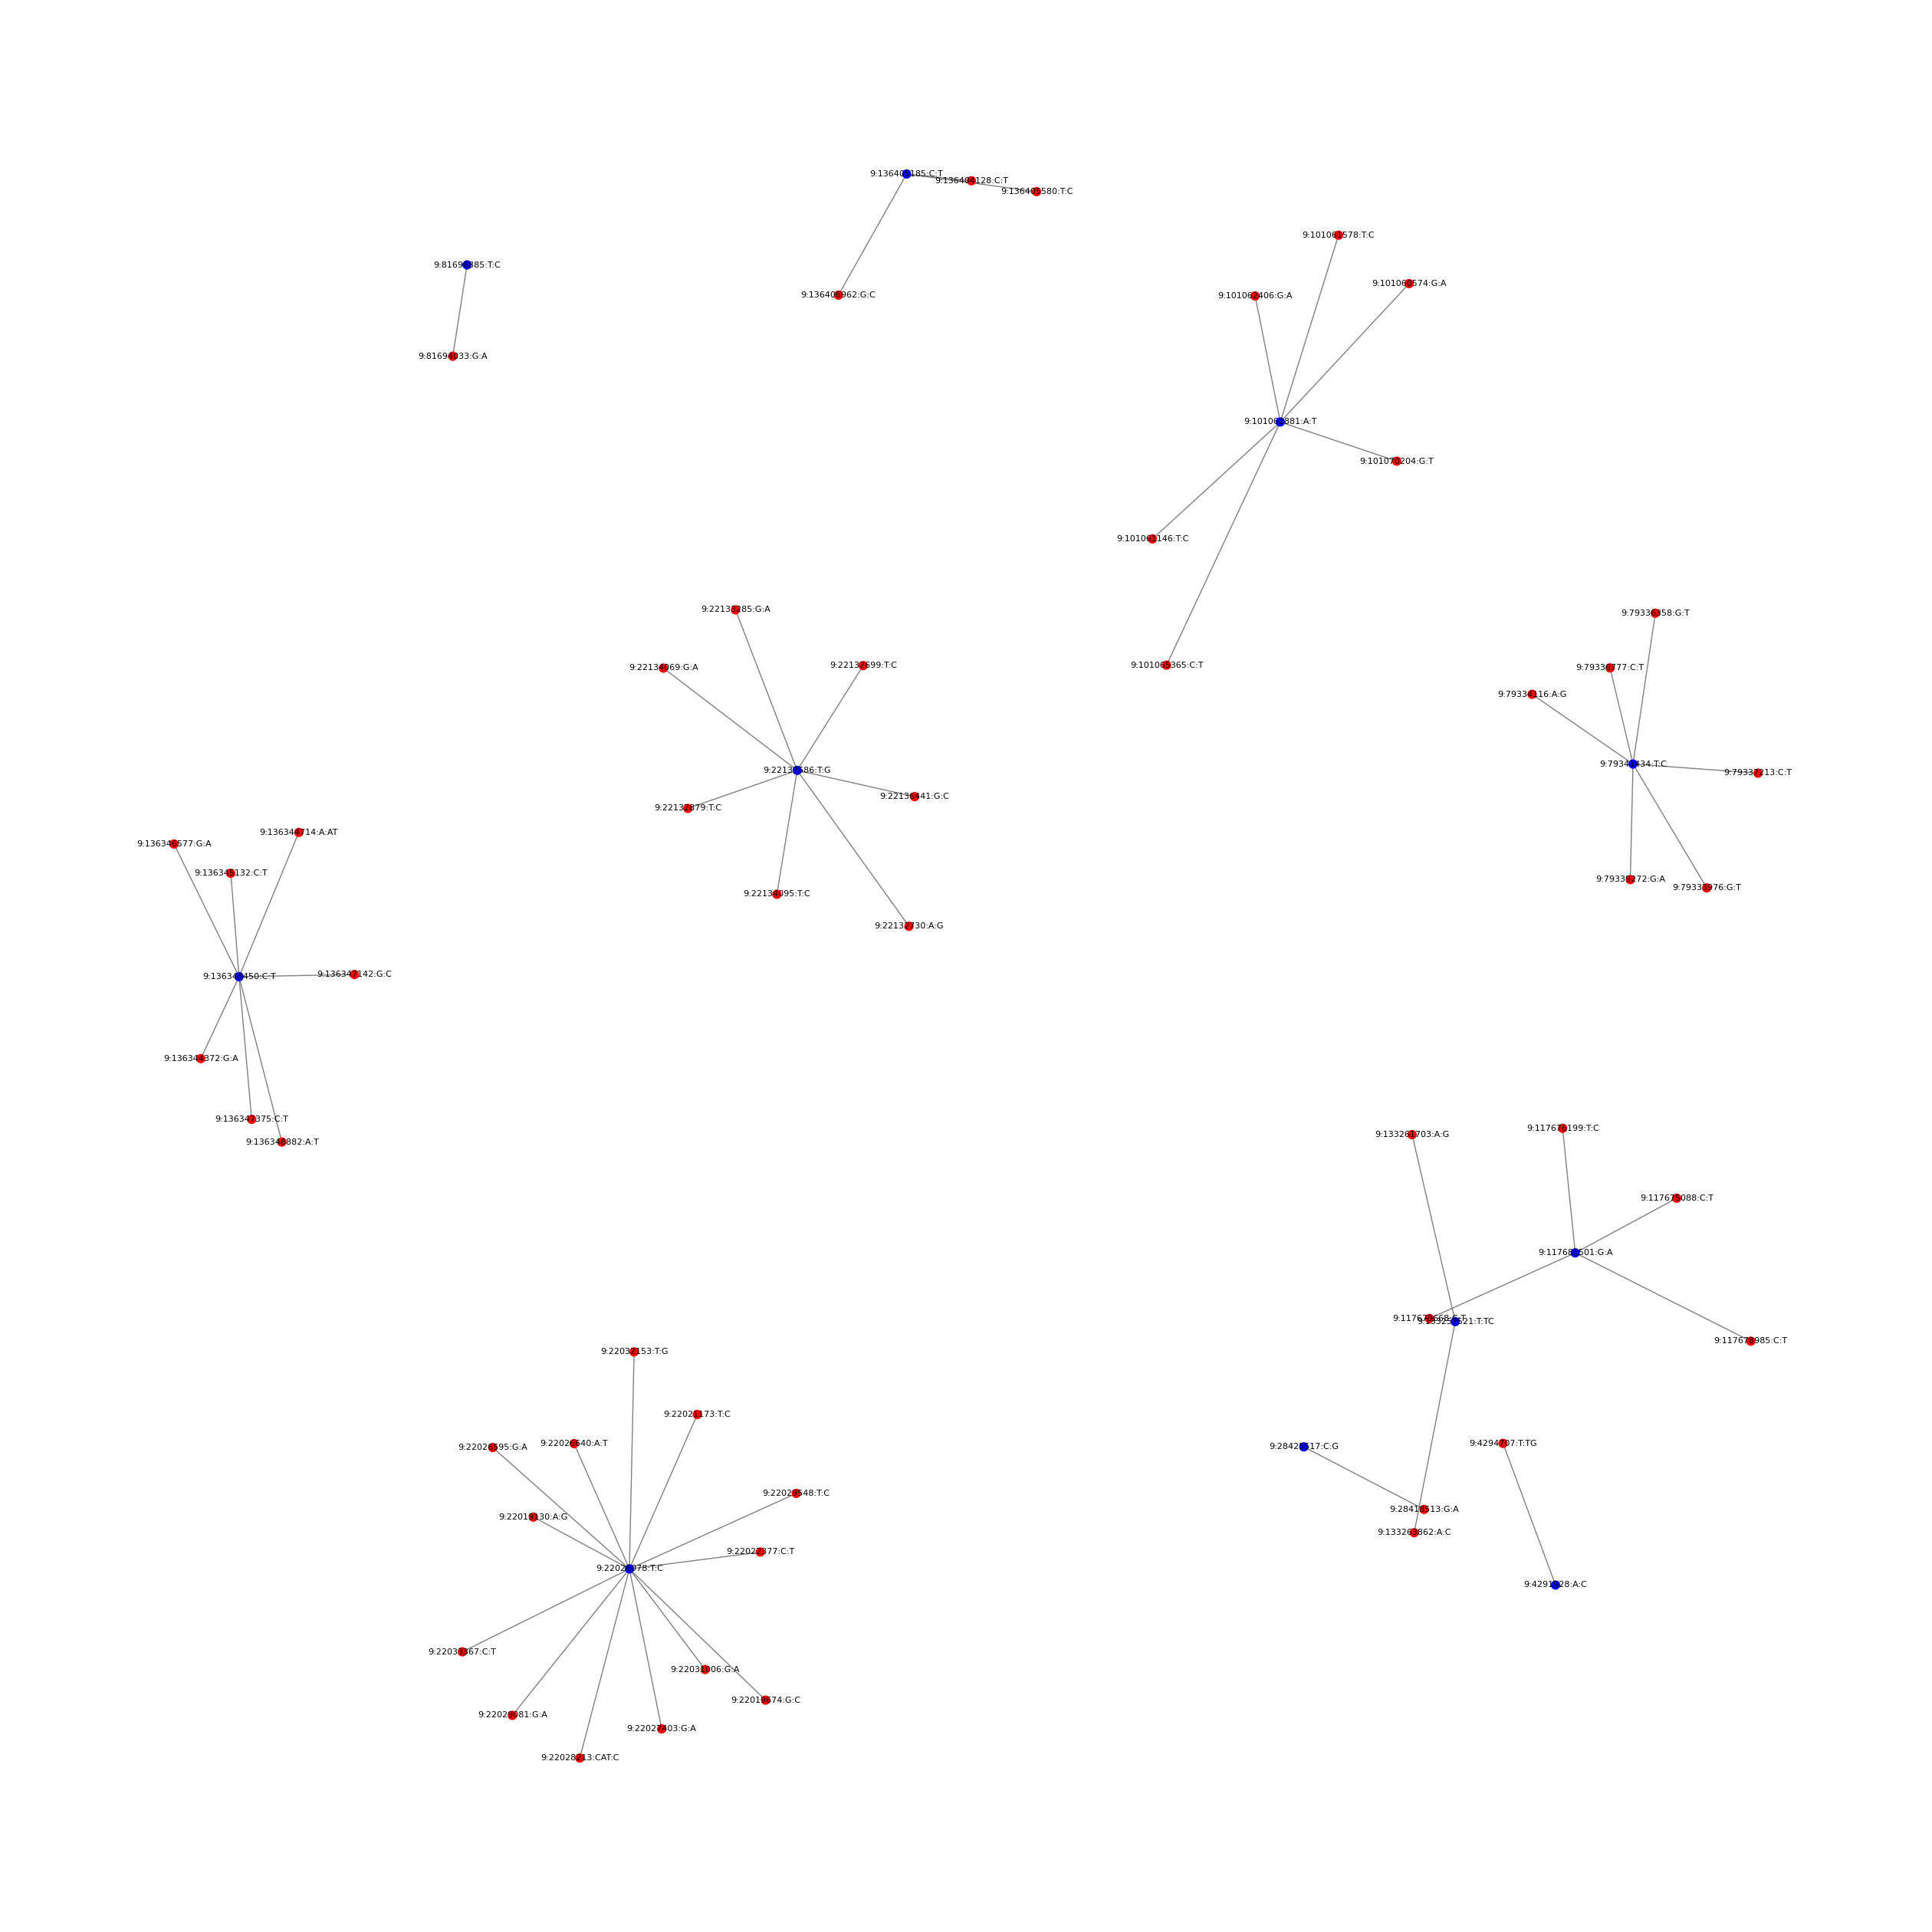

Chromosome 10


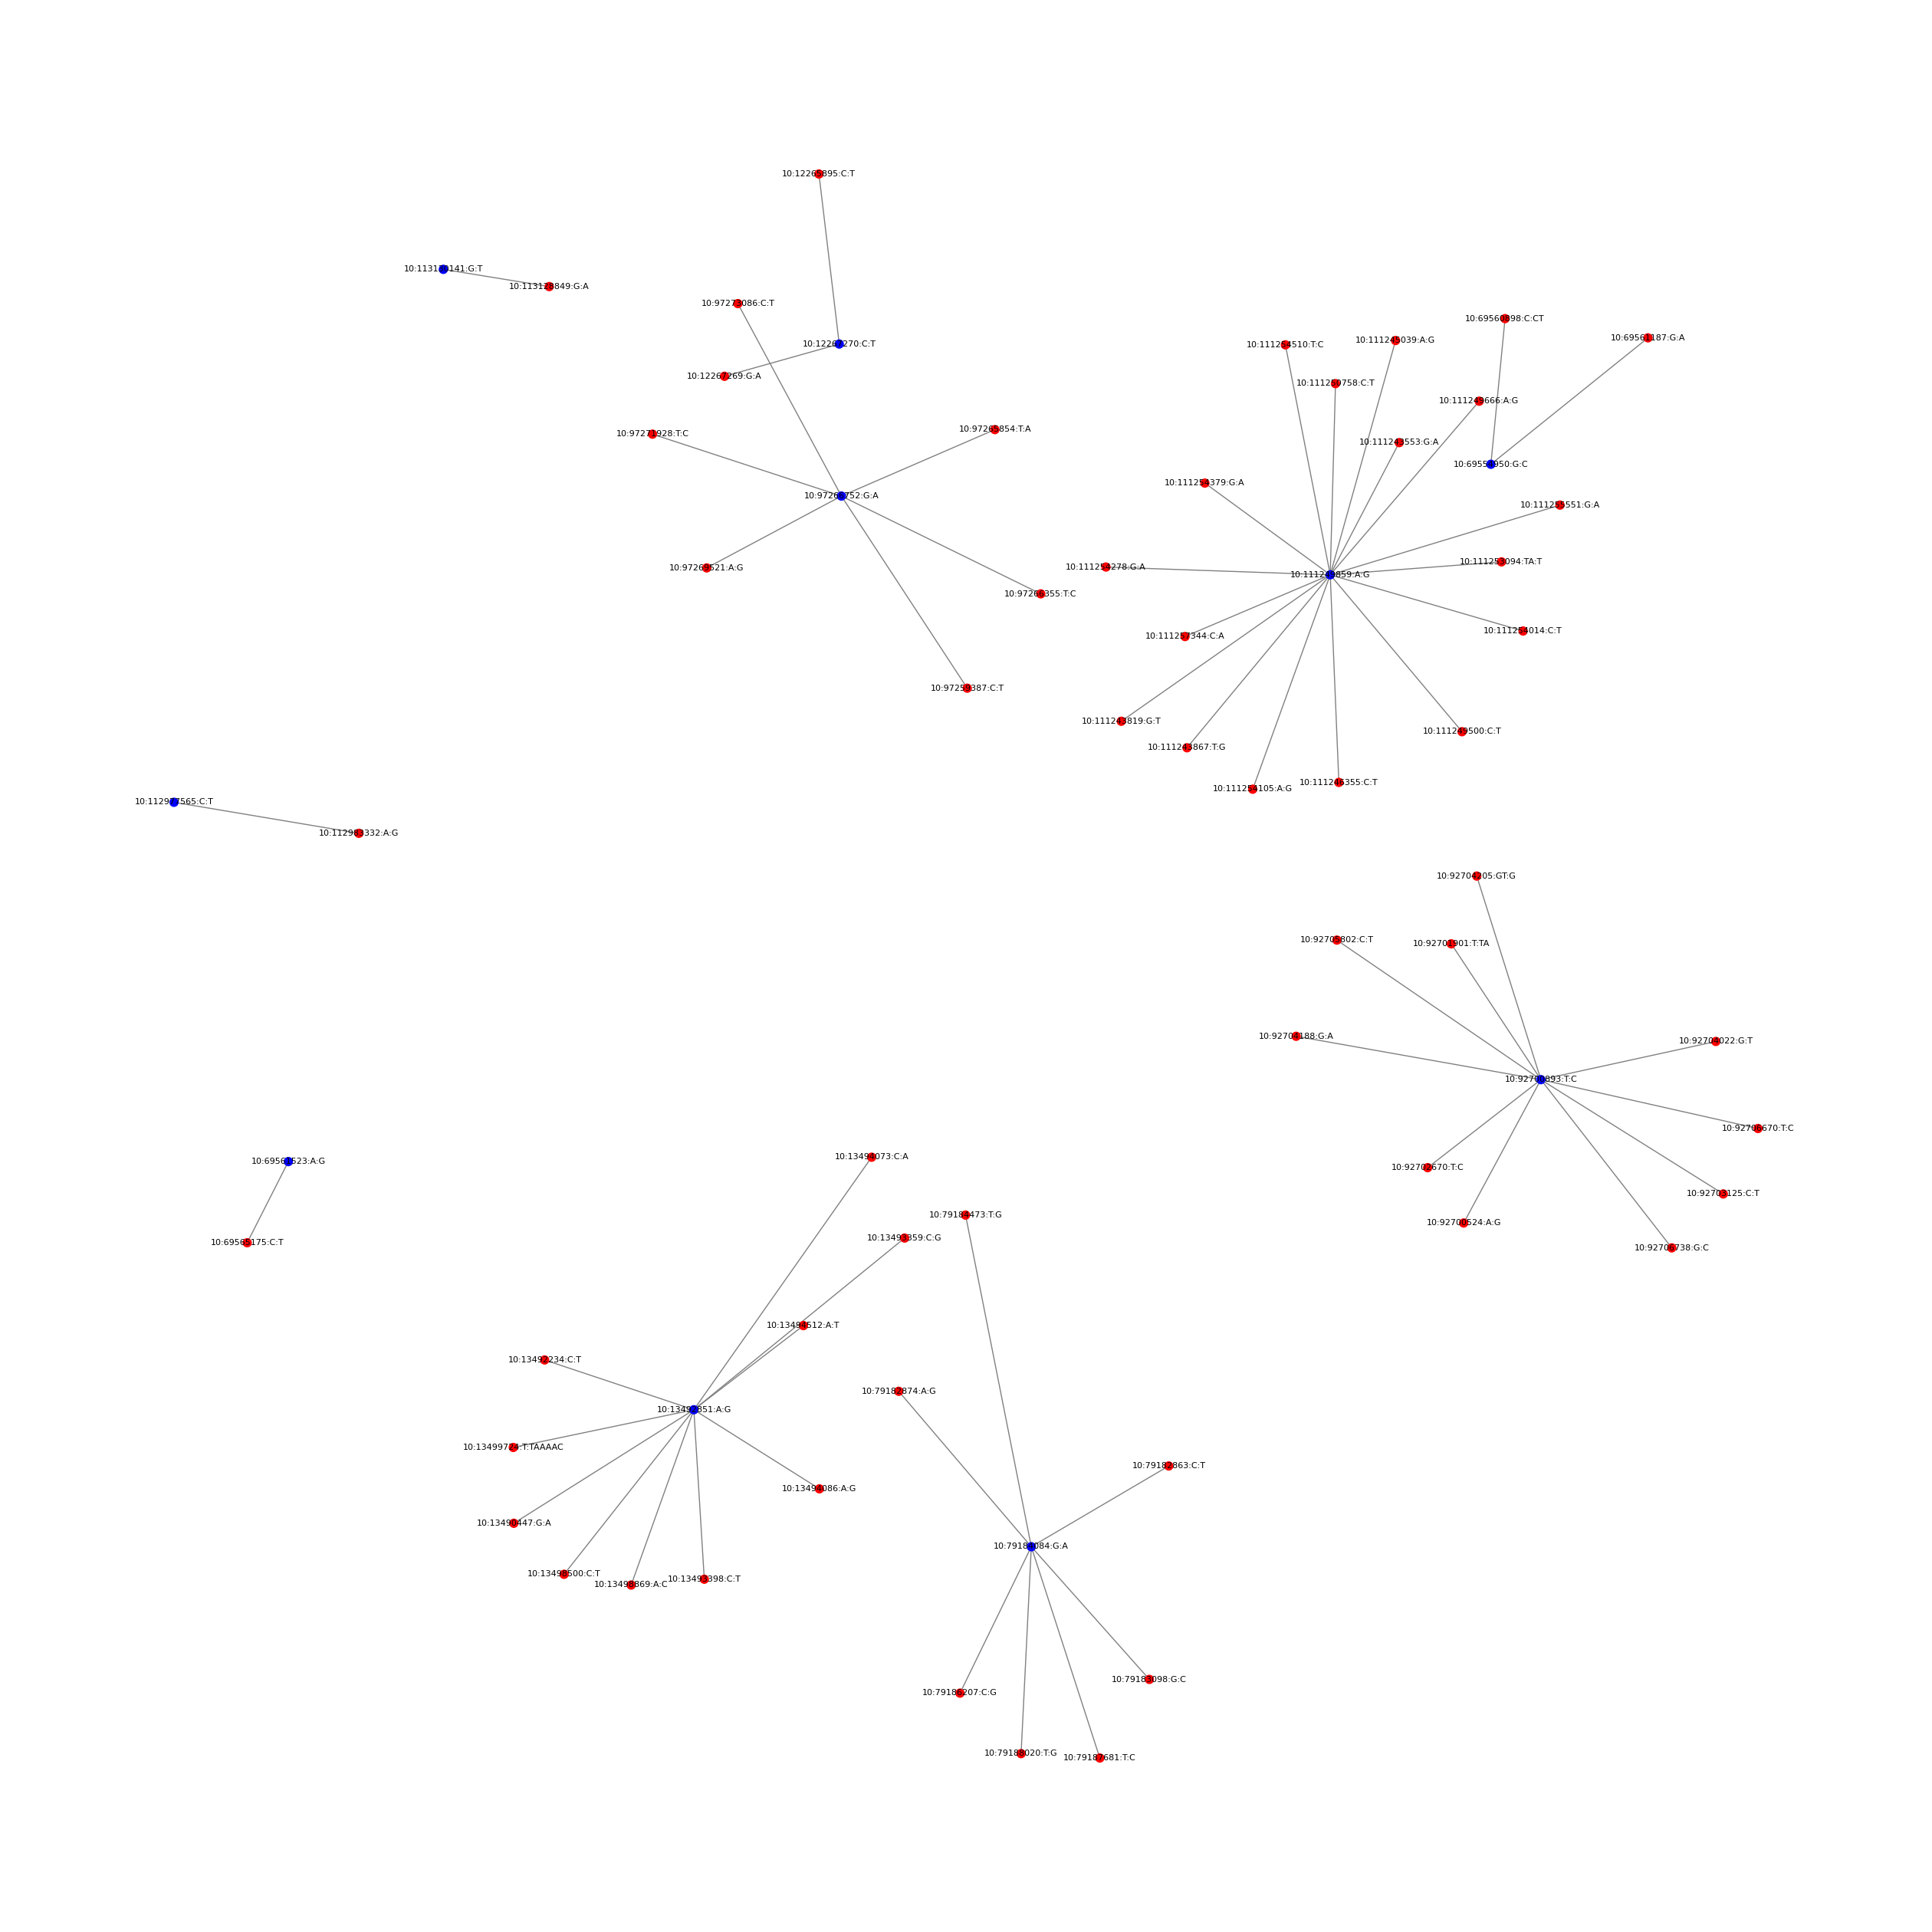

Chromosome 11


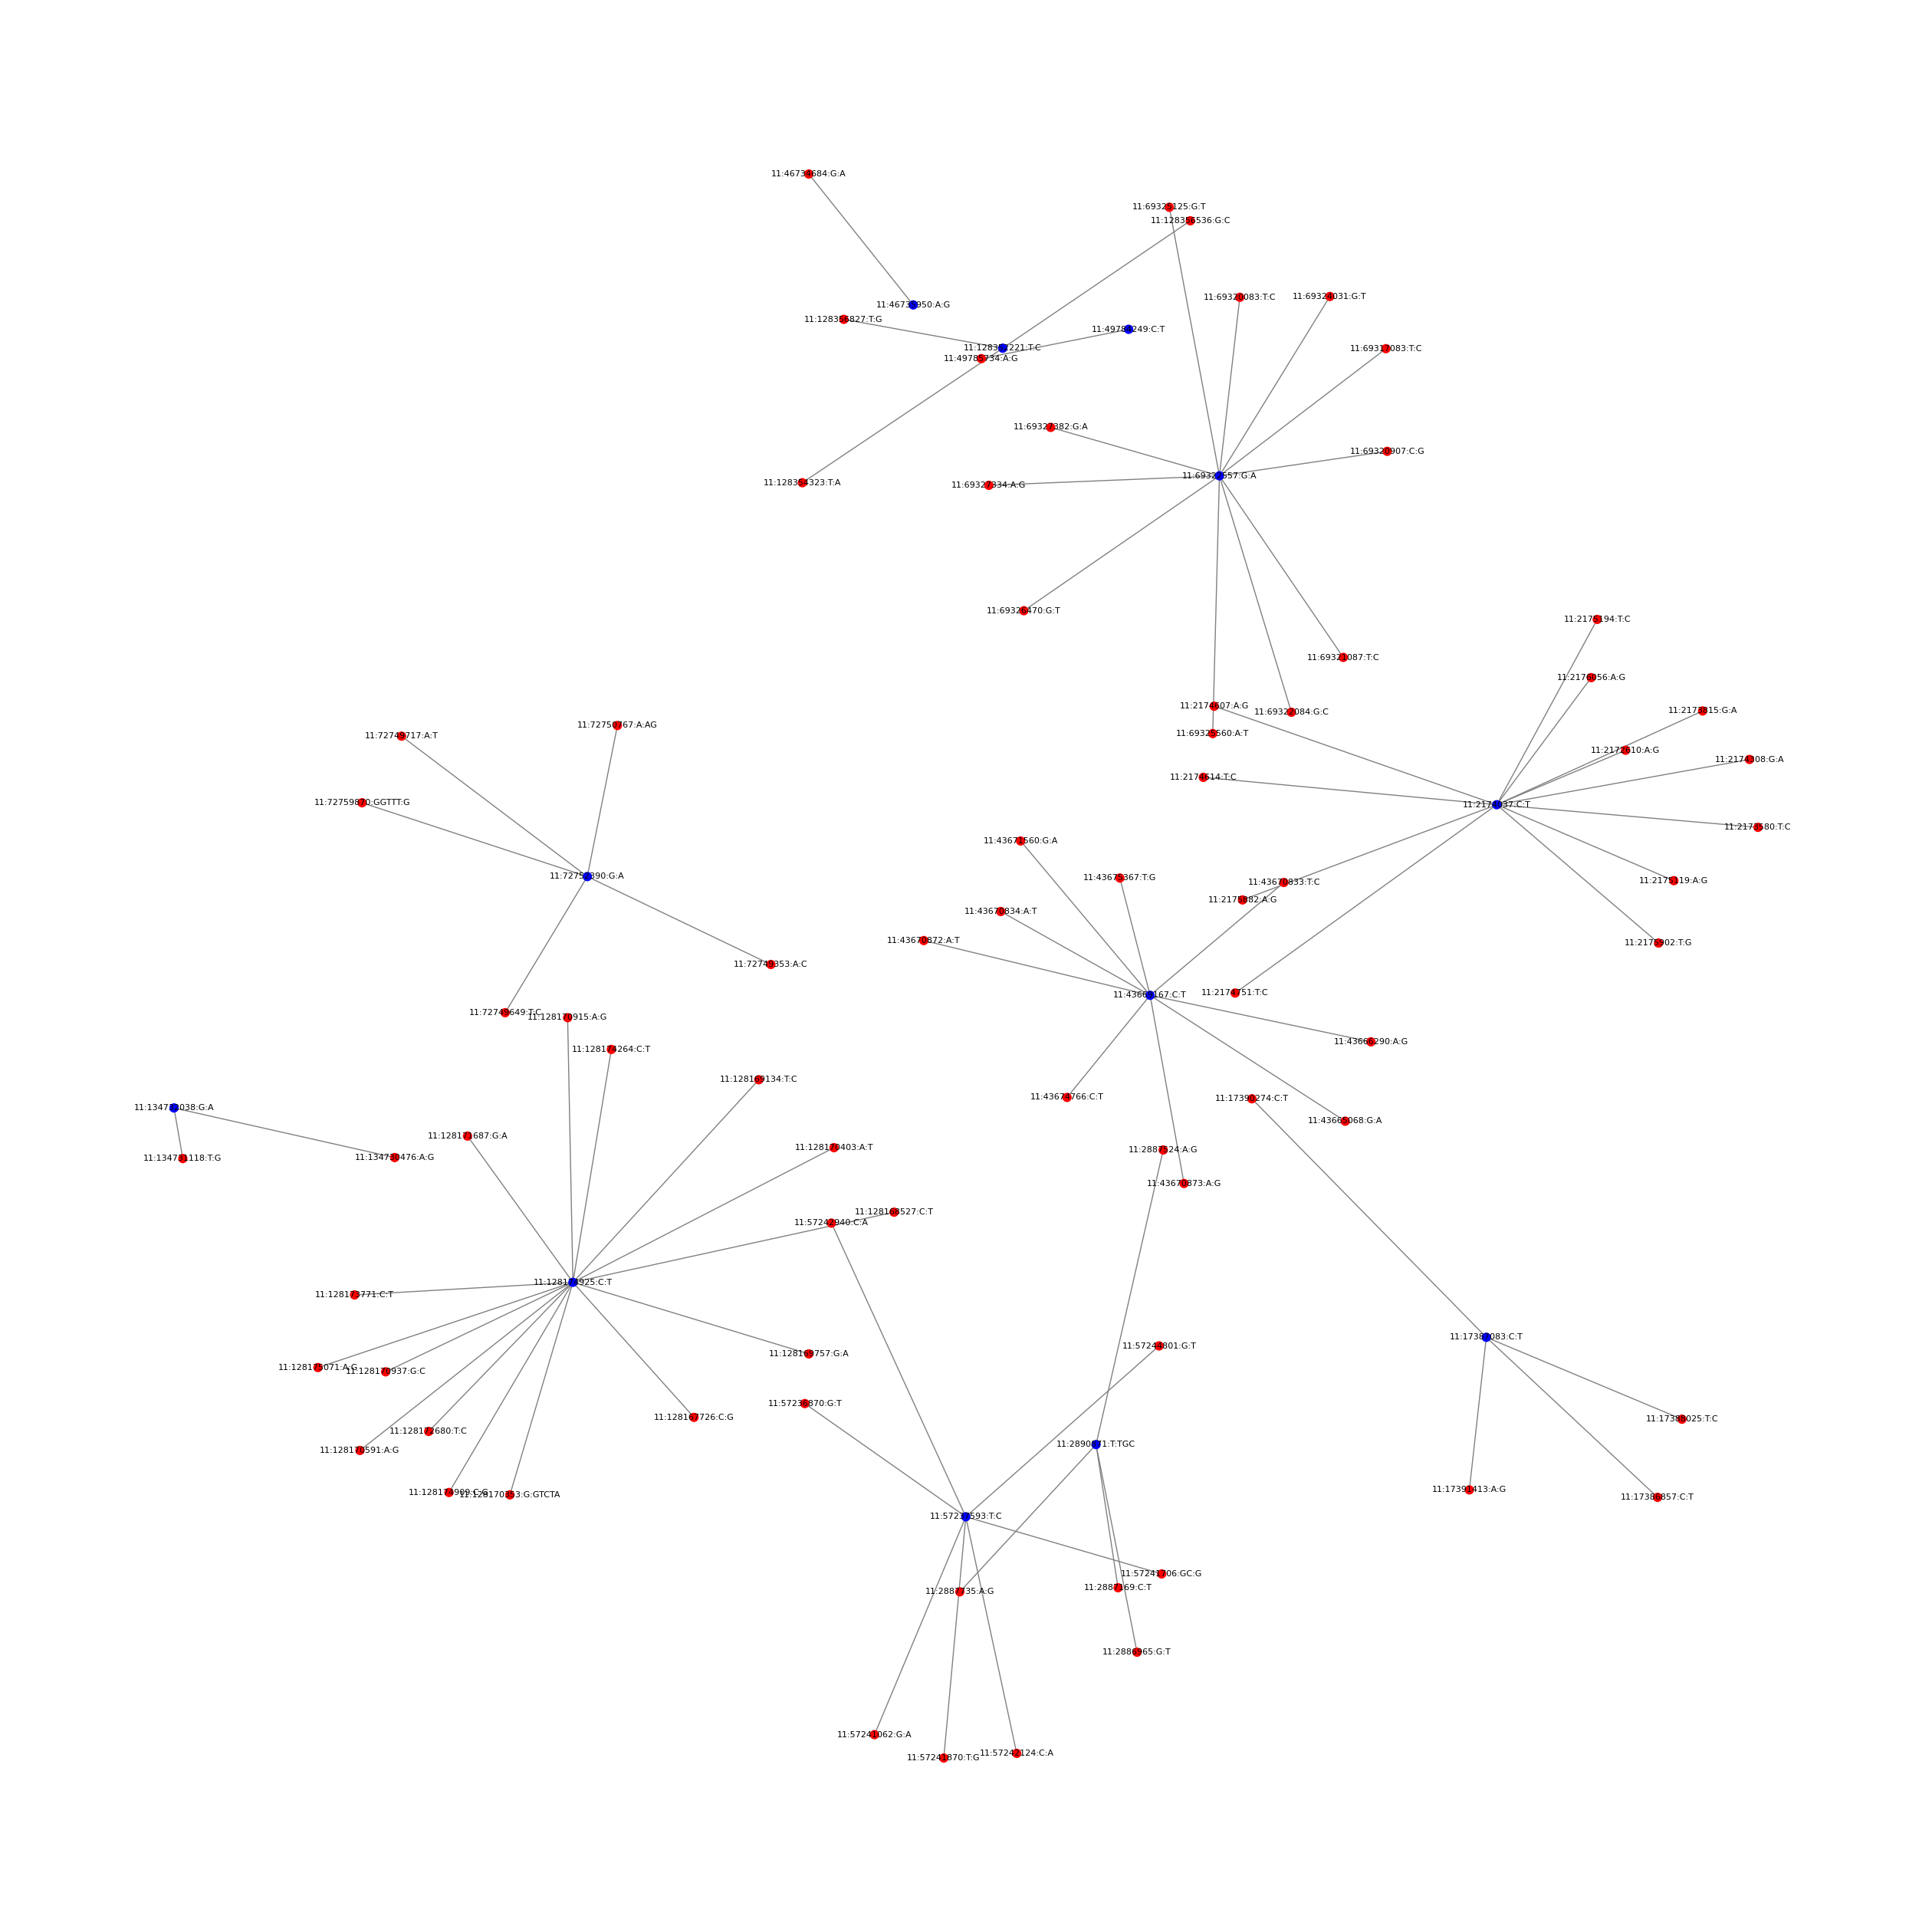

Chromosome 12


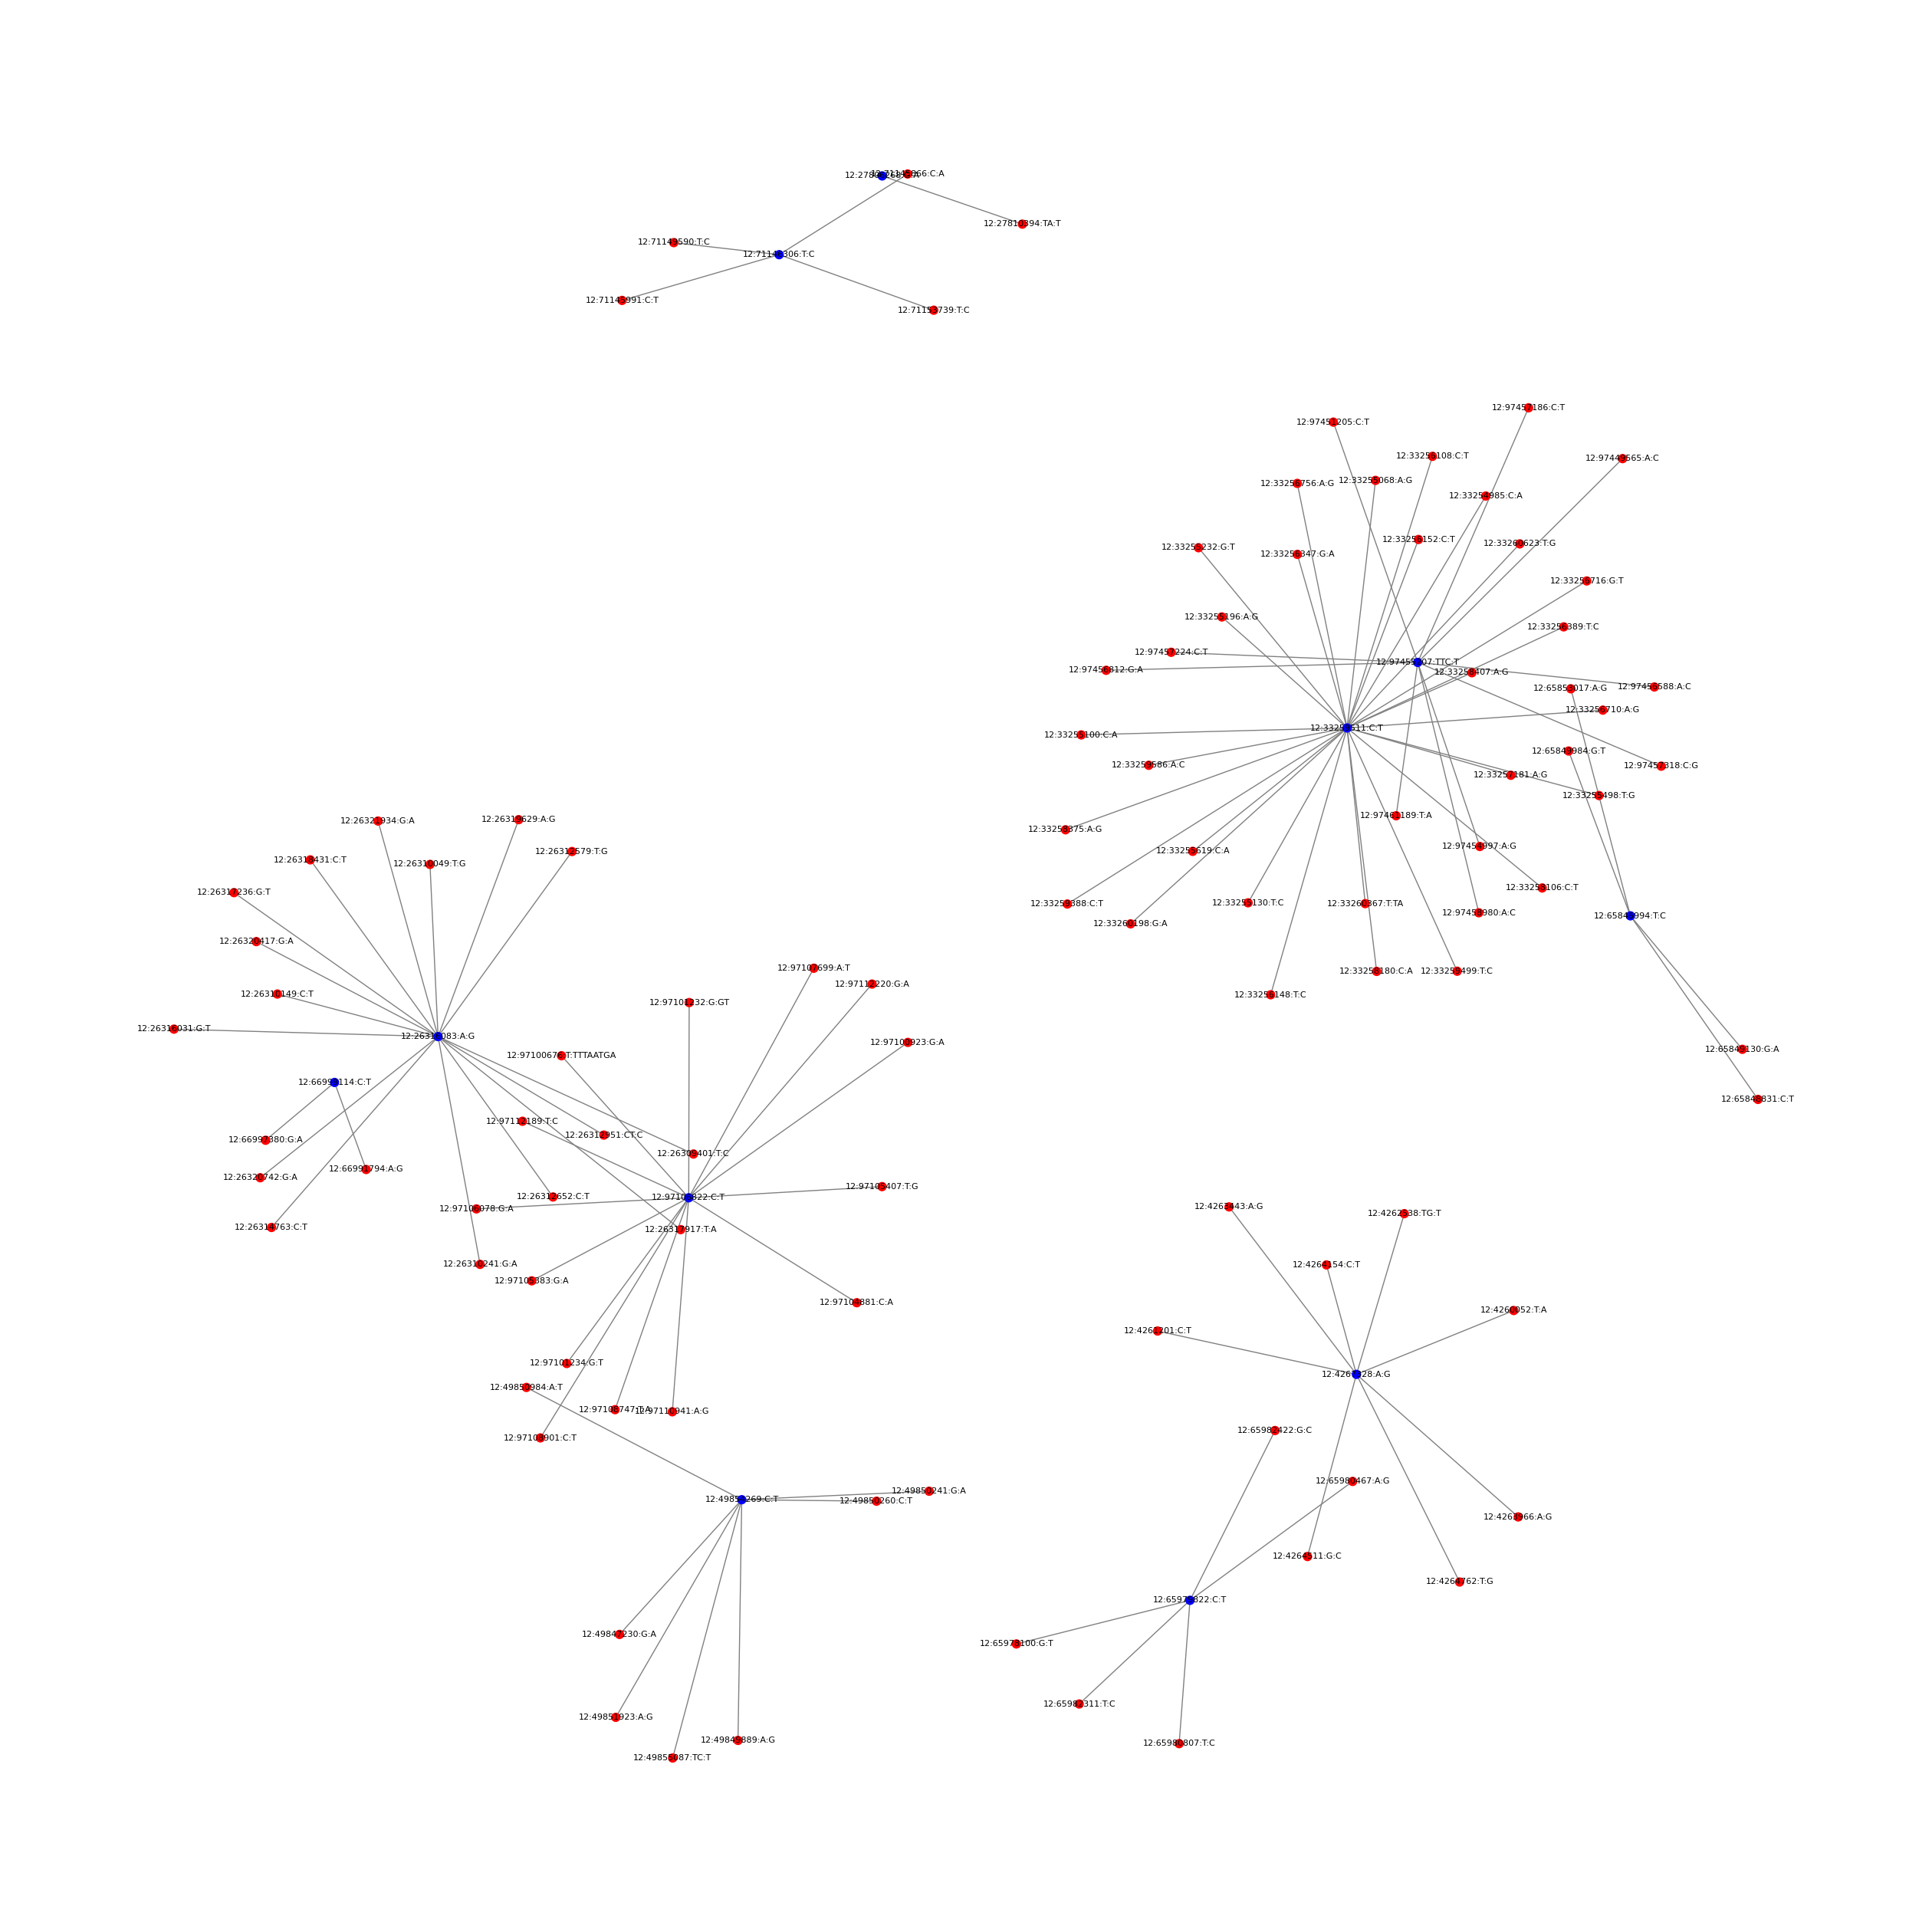

Chromosome 13


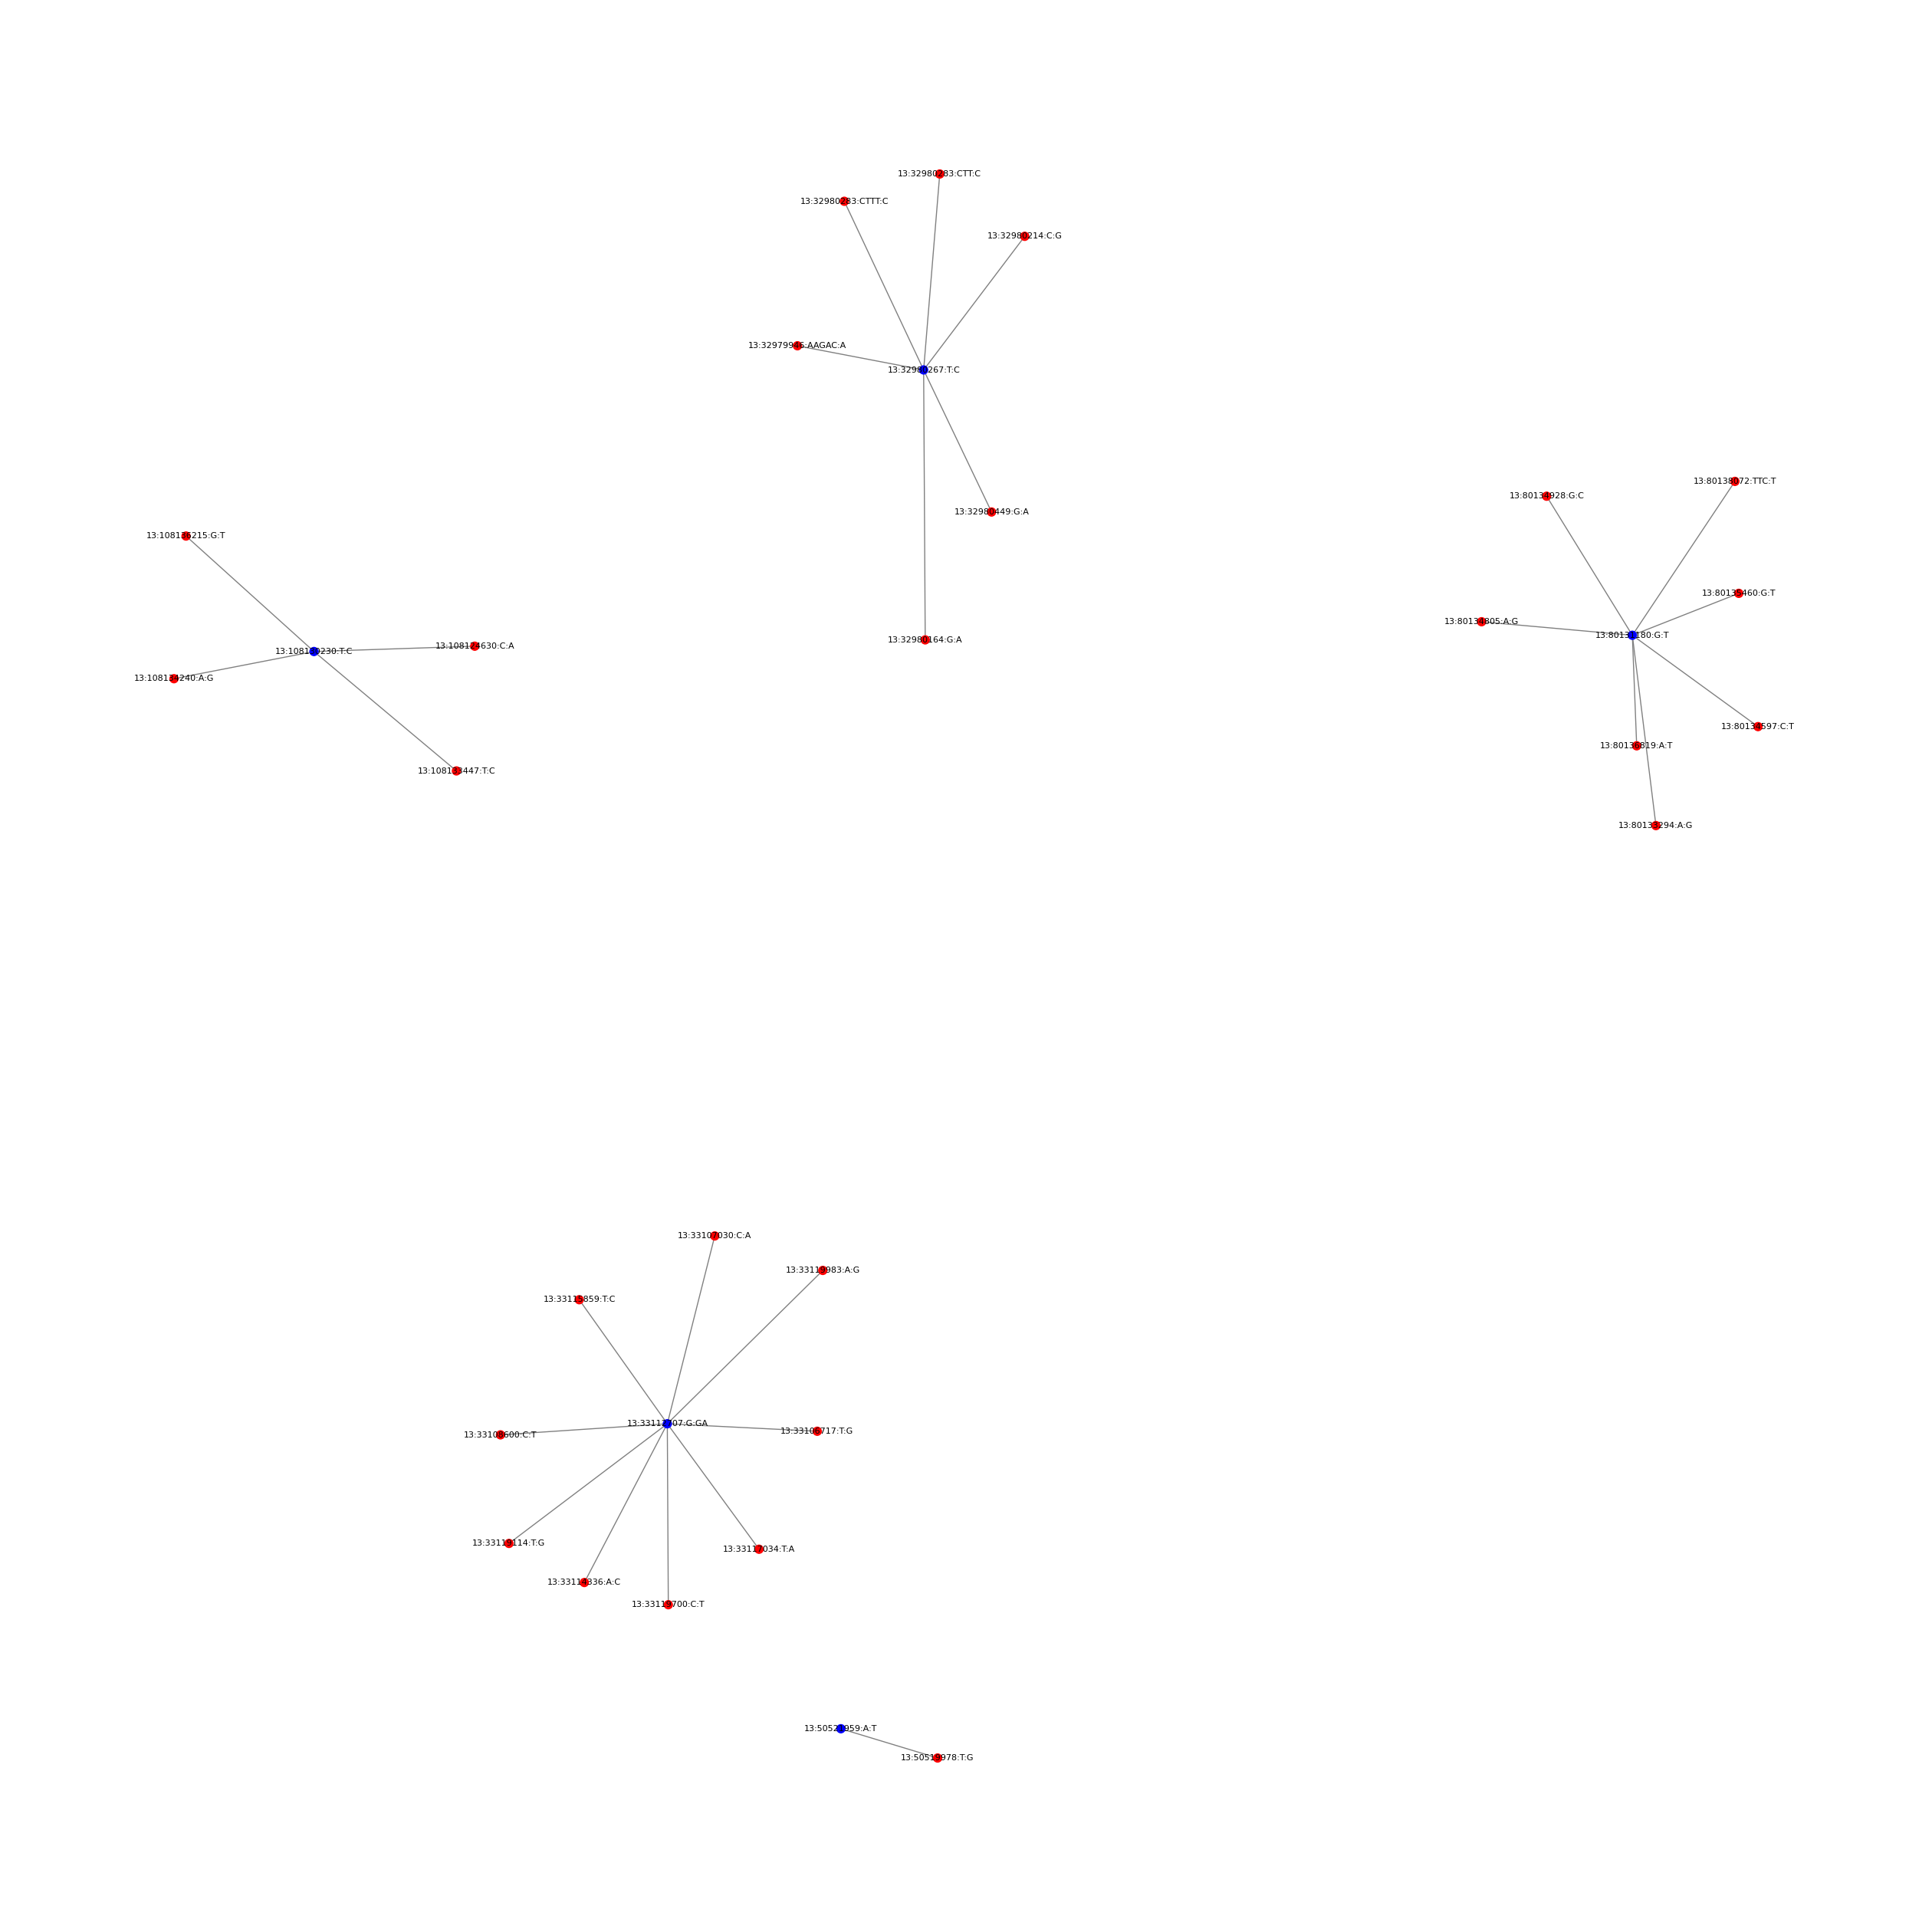

Chromosome 14


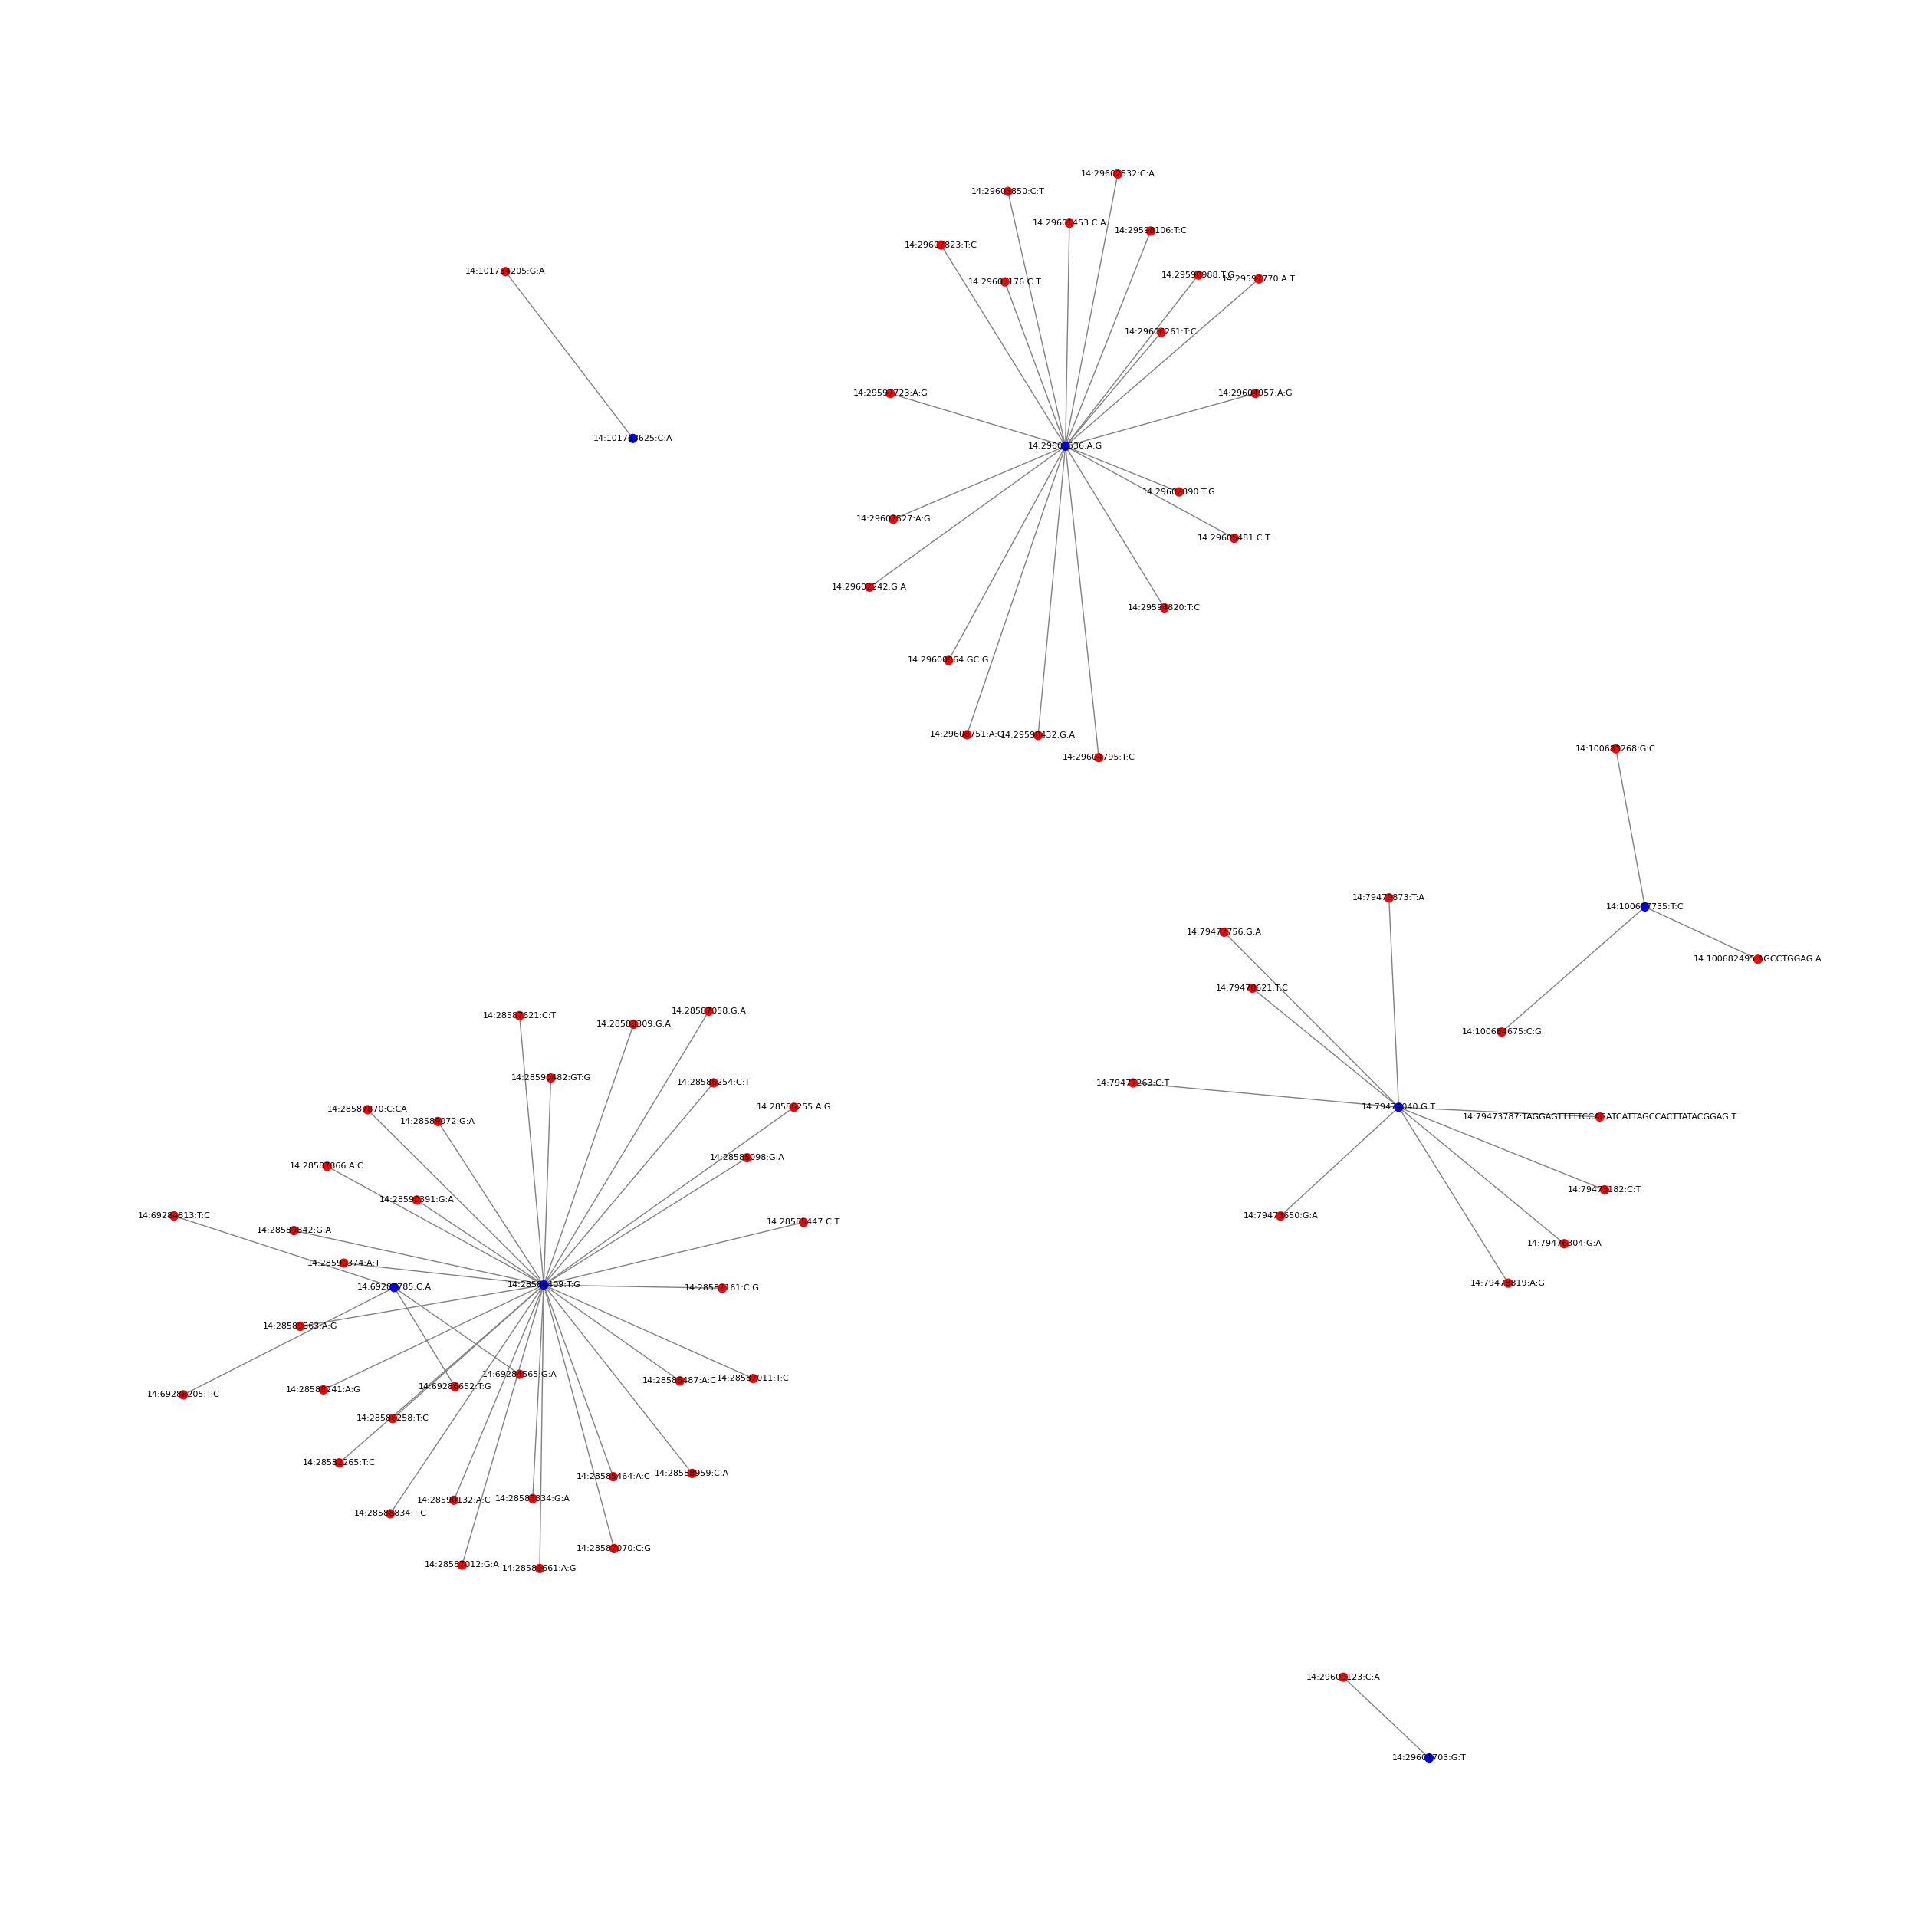

Chromosome 15


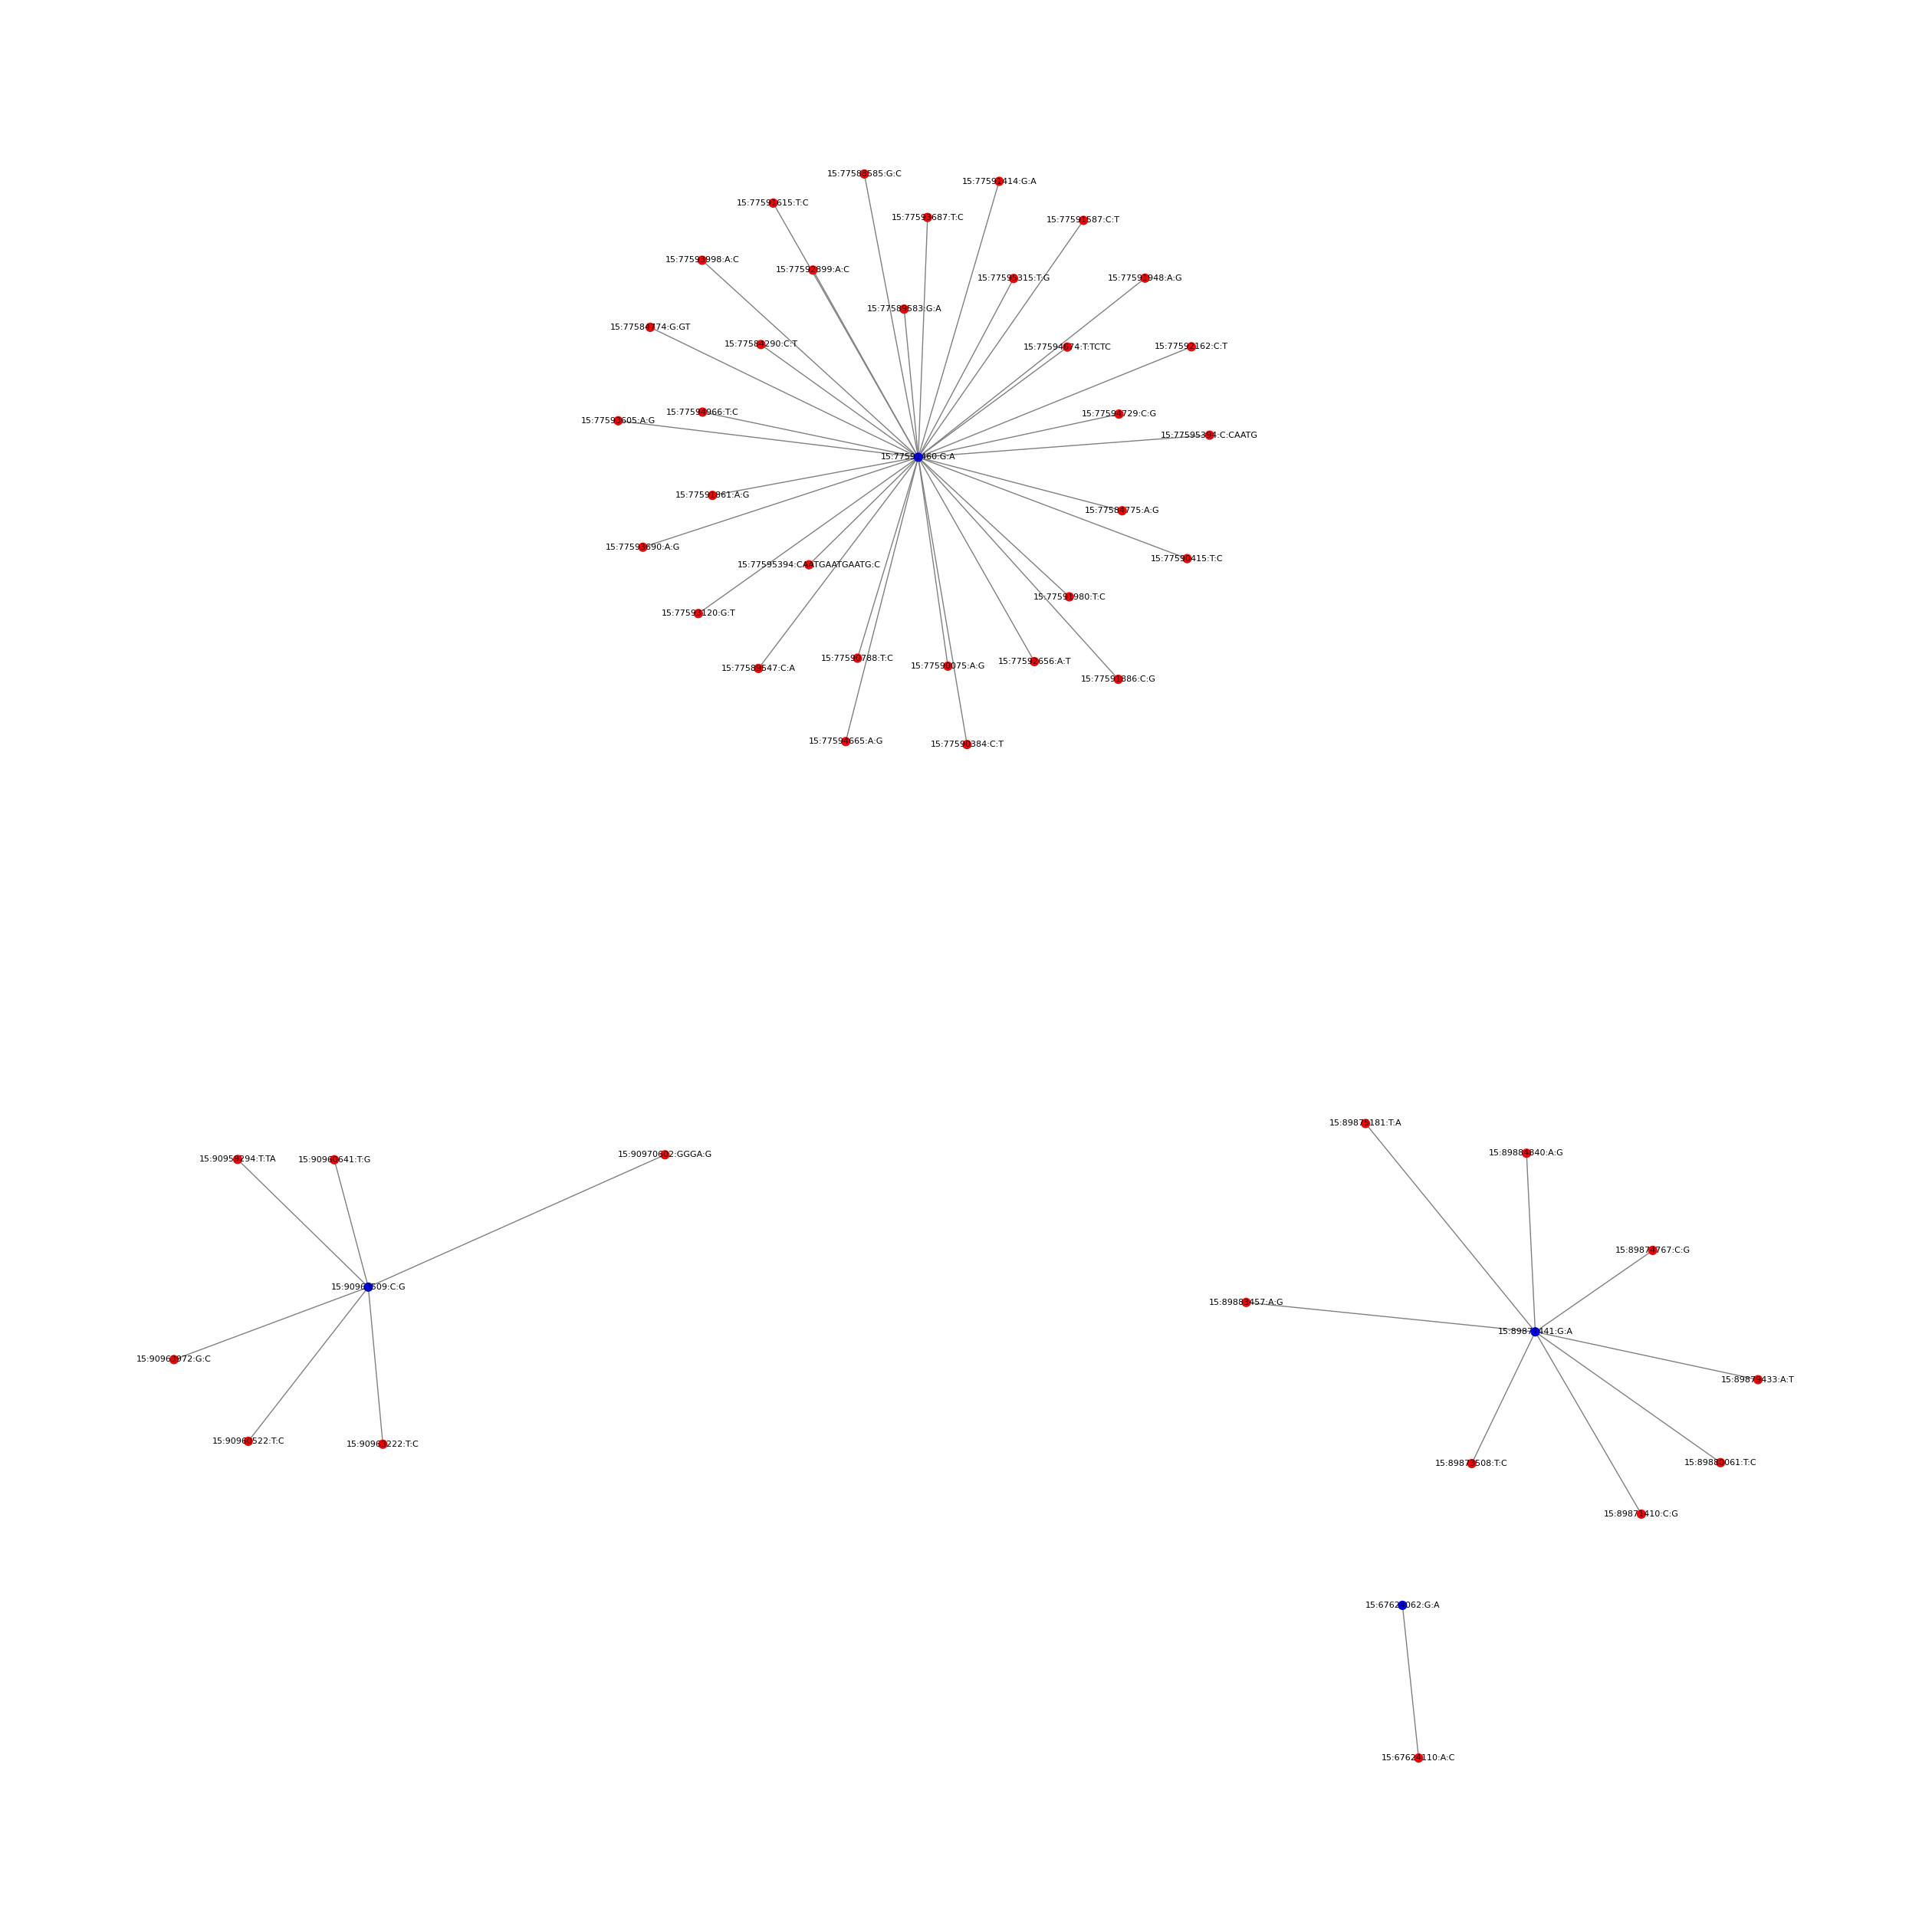

Chromosome 16


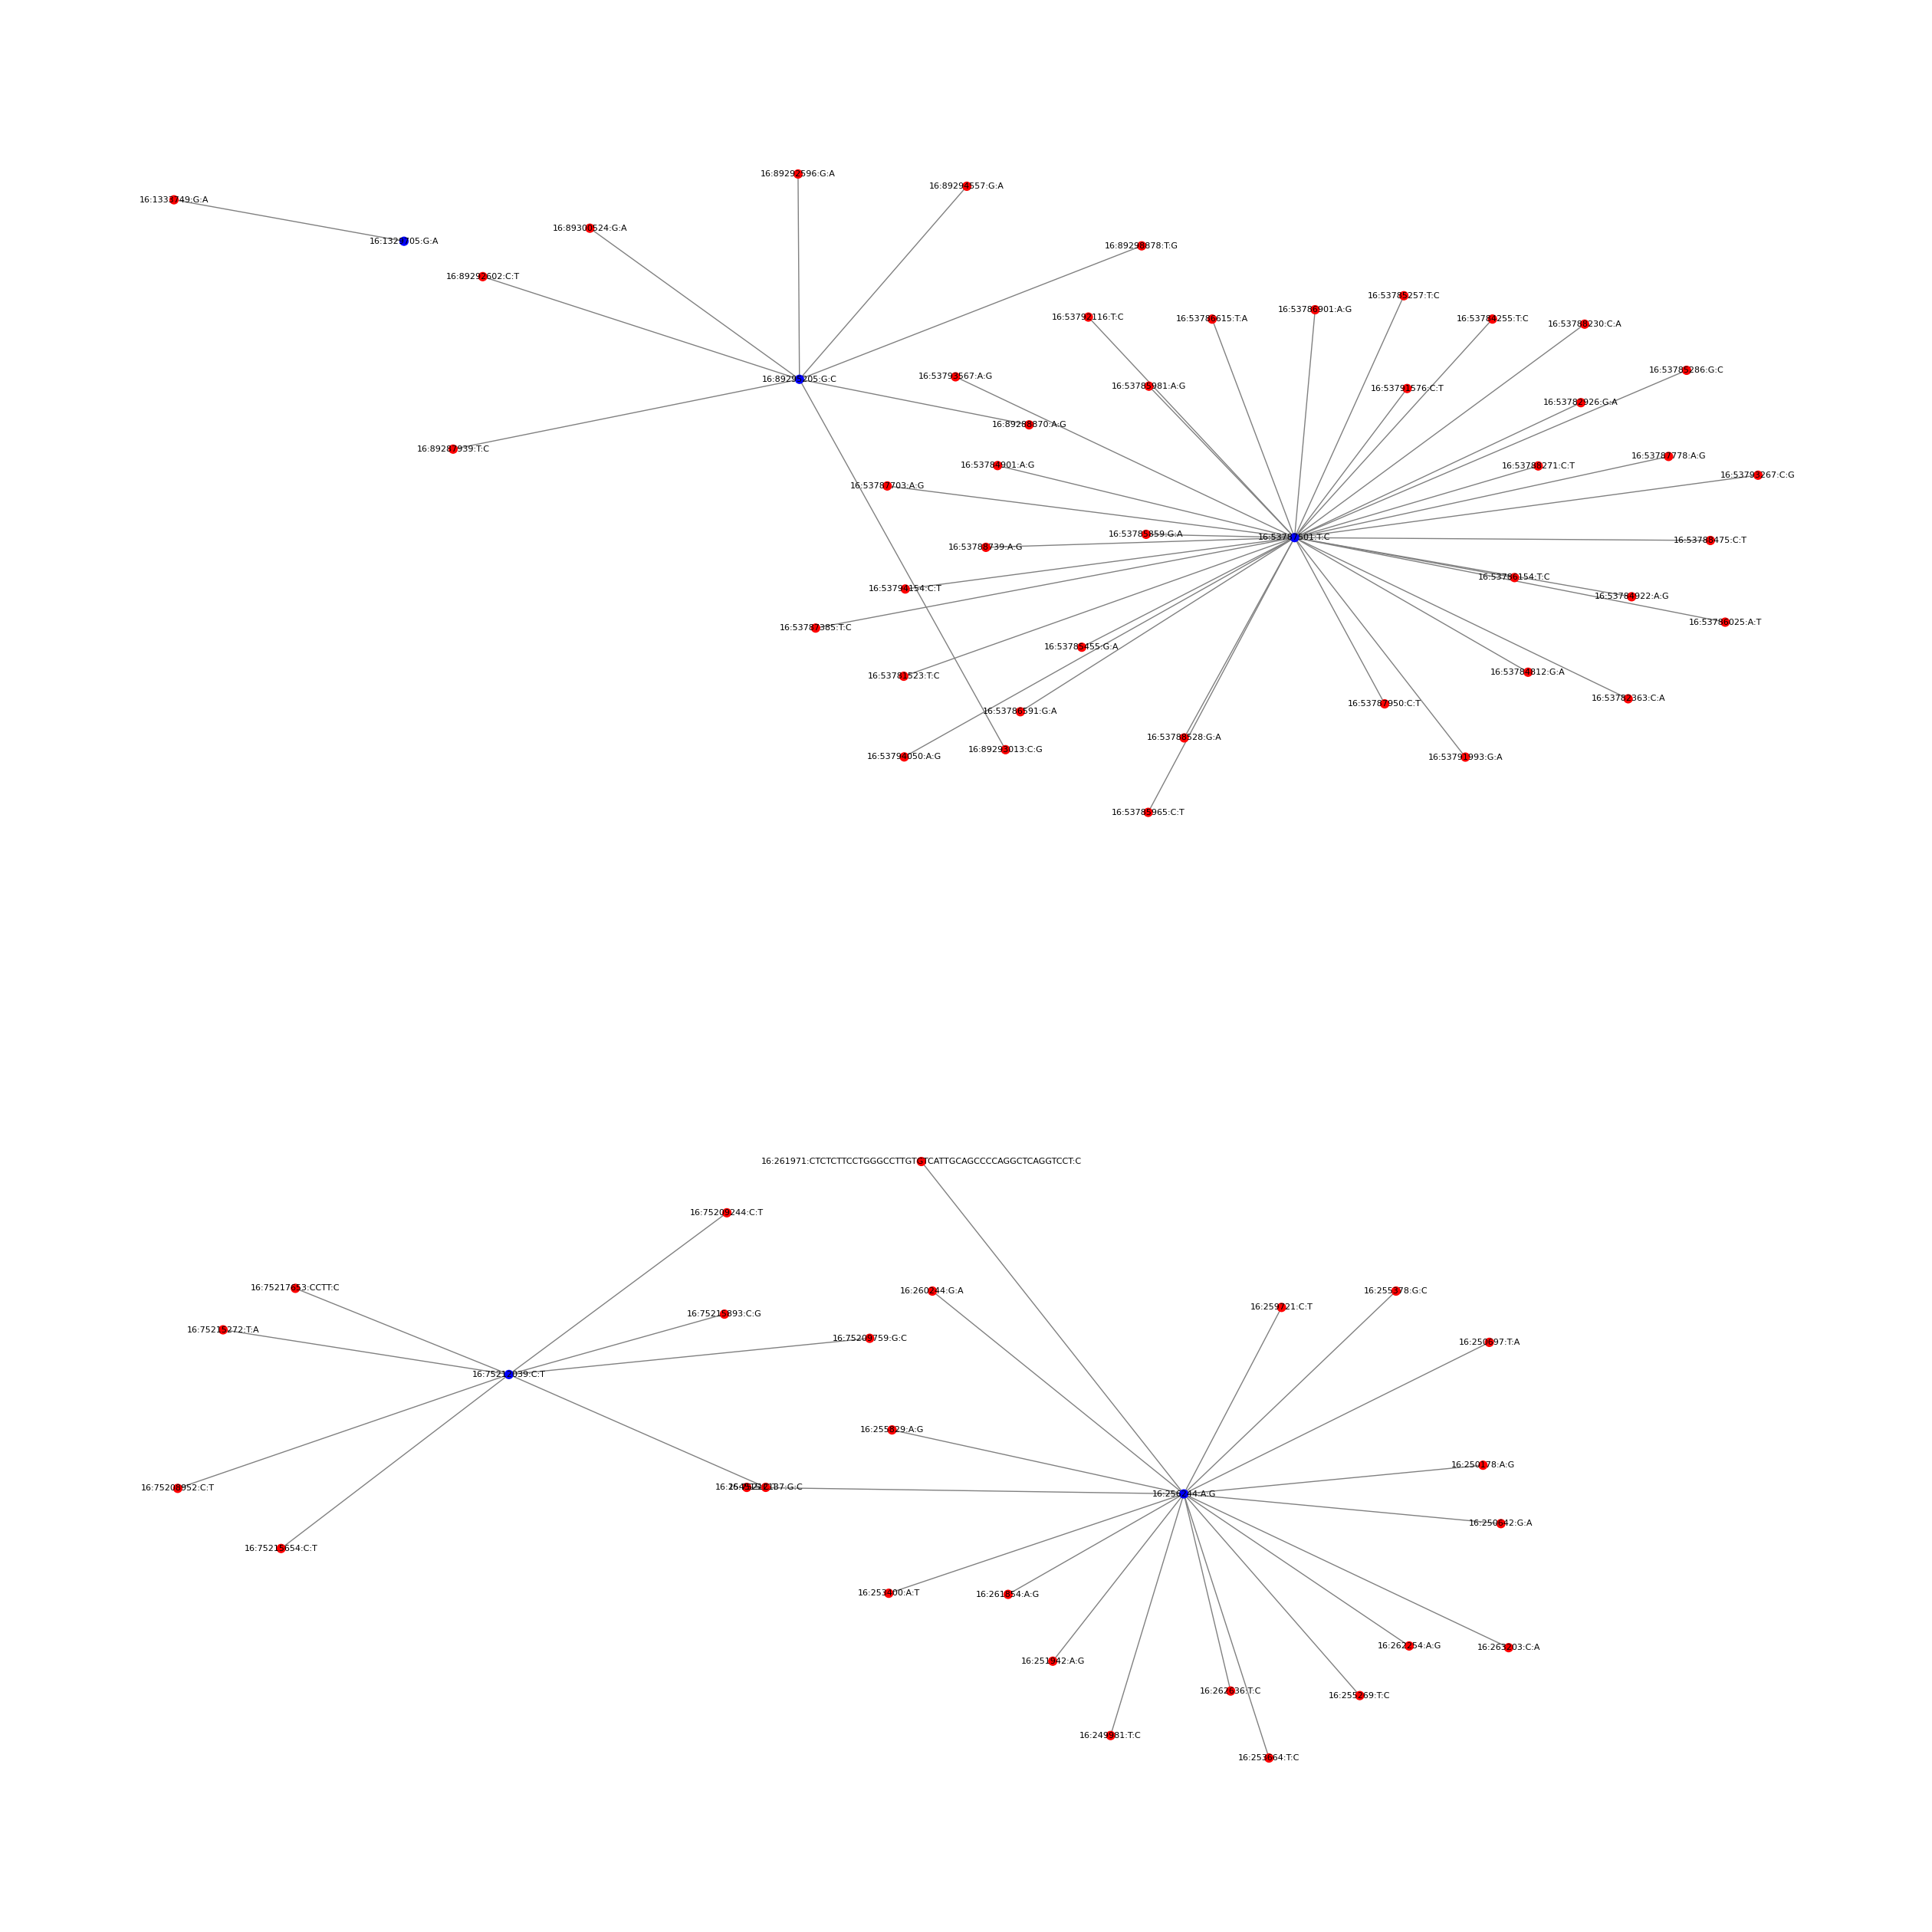

Chromosome 17


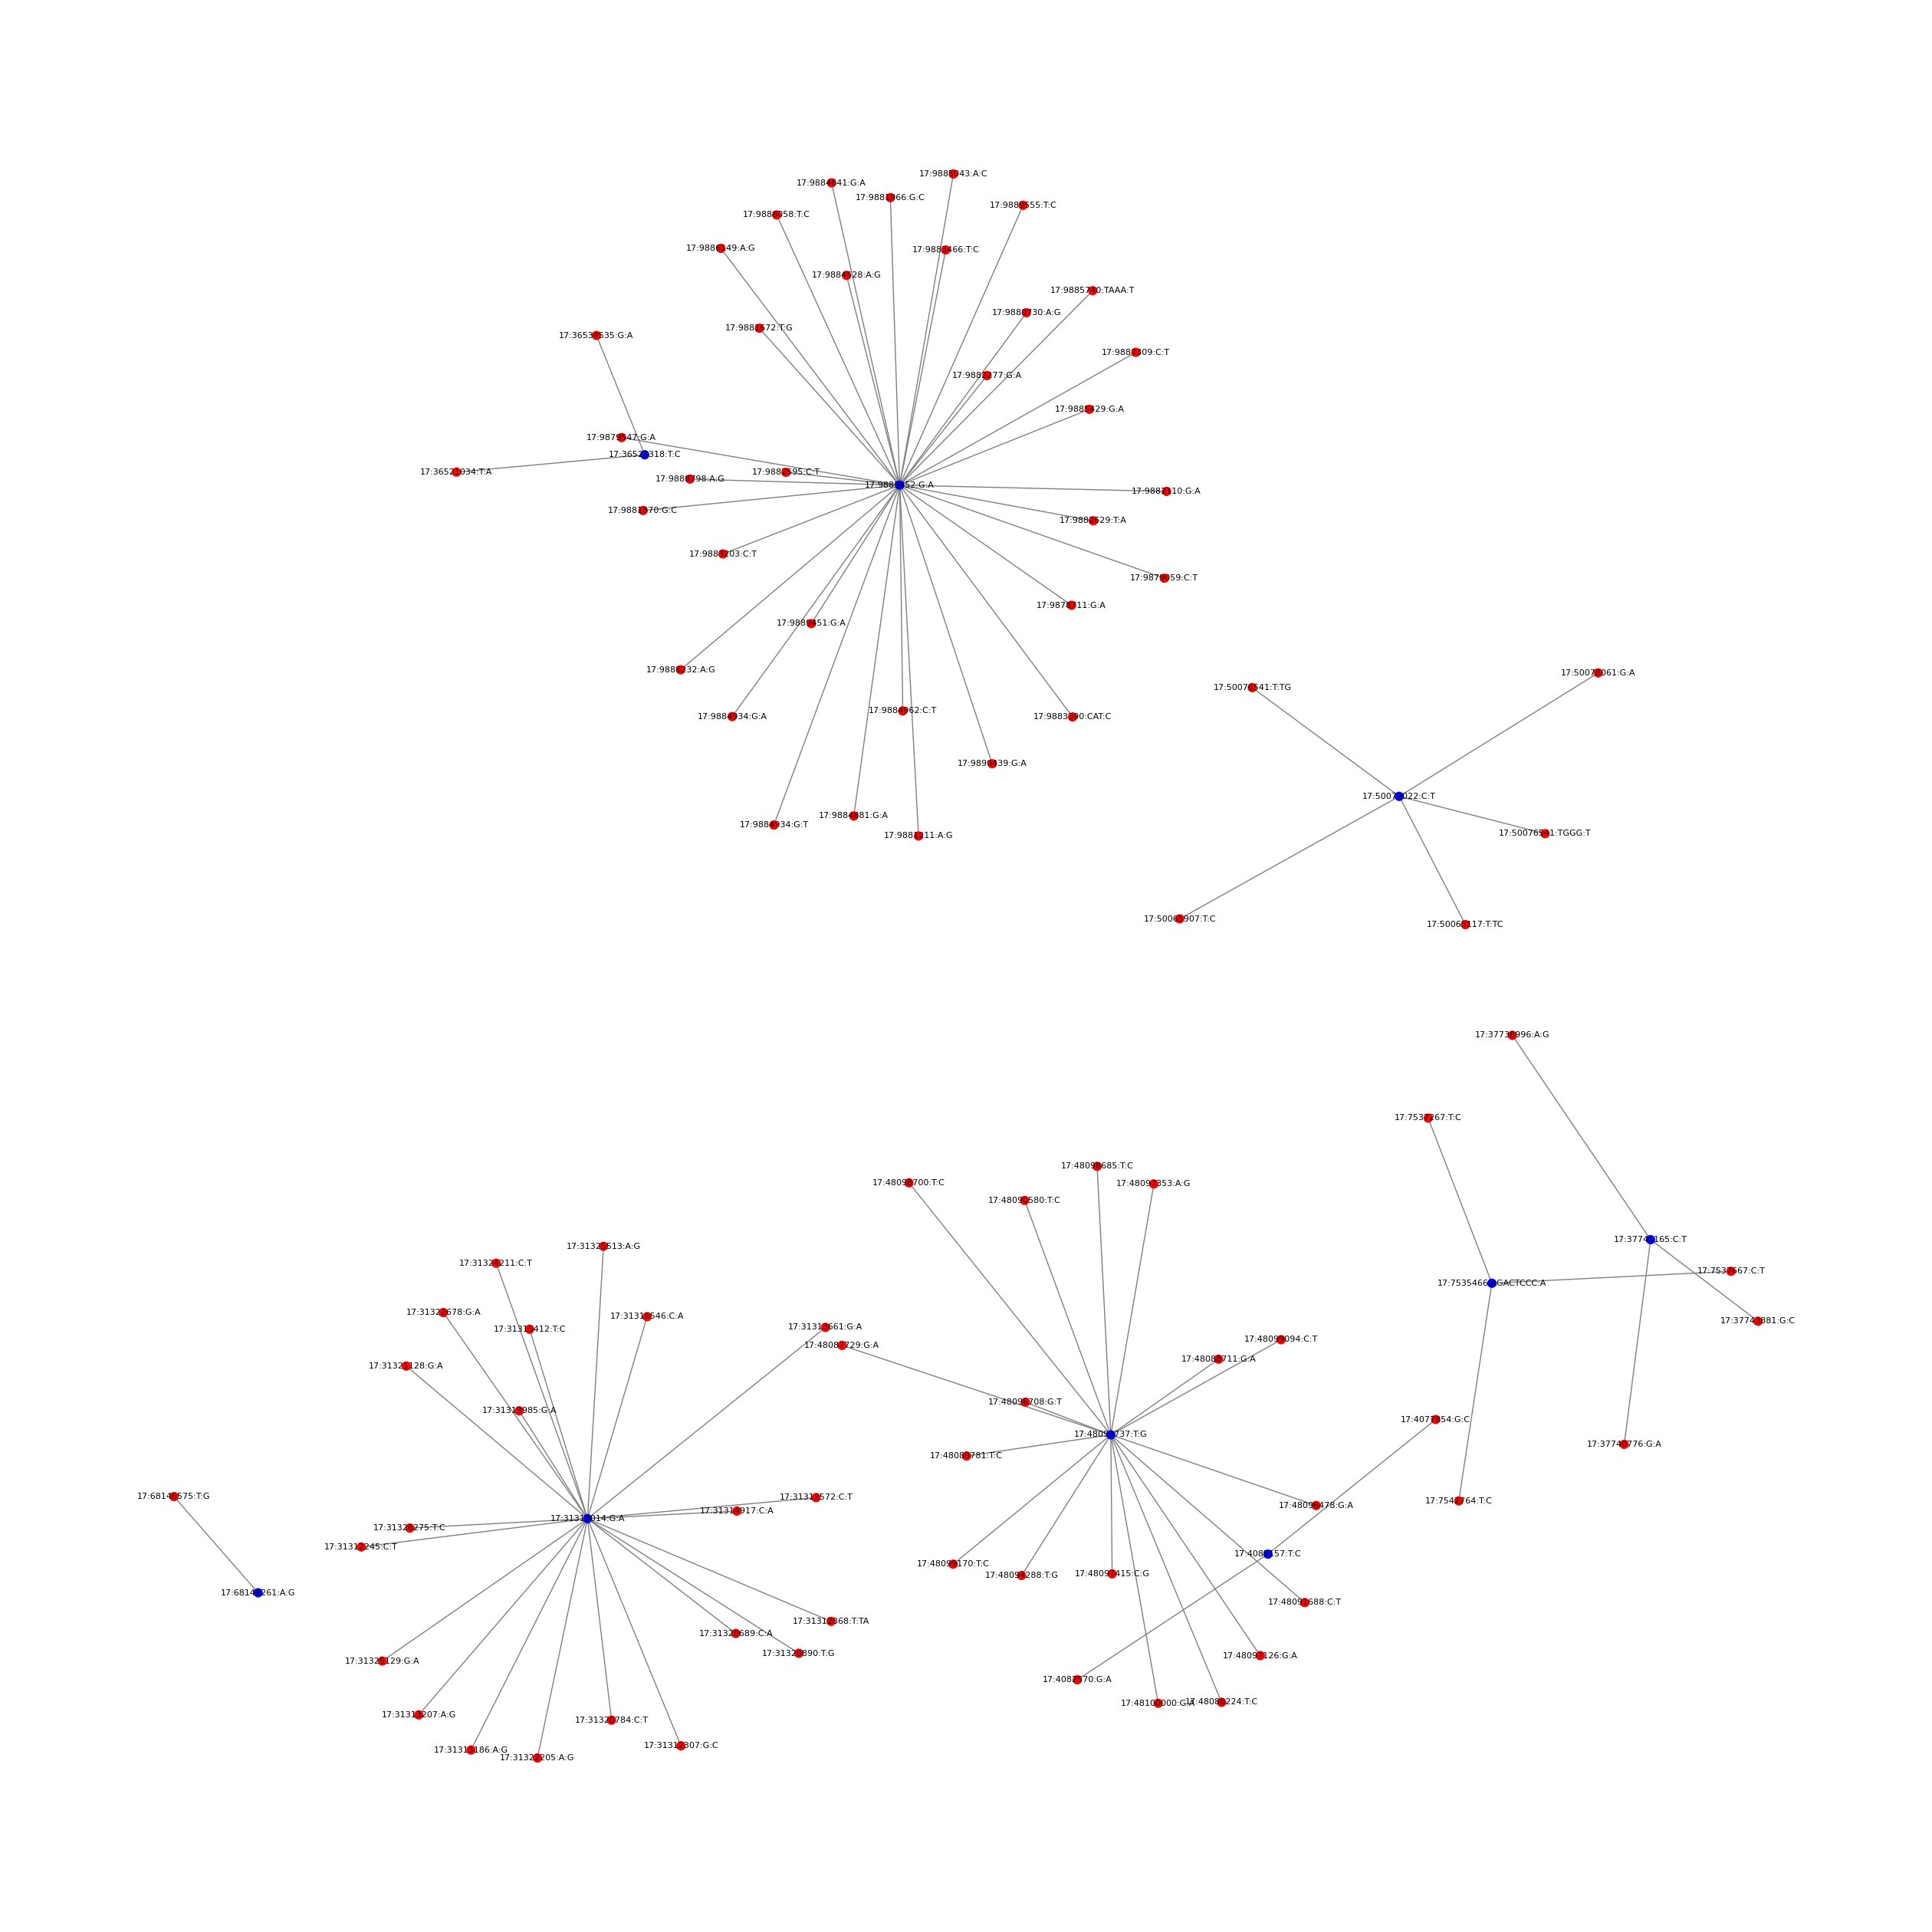

Chromosome 18


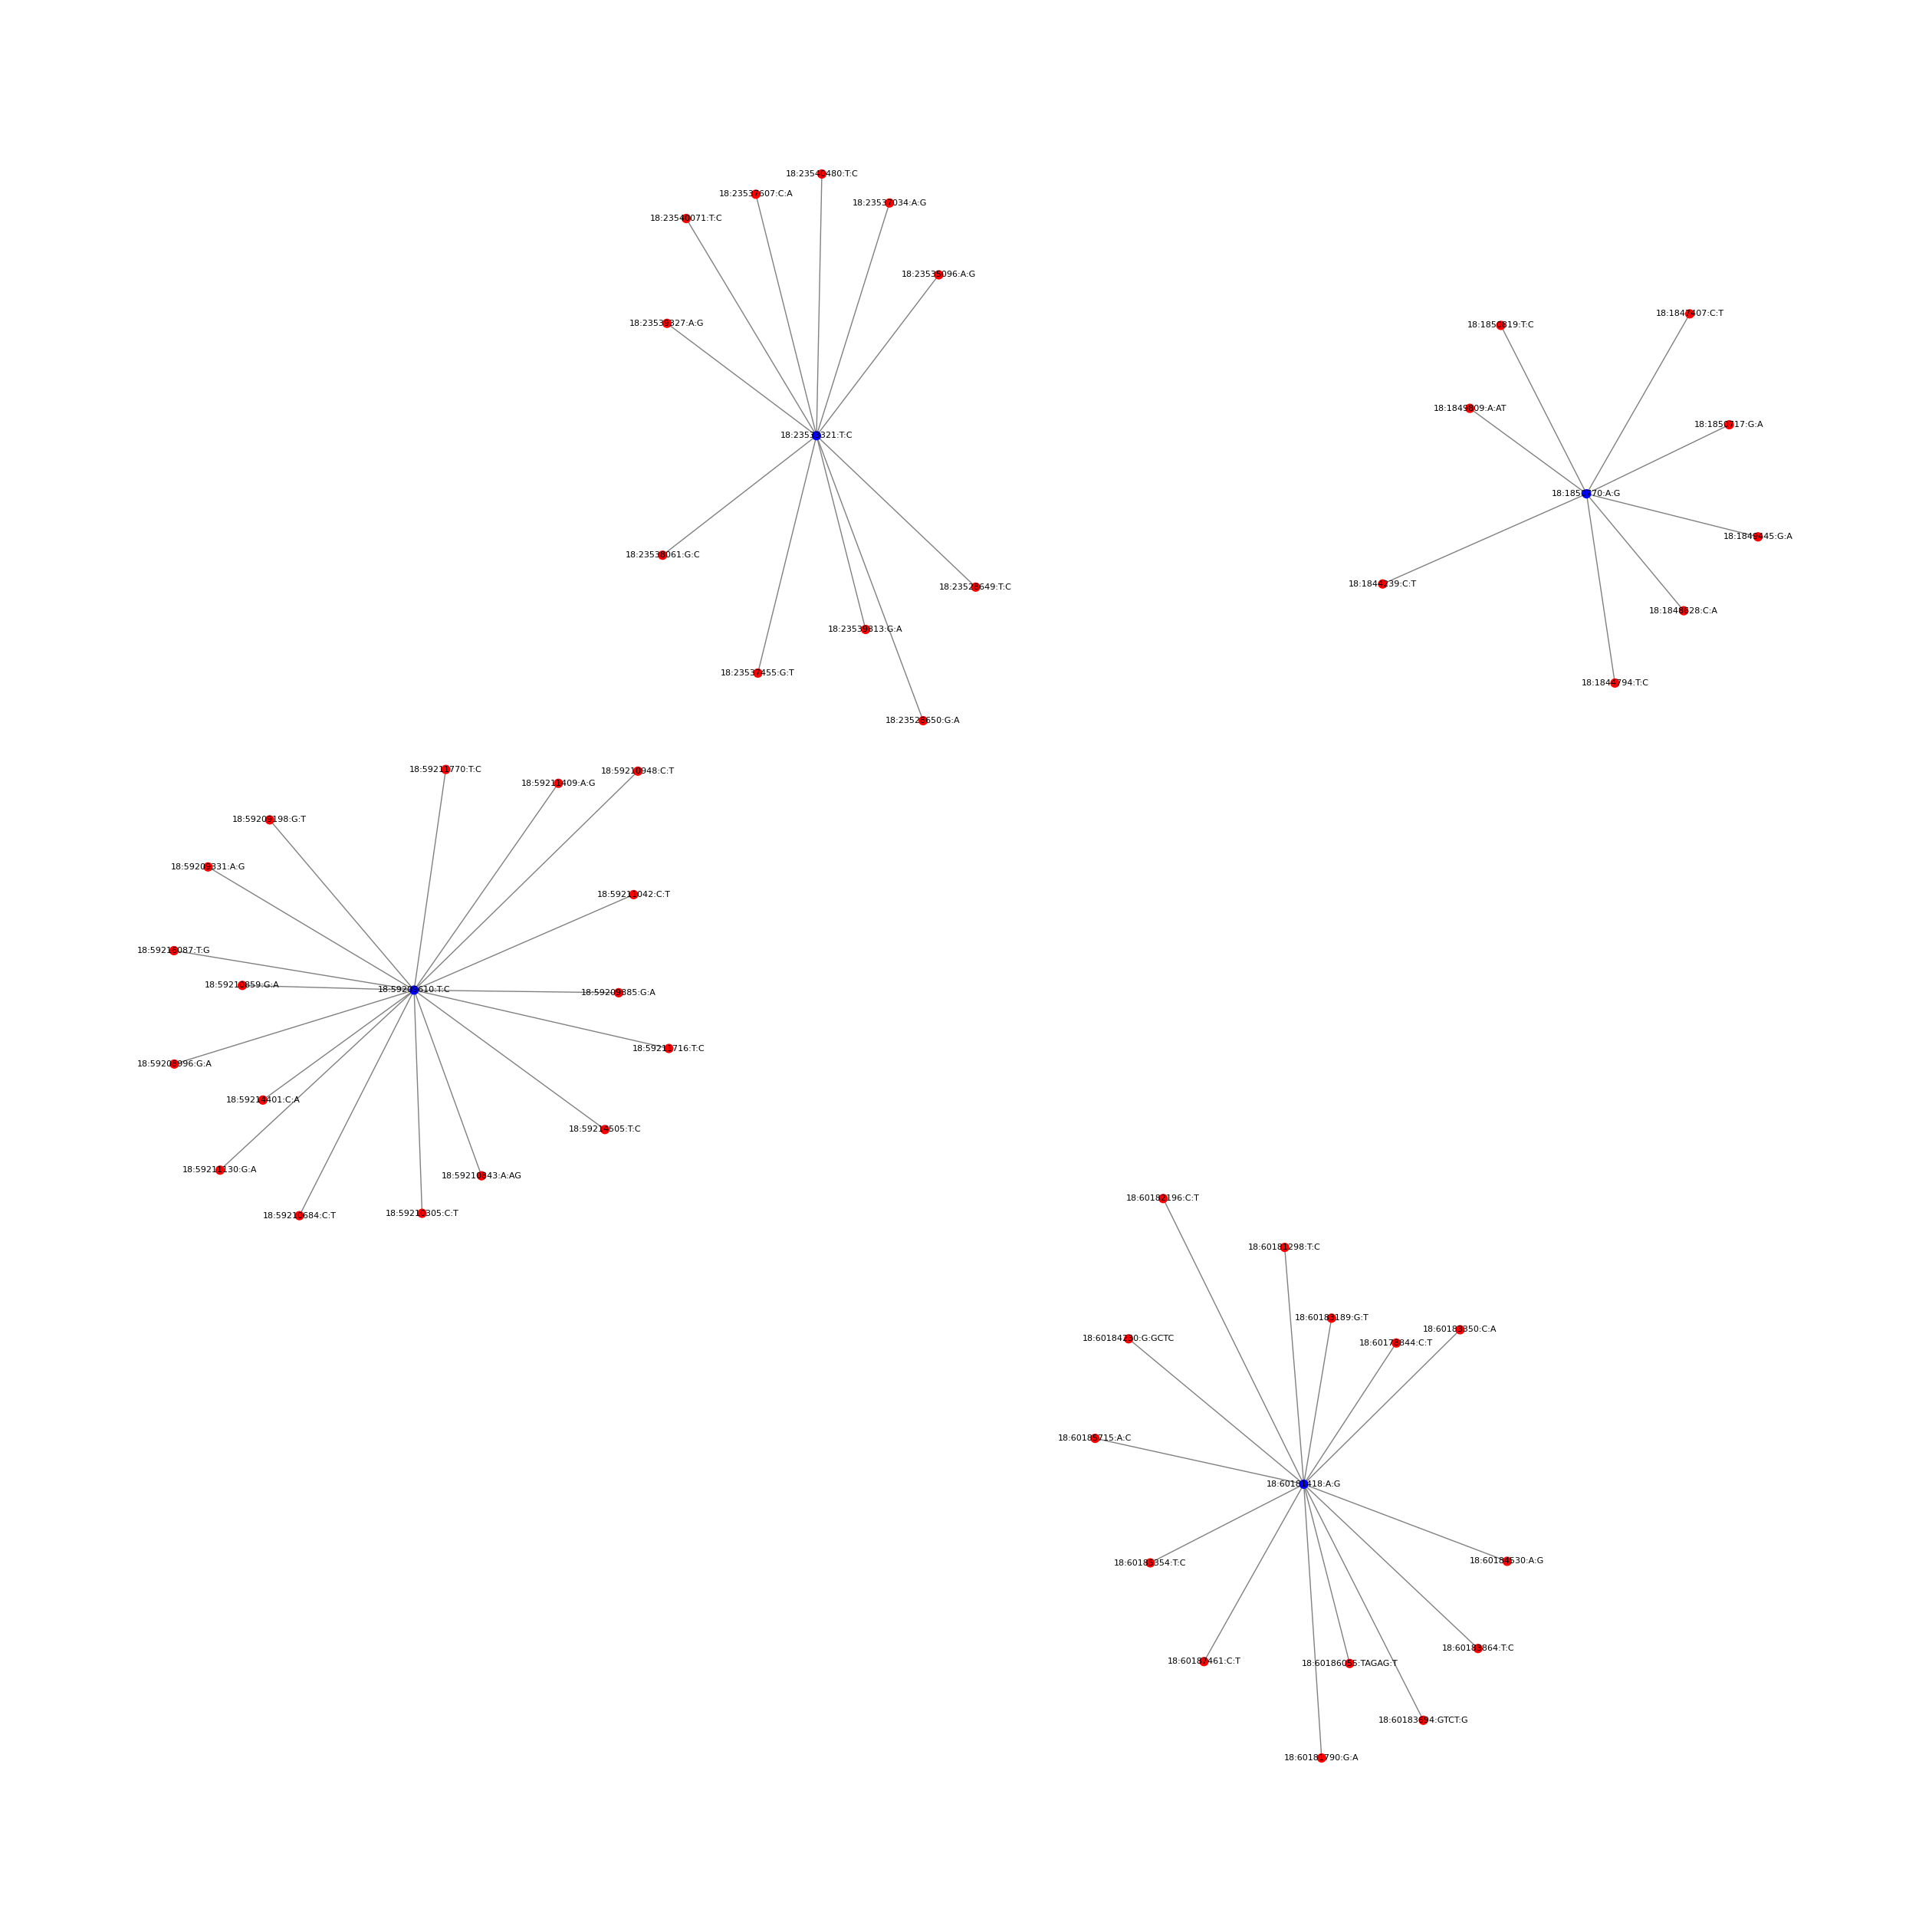

Chromosome 19


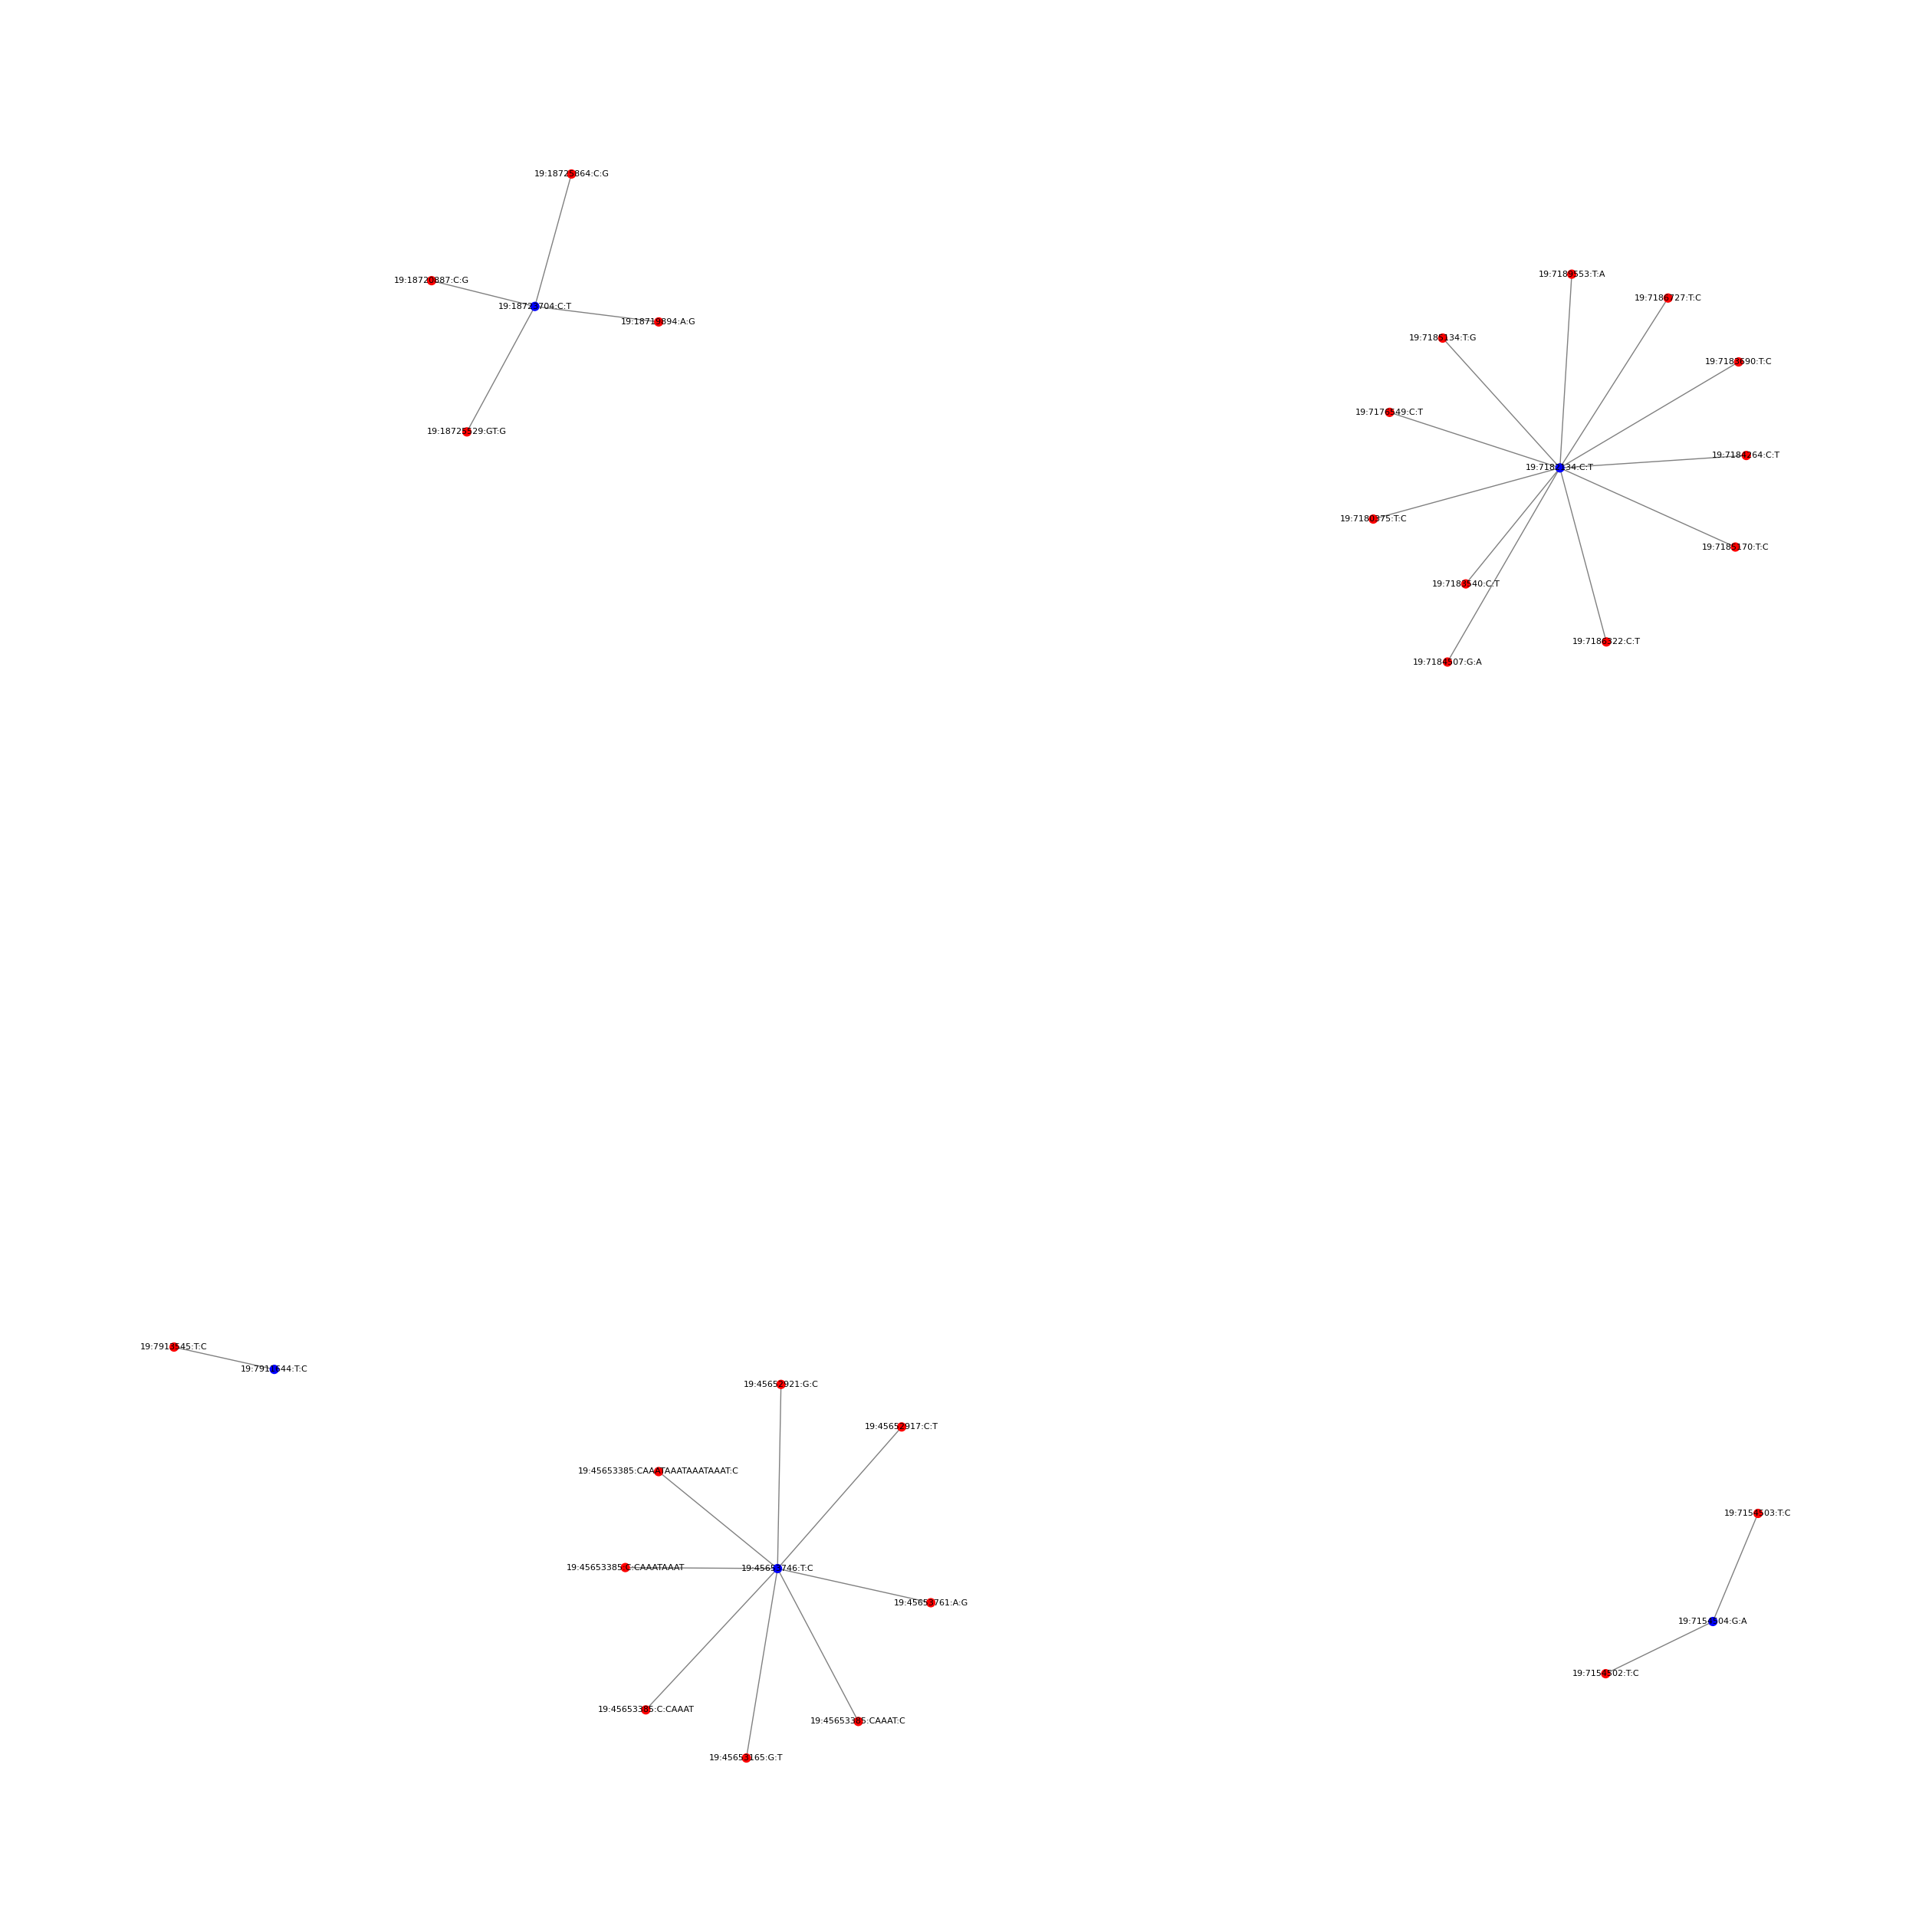

Chromosome 20


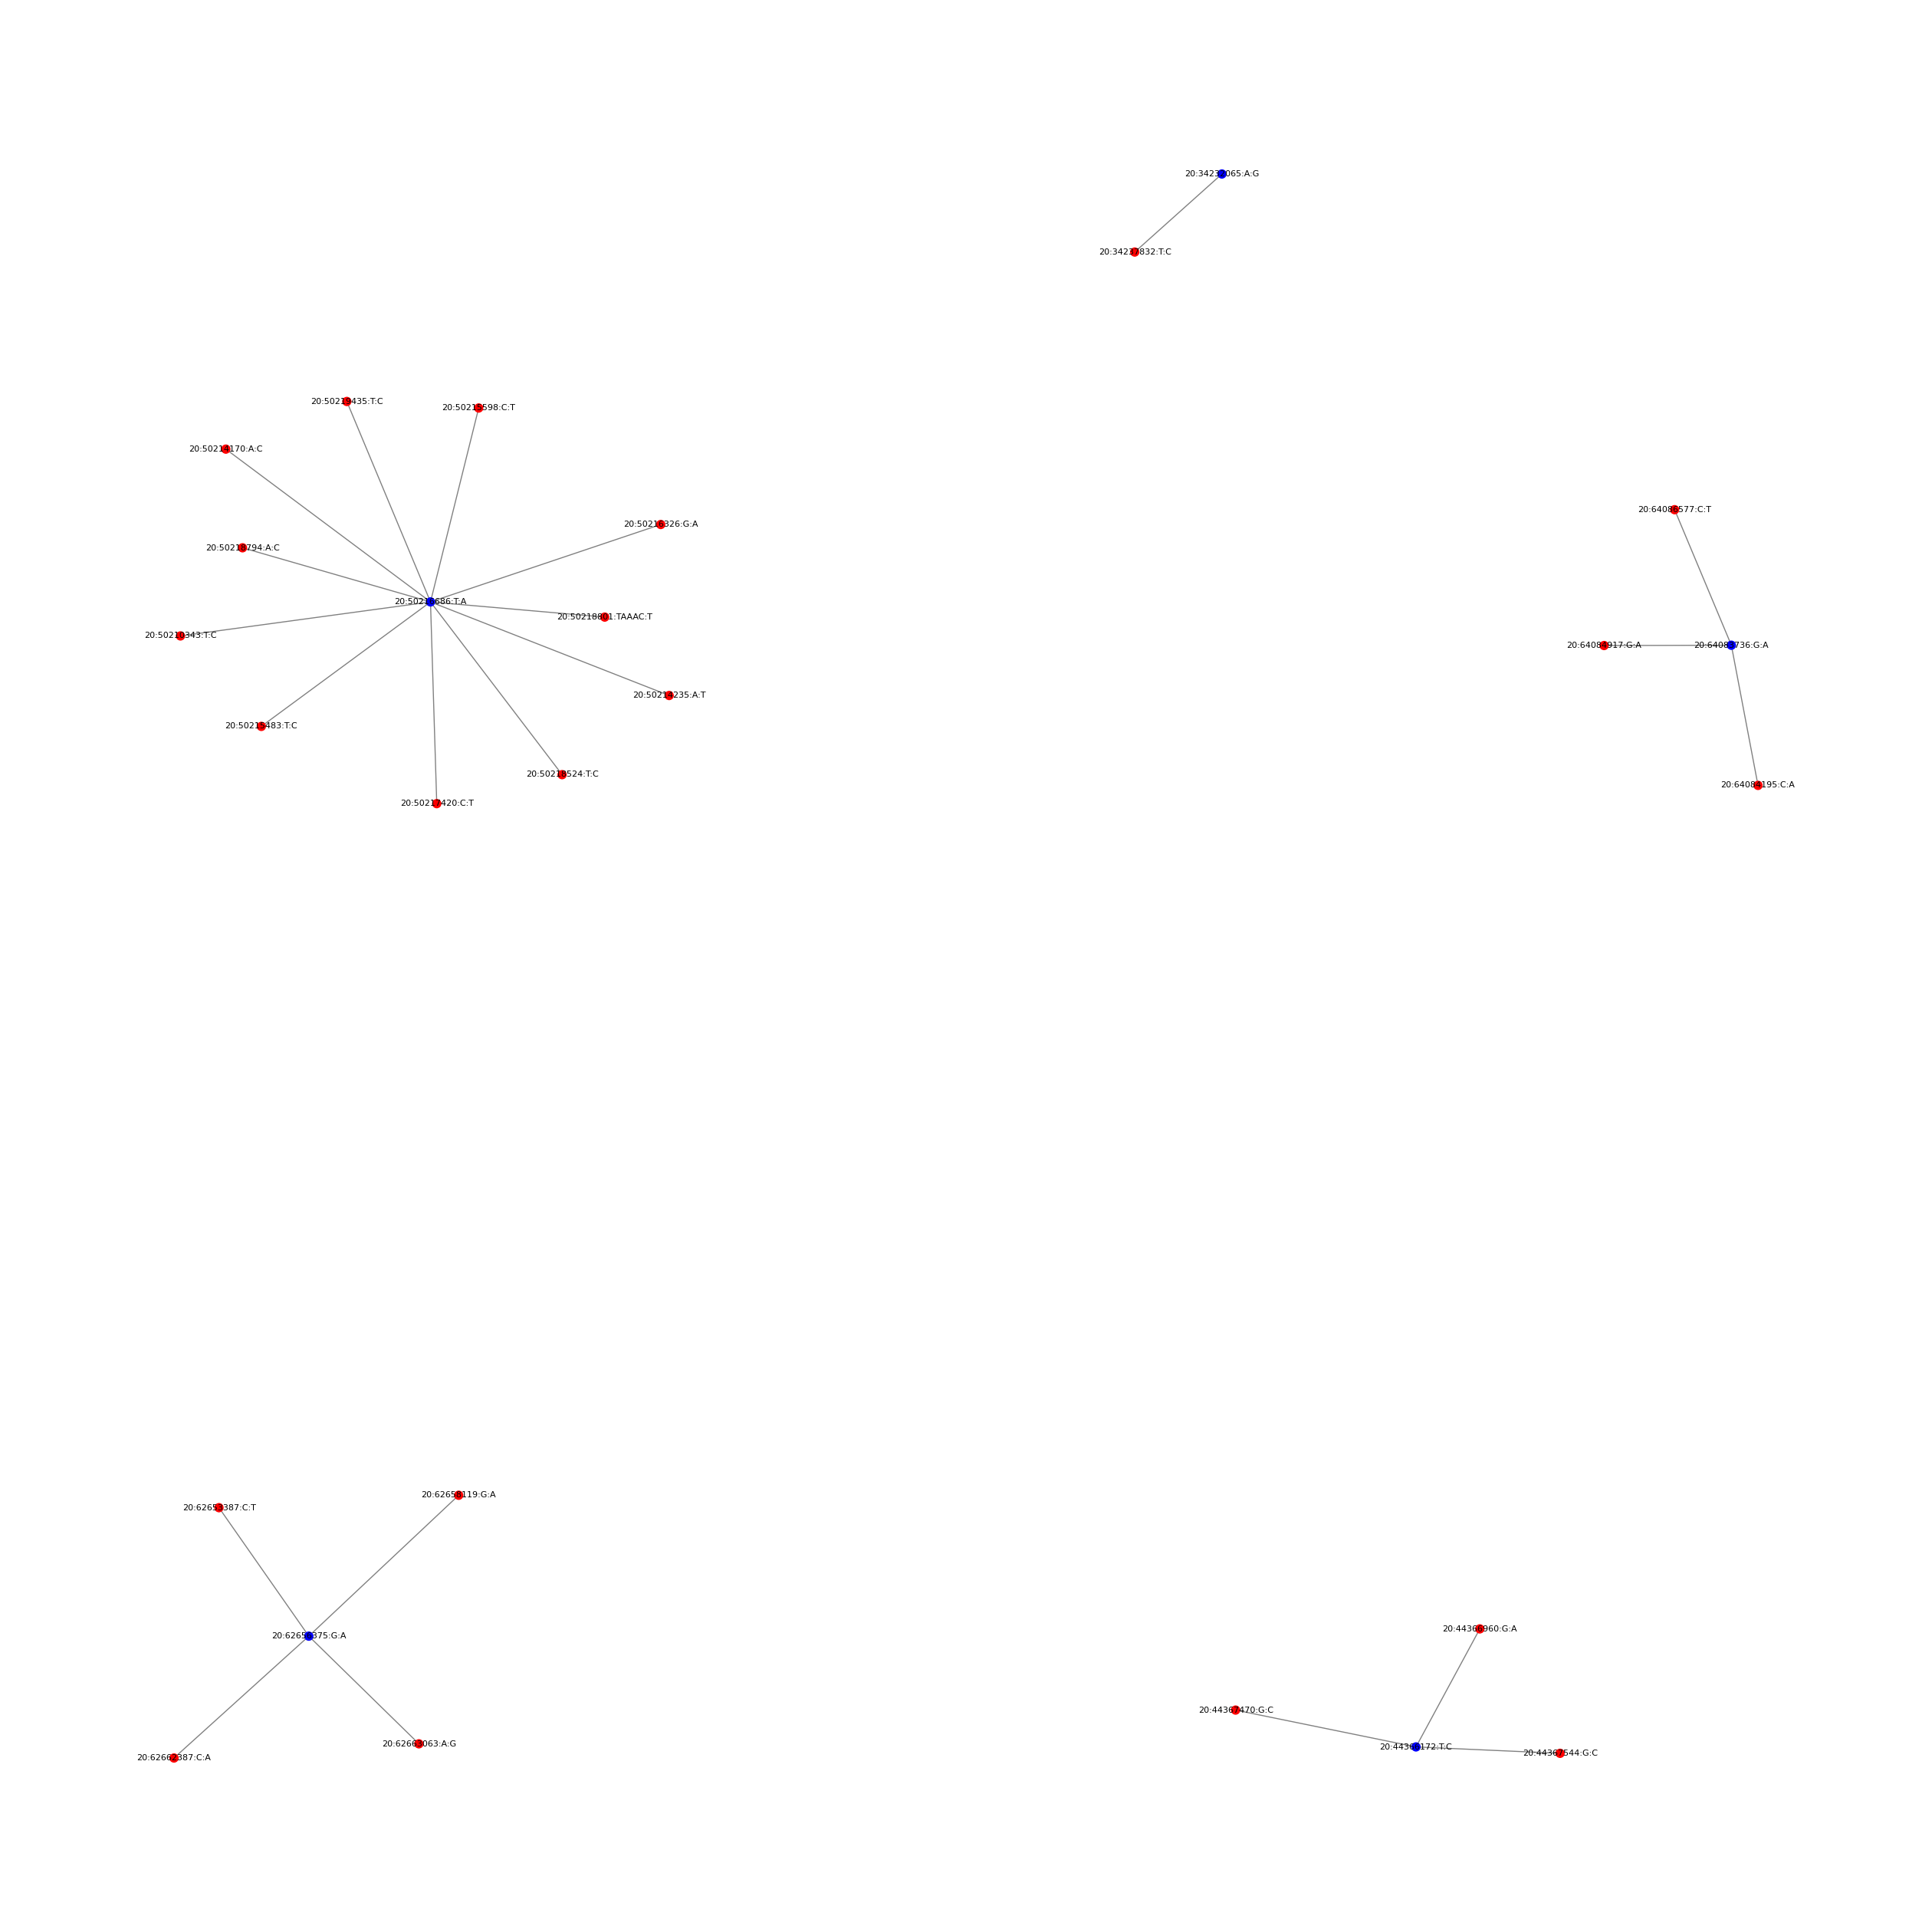

Chromosome 21
No nodes found for chromosome 21.
Chromosome 22


<Figure size 2500x2500 with 0 Axes>

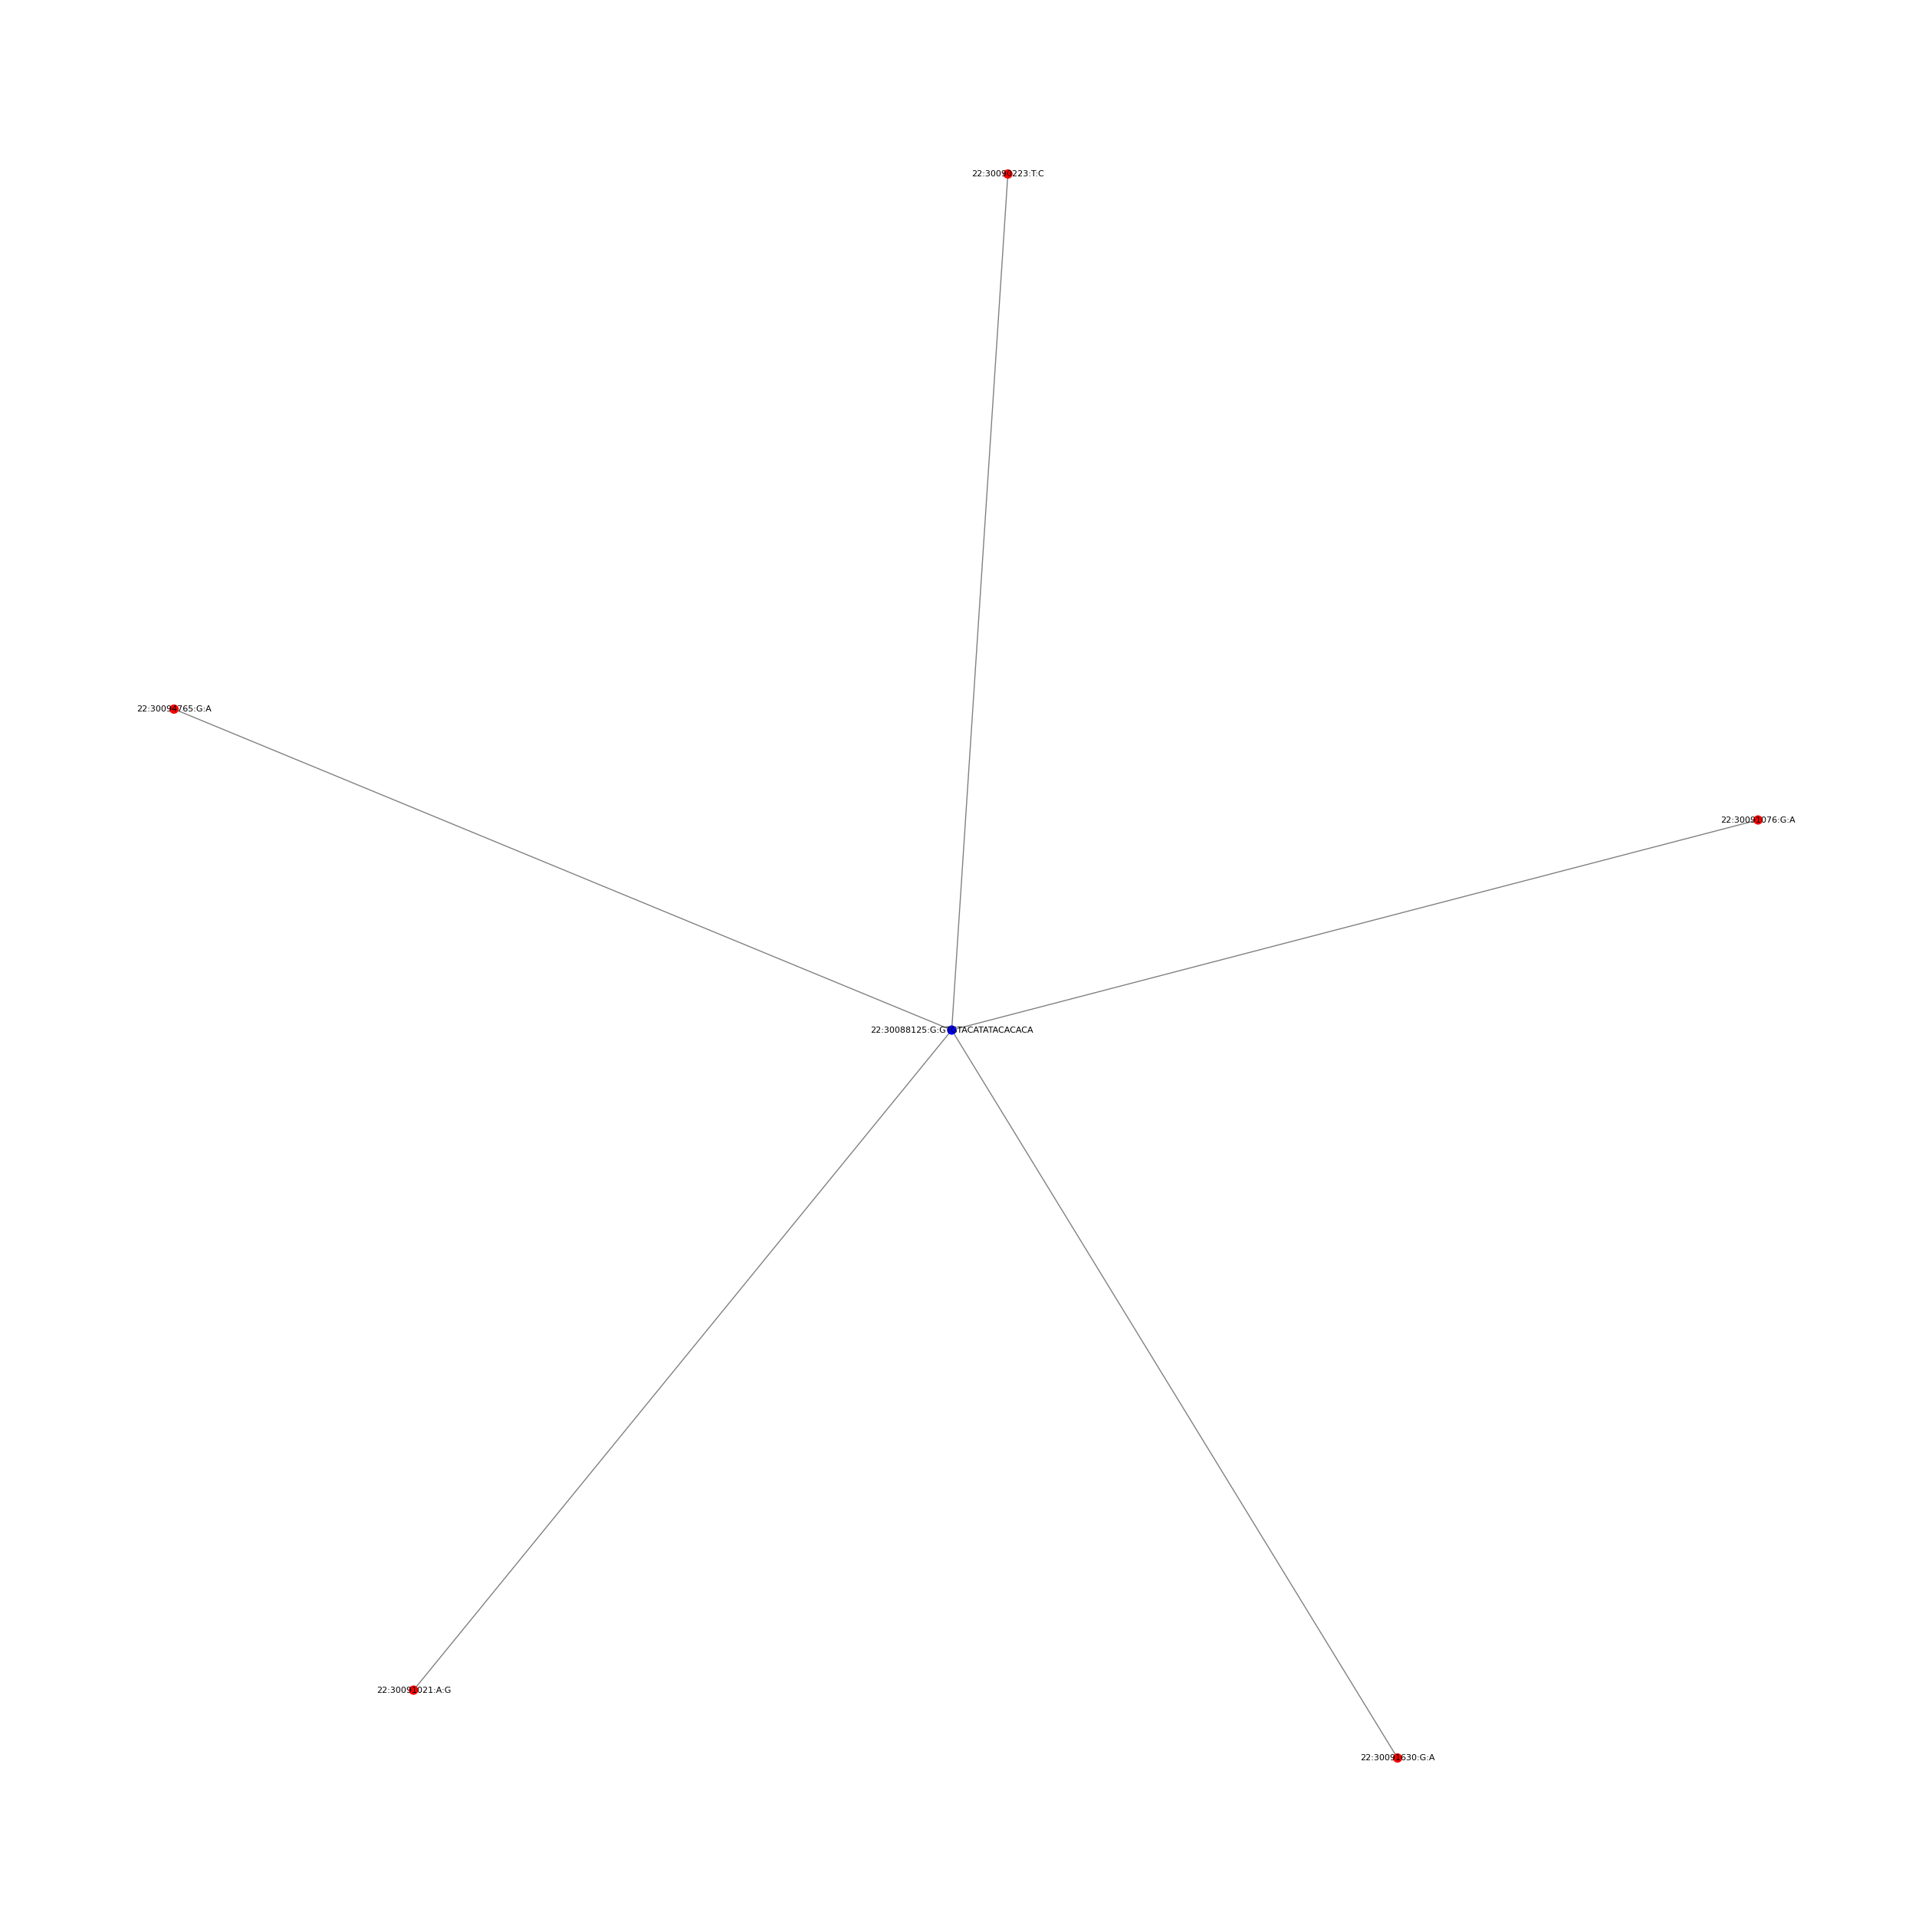

Chromosome 23


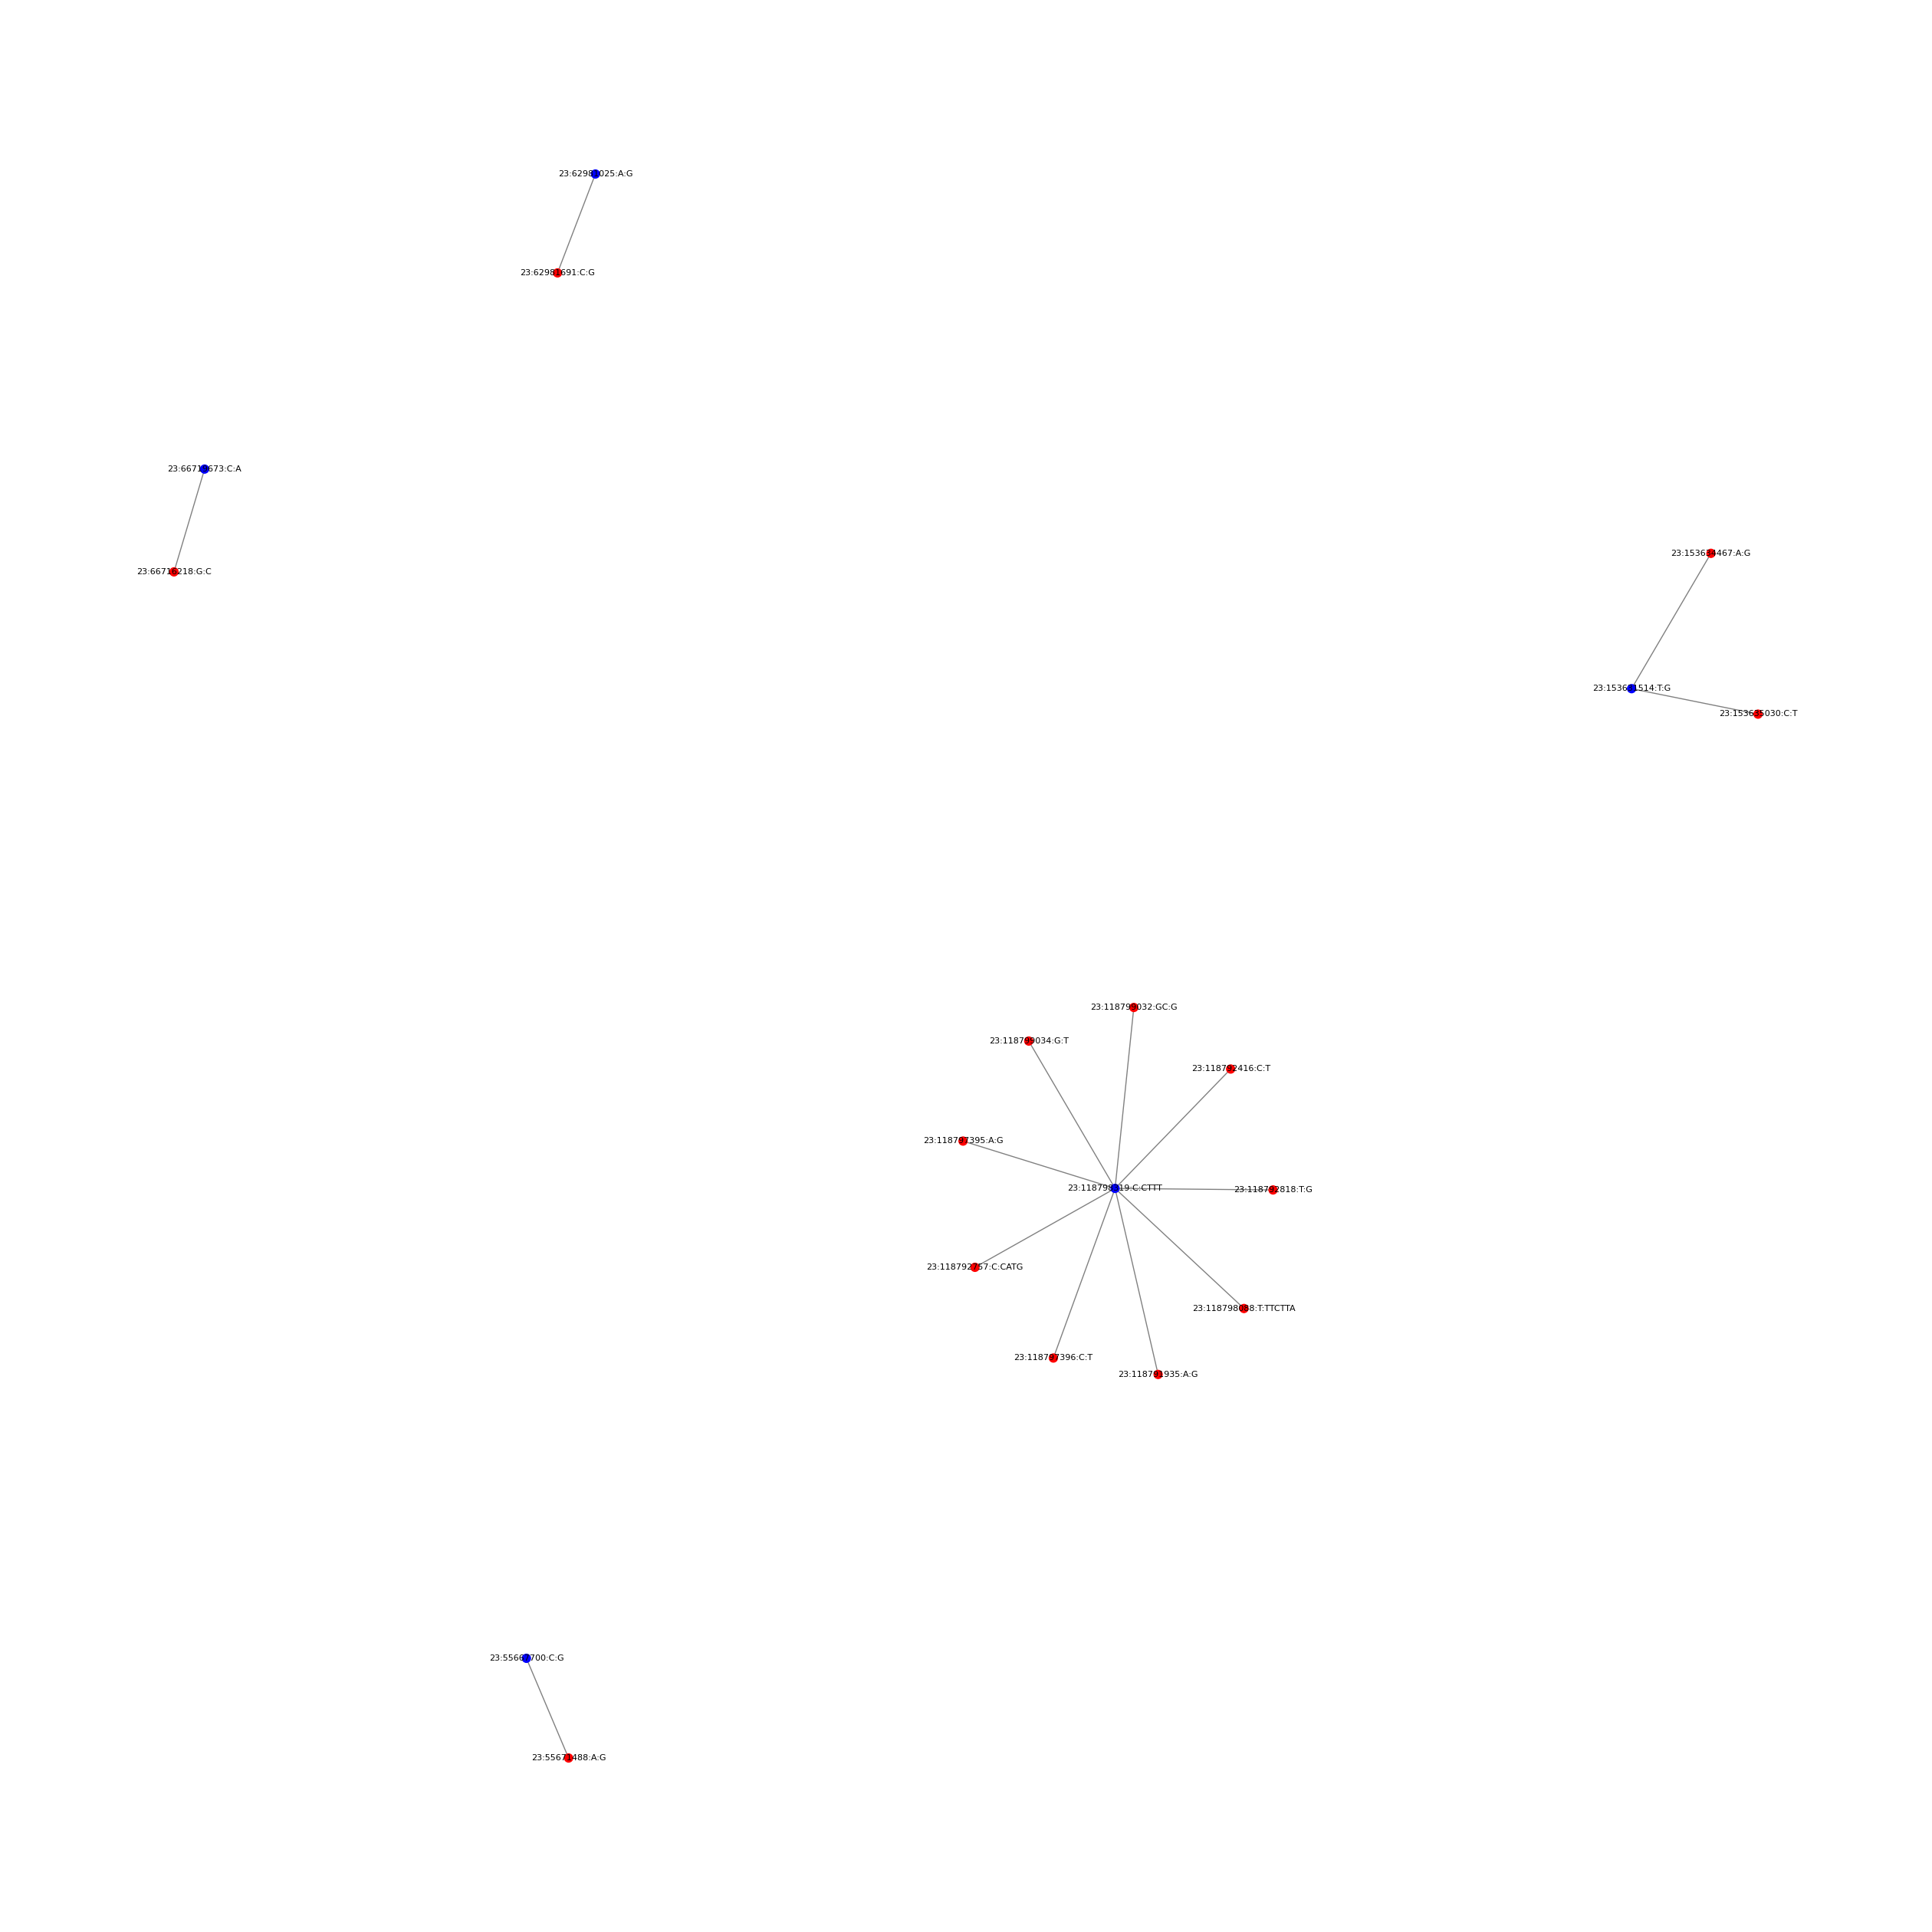

In [8]:
def visualize_graph(graph, chromosome: str):
    plt.figure(figsize=(25, 25))  # Increase figure size for better visibility
    
    # Create a subgraph for the specified chromosome
    nodes_chromosome = [node for node, attr in graph.nodes(data=True) if attr.get('#chrom') == chromosome]
    subgraph = graph.subgraph(nodes_chromosome)

    if subgraph.number_of_nodes() == 0:
        print(f"No nodes found for chromosome {chromosome}.")
        return

    # Differentiate node colors by 'leader' or 'follower'
    node_colors = []
    for node in subgraph.nodes:
        node_type = 'blue' if node in data['lead'].values else 'red'
        node_colors.append(node_type)

    pos = nx.spring_layout(subgraph, k=0.3)  
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=60, 
            font_size=8, edge_color='gray')  
    
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)  
    
    plt.show()

# To visualize all chromosomes from 1 to 23, iterate over these numbers and call the function for each one:
for i in range(1, 24):
    print(f"Chromosome {i}")
    visualize_graph(graph, str(i))


## Export graph

In [9]:
#nx.write_graphml(graph, 'graph.graphml')
#graph = nx.read_graphml('graph.graphml')